In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

In [2]:
from sklearn.model_selection import train_test_split

def splitTrainTestValid(x: np.array, y: np.array, splitRatio: np.array) -> tuple[tuple[np.array]]:
    trainSize = splitRatio[0]
    testSize = splitRatio[1]
    validSize = splitRatio[2]

    xTemp, xTesting, yTemp, yTesting = train_test_split(x, y, test_size=testSize, random_state=42)

    xTraining, xValidation, yTraining, yValidation = train_test_split(
        xTemp, yTemp, test_size=validSize / (trainSize + validSize), random_state=42)

    return (xTraining, yTraining), (xTesting, yTesting), (xValidation, yValidation)

def minMaxScaling(dataArray: np.array) -> np.array:
    featureMinimums = np.min(dataArray, axis=0)
    featureMaximums = np.max(dataArray, axis=0)
    
    featureRanges = featureMaximums - featureMinimums
    featureRanges = np.where(featureRanges == 0, 1, featureRanges)
    
    scaledDataArray = (dataArray - featureMinimums) / featureRanges
    return scaledDataArray

def sigmoid(xi: np.array, parameters: np.array) -> float:
    return 1 / (1 + np.exp(-np.dot(xi, parameters)))

def costFunctionLogisticRegression(x: np.array, y: np.array, parameters: np.array) -> float:
    z = np.dot(x, parameters)
    insideExponential = -(2 * y - 1) * z
    expValues = np.exp(np.minimum(insideExponential, 0))
    logTerm = np.log(1 + expValues)
    return np.mean(np.where(insideExponential >= 0, insideExponential + logTerm, logTerm))

def batchGradientDescent(learningRate: float, iterations: int, x: np.array, y: np.array, parameters: np.array, hypothesis: Callable[[np.array, np.array], float]) -> np.array:
    for iteration in range(iterations):
        predictions = sigmoid(x, parameters)
        errors = predictions - y
        gradients = (x.T @ errors) / len(x)
        parameters -= learningRate * gradients
    return parameters

def batchGradientDescentL2Regularization(learningRate: float, iterations: int, x: np.array, y: np.array, parameters: np.array, hypothesis: Callable[[np.array, np.array], float], regularizationCoefficient: float) -> np.array:
    for iteration in range(iterations):
        predictions = sigmoid(x, parameters)
        errors = predictions - y
        gradients = (x.T @ errors) / len(x) + 2 * regularizationCoefficient * parameters
        parameters -= learningRate * gradients
    return parameters

def batchGradientDescentL1Regularization(learningRate: float, iterations: int, x: np.array, y: np.array, parameters: np.array, hypothesis: Callable[[np.array, np.array], float], regularizationCoefficient: float) -> np.array:
    for iteration in range(iterations):
        predictions = sigmoid(x, parameters)
        errors = predictions - y
        gradients = (x.T @ errors) / len(x) + regularizationCoefficient * np.sign(parameters)
        parameters -= learningRate * gradients
    return parameters

def stochasticGradientDescent(learningRate: float, iterations: int, x: np.array, y: np.array, parameters: np.array, hypothesis: Callable[[np.array, np.array], float]) -> np.array:
    for iteration in range(iterations):
        for i in range(len(x)):
            h = sigmoid(x[i], parameters)
            error = h - y[i]
            parameters -= learningRate * error * x[i]
    return parameters

def miniBatchGradientDescent(learningRate: float, iterations: int, x: np.array, y: np.array, parameters: np.array, hypothesis: Callable[[np.array, np.array], float], batchSize: int) -> np.array:
    numSamples = len(x)
    for iteration in range(iterations):
        for batchStart in range(0, numSamples, batchSize):
            batchEnd = min(batchStart + batchSize, numSamples)
            xBatch = x[batchStart:batchEnd]
            yBatch = y[batchStart:batchEnd]
            predictions = sigmoid(xBatch, parameters)
            errors = predictions - yBatch
            gradients = (xBatch.T @ errors) / batchSize
            parameters -= learningRate * gradients
    return parameters

def predictClass(xi: np.array, parameters: np.array, hypothesis: Callable[[np.array, np.array], float]) -> int:
    return int(sigmoid(xi, parameters) >= 0.5)

def calculateLoss(xTraining: np.array, yTraining: np.array, xValidation: np.array, yValidation: np.array, parameters: np.array) -> tuple[float]:
    trainingLoss = costFunctionLogisticRegression(xTraining, yTraining, parameters)
    validationLoss = costFunctionLogisticRegression(xValidation, yValidation, parameters)
    return trainingLoss, validationLoss

def calculateAccuracy(xTraining: np.array, yTraining: np.array, xValidation: np.array, yValidation: np.array, parameters: np.array) -> tuple[float]:
    trainingPredictions = (sigmoid(xTraining, parameters) >= 0.5).astype(int)
    validationPredictions = (sigmoid(xValidation, parameters) >= 0.5).astype(int)
    trainingAccuracy = np.mean(trainingPredictions == yTraining)
    validationAccuracy = np.mean(validationPredictions == yValidation)
    return trainingAccuracy, validationAccuracy

def confusionMatrixMetrics(x: np.array, y: np.array, parameters: np.array) -> np.array:
    predictions = (sigmoid(x, parameters) >= 0.5).astype(int)
    TP = np.sum((predictions == 1) & (y == 1))
    TN = np.sum((predictions == 0) & (y == 0))
    FP = np.sum((predictions == 1) & (y == 0))
    FN = np.sum((predictions == 0) & (y == 1))
    return np.array([TP, FP, TN, FN])


## **(a) (3 marks) Implement Logistic Regression using Batch Gradient Descent**

In [3]:
dataframe = pd.read_csv("Heart Disease.csv")

rows_before = len(dataframe)
dataframe = dataframe.dropna()
rows_after = len(dataframe)
print(f"Before removing rows with NA values, the dataset had {rows_before} rows. After using dropna(), it now contains {rows_after} rows.\nThis means that {rows_before-rows_after} rows with missing values were removed.\n")

y = dataframe["HeartDisease"].values
dropColumns = ["HeartDisease"]
x = dataframe.drop(columns=dropColumns).values
x = np.insert(x, 0, 1, axis=1)

ratioArray = np.array([0.7, 0.15, 0.15])
(xTraining,yTraining), (xTesting,yTesting), (xValidation,yValidation) = splitTrainTestValid(x, y, np.array(ratioArray))

print(f"Samples in Training set : {len(xTraining)}  ({ratioArray[0]*100}%)")
print(f"Samples in Testing set : {len(xTesting)}  ({ratioArray[1]*100}%)")
print(f"Samples in Validation set : {len(xValidation)}  ({ratioArray[2]*100}%)")

Before removing rows with NA values, the dataset had 4238 rows. After using dropna(), it now contains 3656 rows.
This means that 582 rows with missing values were removed.

Samples in Training set : 2558  (70.0%)
Samples in Testing set : 549  (15.0%)
Samples in Validation set : 549  (15.0%)


In [4]:
learningRate = 0.0001
iterations = 1000
countFeatures = len(xTraining[0])

parameters = np.ones(countFeatures)
trainingLoss = np.empty(iterations)
validationLoss = np.empty(iterations)
trainingAccuracy = np.empty(iterations)
validationAccuracy = np.empty(iterations)

for iteration in range(0,iterations):
    parameters = batchGradientDescent(learningRate, 1, xTraining, yTraining, parameters, sigmoid)
    (trainingLoss[iteration], validationLoss[iteration]) = calculateLoss(xTraining,yTraining,xValidation,yValidation,parameters)
    (trainingAccuracy[iteration], validationAccuracy[iteration]) = calculateAccuracy(xTraining,yTraining,xValidation,yValidation,parameters)

parametersNoScaling = parameters
trainingLossNoScaling = trainingLoss
validationLossNoScaling = validationLoss
trainingAccuracyNoScaling = trainingAccuracy
validationAccuracyNoScaling = validationAccuracy

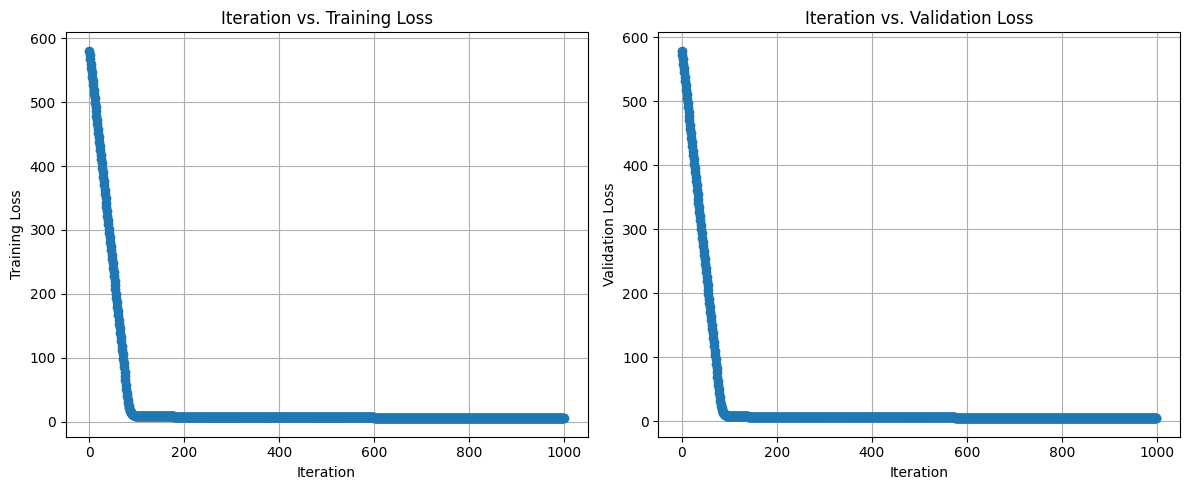

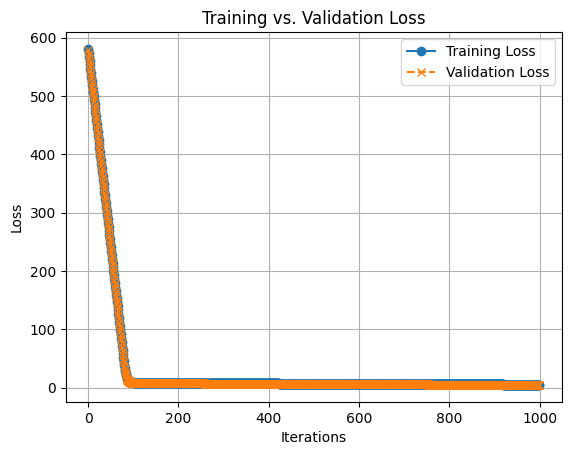

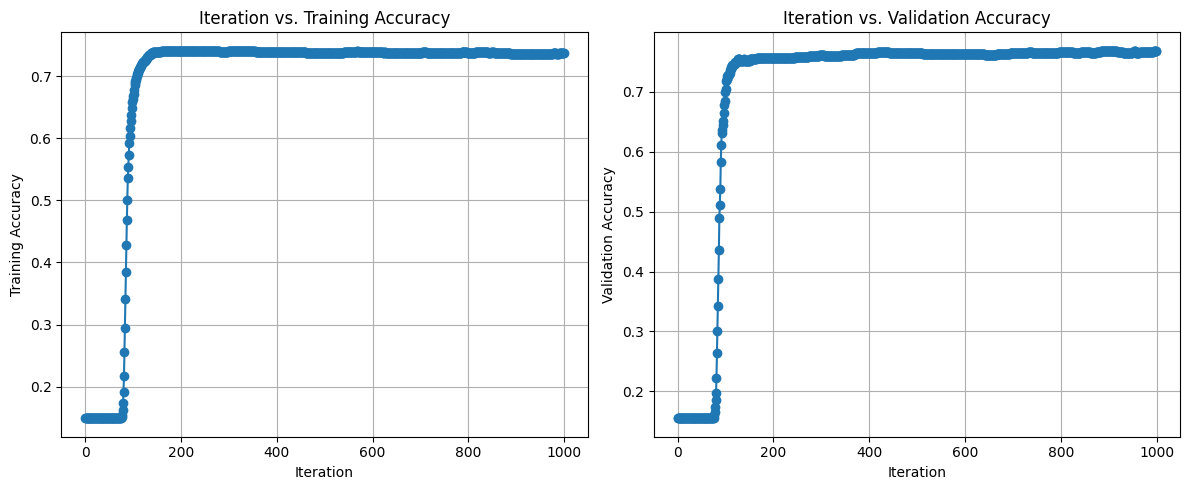

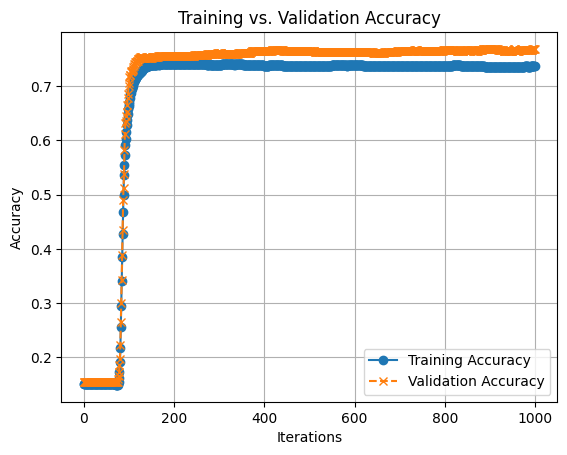

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Iteration vs. Training Loss
axes[0].plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Iteration vs. Training Loss')
axes[0].grid(True)

# Iteration vs. Validation Loss
axes[1].plot(range(len(validationLoss)), validationLoss, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Iteration vs. Validation Loss')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Training Loss vs. Validation Loss
plt.plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-', label='Training Loss')
plt.plot(range(len(validationLoss)), validationLoss, marker='x', linestyle='--', label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.grid(True)
plt.legend()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Iteration vs. Training Accuracy
axes[0].plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Training Accuracy')
axes[0].set_title('Iteration vs. Training Accuracy')
axes[0].grid(True)

# Iteration vs. Validation Accuracy
axes[1].plot(range(len(validationAccuracy)), validationAccuracy, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Iteration vs. Validation Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Training Loss vs. Validation Accuracy
plt.plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(range(len(validationAccuracy)), validationAccuracy, marker='x', linestyle='--', label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()


## **(b) (2 marks) Investigate and compare the performance of the model with different feature scaling methods: Min-max scaling and No scaling**

In [6]:
dataframe = pd.read_csv("Heart Disease.csv")

rows_before = len(dataframe)
dataframe = dataframe.dropna()
rows_after = len(dataframe)
print(f"Before removing rows with NA values, the dataset had {rows_before} rows. After using dropna(), it now contains {rows_after} rows.\nThis means that {rows_before-rows_after} rows with missing values were removed.\n")

y = dataframe["HeartDisease"].values
dropColumns = ["HeartDisease"]
x = dataframe.drop(columns=dropColumns).values
x = np.insert(x, 0, 1, axis=1)
x = minMaxScaling(x)

ratioArray = np.array([0.7, 0.15, 0.15])
(xTraining,yTraining), (xTesting,yTesting), (xValidation,yValidation) = splitTrainTestValid(x, y, np.array(ratioArray))

print(f"Samples in Training set : {len(xTraining)}  ({ratioArray[0]*100}%)")
print(f"Samples in Testing set : {len(xTesting)}  ({ratioArray[1]*100}%)")
print(f"Samples in Validation set : {len(xValidation)}  ({ratioArray[2]*100}%)")

Before removing rows with NA values, the dataset had 4238 rows. After using dropna(), it now contains 3656 rows.
This means that 582 rows with missing values were removed.

Samples in Training set : 2558  (70.0%)
Samples in Testing set : 549  (15.0%)
Samples in Validation set : 549  (15.0%)


In [7]:
learningRate = 0.05
iterations = 1000
countFeatures = len(xTraining[0])

parameters = np.ones(countFeatures)
trainingLoss = np.empty(iterations)
validationLoss = np.empty(iterations)
trainingAccuracy = np.empty(iterations)
validationAccuracy = np.empty(iterations)

testingLoss = np.empty(iterations)
testingAccuracy = np.empty(iterations)

for iteration in range(0,iterations):
    parameters = batchGradientDescent(learningRate, 1, xTraining, yTraining, parameters, sigmoid)
    (trainingLoss[iteration], validationLoss[iteration]) = calculateLoss(xTraining,yTraining,xValidation,yValidation,parameters)
    (trainingAccuracy[iteration], validationAccuracy[iteration]) = calculateAccuracy(xTraining,yTraining,xValidation,yValidation,parameters)
    
    testingLoss[iteration] = costFunctionLogisticRegression(xTesting, yTesting, parameters)
    testingPredictions = (sigmoid(xTesting, parameters) >= 0.5).astype(int)
    testingAccuracy[iteration] = np.mean(testingPredictions == yTesting)

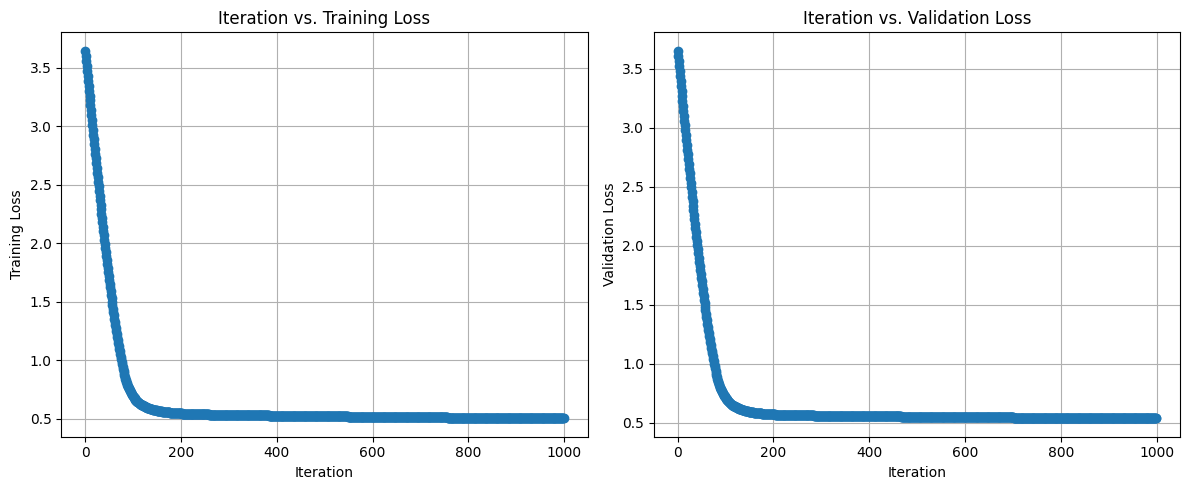

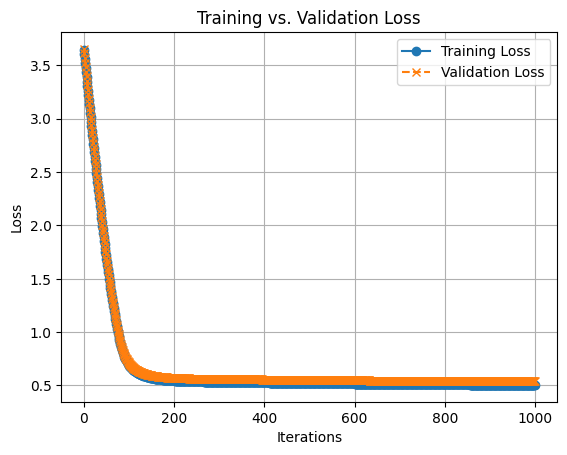

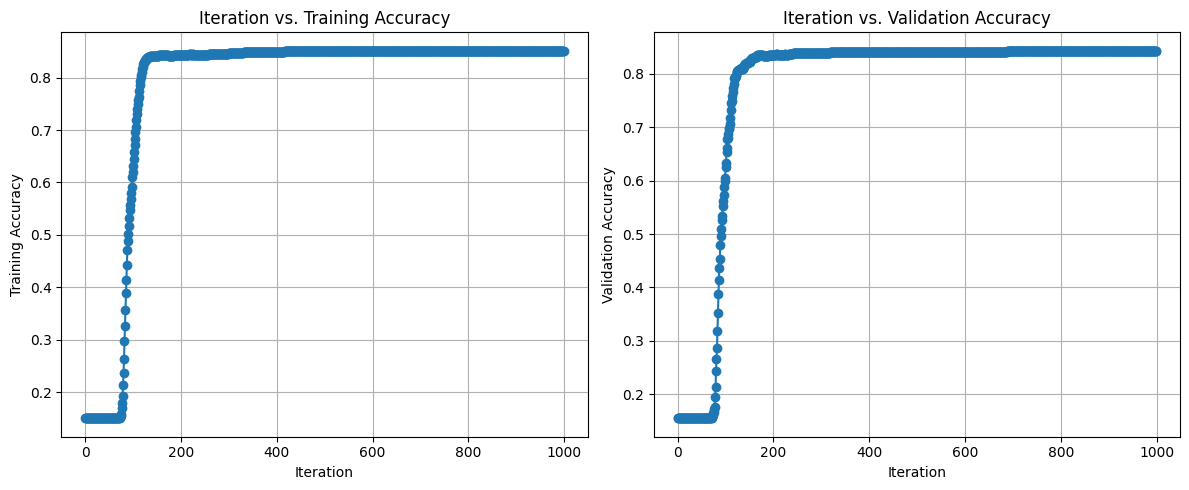

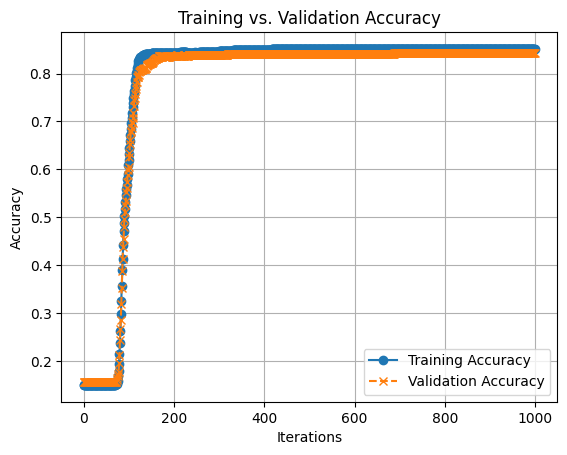

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Iteration vs. Training Loss
axes[0].plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Iteration vs. Training Loss')
axes[0].grid(True)

# Iteration vs. Validation Loss
axes[1].plot(range(len(validationLoss)), validationLoss, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Iteration vs. Validation Loss')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Training Loss vs. Validation Loss
plt.plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-', label='Training Loss')
plt.plot(range(len(validationLoss)), validationLoss, marker='x', linestyle='--', label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.grid(True)
plt.legend()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Iteration vs. Training Accuracy
axes[0].plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Training Accuracy')
axes[0].set_title('Iteration vs. Training Accuracy')
axes[0].grid(True)

# Iteration vs. Validation Accuracy
axes[1].plot(range(len(validationAccuracy)), validationAccuracy, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Iteration vs. Validation Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Training Loss vs. Validation Accuracy
plt.plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(range(len(validationAccuracy)), validationAccuracy, marker='x', linestyle='--', label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

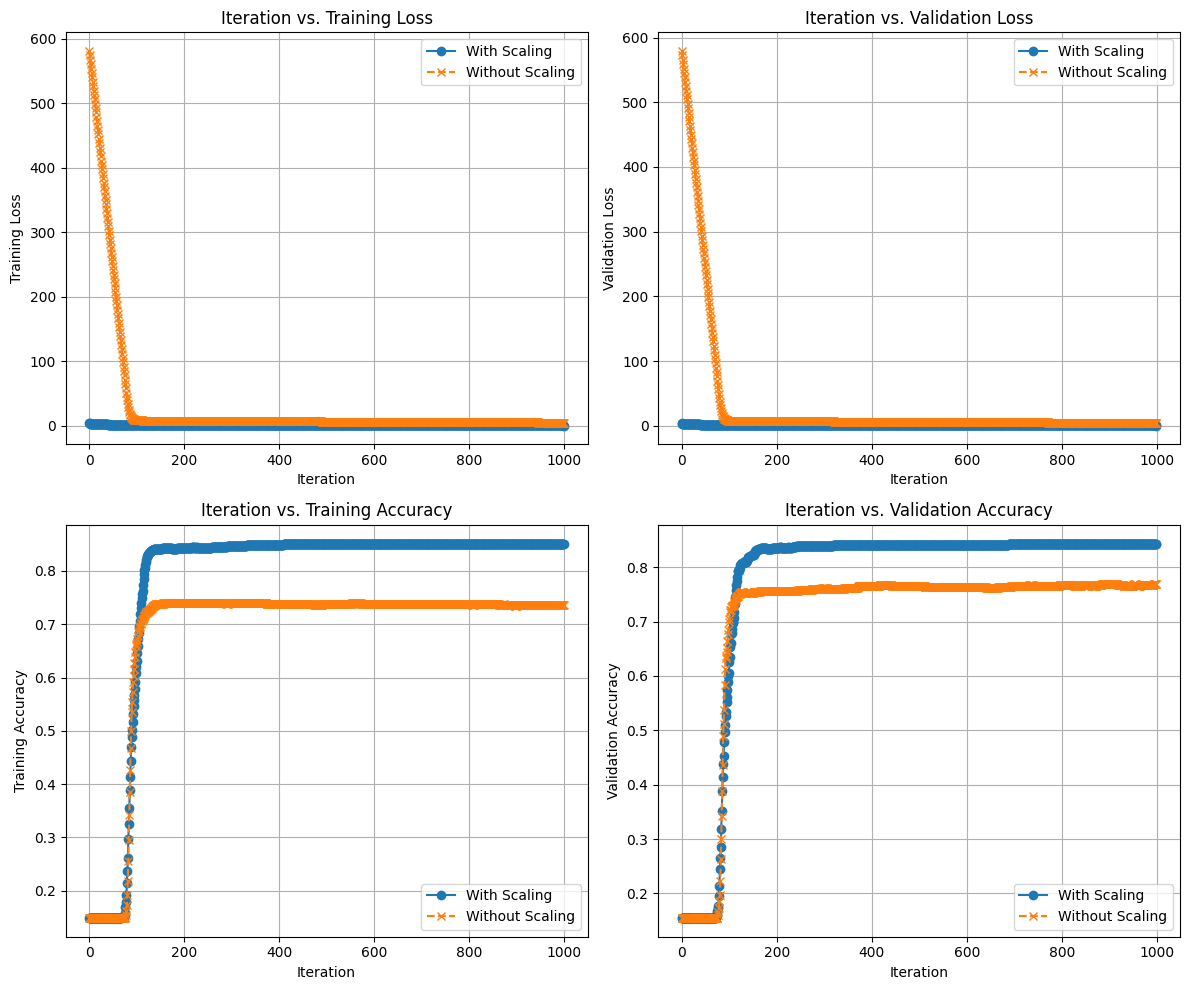

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Iteration vs. Training Loss (with and without scaling)
axes[0, 0].plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-', label='With Scaling')
axes[0, 0].plot(range(len(trainingLossNoScaling)), trainingLossNoScaling, marker='x', linestyle='--', label='Without Scaling')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Training Loss')
axes[0, 0].set_title('Iteration vs. Training Loss')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Iteration vs. Validation Loss (with and without scaling)
axes[0, 1].plot(range(len(validationLoss)), validationLoss, marker='o', linestyle='-', label='With Scaling')
axes[0, 1].plot(range(len(validationLossNoScaling)), validationLossNoScaling, marker='x', linestyle='--', label='Without Scaling')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Validation Loss')
axes[0, 1].set_title('Iteration vs. Validation Loss')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Iteration vs. Training Accuracy (with and without scaling)
axes[1, 0].plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-', label='With Scaling')
axes[1, 0].plot(range(len(trainingAccuracyNoScaling)), trainingAccuracyNoScaling, marker='x', linestyle='--', label='Without Scaling')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Training Accuracy')
axes[1, 0].set_title('Iteration vs. Training Accuracy')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Iteration vs. Validation Accuracy (with and without scaling)
axes[1, 1].plot(range(len(validationAccuracy)), validationAccuracy, marker='o', linestyle='-', label='With Scaling')
axes[1, 1].plot(range(len(validationAccuracyNoScaling)), validationAccuracyNoScaling, marker='x', linestyle='--', label='Without Scaling')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].set_title('Iteration vs. Validation Accuracy')
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## **(c) (2 marks) Calculate and present the confusion matrix for the validation set.**

In [10]:
import seaborn as sb
import matplotlib.colors as mcolors
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [11]:
parameters = parameters[:1000]
trainingLoss = trainingLoss[:1000]
validationLoss = validationLoss[:1000]
trainingAccuracy = trainingAccuracy[:1000]
validationAccuracy = validationAccuracy[:1000]

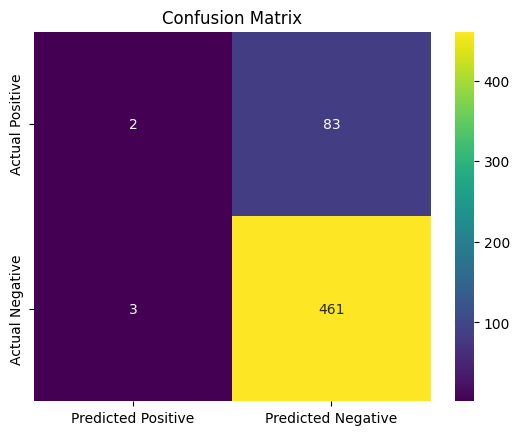

In [12]:
[TP,FP,TN,FN] = confusionMatrixMetrics(xValidation,yValidation,parameters)
confusionMetrics = [[TP,FN],[FP,TN]]

sb.heatmap(confusionMetrics, annot=True, fmt="d", cmap="viridis", xticklabels=["Predicted Positive", "Predicted Negative"], yticklabels=["Actual Positive", "Actual Negative"])
plt.title("Confusion Matrix")
plt.show()

### **Classification Metrics**

1. Precision: Precision is the proportion of positive predictions that are actually correct.
   $$
   \text{Precision} = \frac{TP}{TP + FP}
   $$
   - TP (True Positives): Predicted positive and is actually positive.
   - FP (False Positives): Predicted positive but is actually negative.

2. Recall: Recall (also known as Sensitivity or True Positive Rate) is the proportion of actual positives that are correctly identified.
   $$
   \text{Recall} = \frac{TP}{TP + FN}
   $$
   - FN (False Negatives): Predicted negative but is actually positive.

3. F1 Score: The F1 score is the harmonic mean of precision and recall, and it balances both measures.
   $$
   F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
   $$
   - It provides a better measure when precision and recall are imbalanced.

4. ROC-AUC Score: The ROC-AUC (Receiver Operating Characteristic - Area Under the Curve) score measures the ability of the classifier to distinguish between classes. It plots the true positive rate (recall) against the false positive rate.
   - AUC represents the probability that a randomly chosen positive example ranks higher than a randomly chosen negative example.
   - AUC values range from 0 to 1:
     - 1: Perfect classifier.
     - 0.5: Random guessing.
     - 0: Completely wrong classifier.


In [13]:
predictions = np.empty(len(xValidation))
probabilities = np.empty(len(xValidation))

for sample in range(0,len(xValidation)):
    predictions[sample] = predictClass(xValidation[sample],parameters,sigmoid)
    probabilities[sample] = sigmoid(xValidation[sample],parameters)

precision = precision_score(yValidation, predictions)
recall = recall_score(yValidation, predictions)
f1 = f1_score(yValidation, predictions)
roc_auc = roc_auc_score(yValidation, probabilities)


print(f"F1 Score: {f1:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"ROC-AUC Score: {roc_auc:.3f}")

F1 Score: 0.044
Recall: 0.024
Precision: 0.400
ROC-AUC Score: 0.452


## **(d) (3 marks) Implement and compare the following optimisation algorithms: Stochastic Gradient Descent and Mini-Batch Gradient Descent (with varying batch sizes, at least 2)**

In [14]:
dataframe = pd.read_csv("Heart Disease.csv")

rows_before = len(dataframe)
dataframe = dataframe.dropna()
rows_after = len(dataframe)
print(f"Before removing rows with NA values, the dataset had {rows_before} rows. After using dropna(), it now contains {rows_after} rows.\nThis means that {rows_before-rows_after} rows with missing values were removed.\n")

y = dataframe["HeartDisease"].values
dropColumns = ["HeartDisease"]
x = dataframe.drop(columns=dropColumns).values
x = np.insert(x, 0, 1, axis=1)
x = minMaxScaling(x)

ratioArray = np.array([0.7, 0.15, 0.15])
(xTraining,yTraining), (xTesting,yTesting), (xValidation,yValidation) = splitTrainTestValid(x, y, np.array(ratioArray))

print(f"Samples in Training set : {len(xTraining)}  ({ratioArray[0]*100}%)")
print(f"Samples in Testing set : {len(xTesting)}  ({ratioArray[1]*100}%)")
print(f"Samples in Validation set : {len(xValidation)}  ({ratioArray[2]*100}%)")

Before removing rows with NA values, the dataset had 4238 rows. After using dropna(), it now contains 3656 rows.
This means that 582 rows with missing values were removed.

Samples in Training set : 2558  (70.0%)
Samples in Testing set : 549  (15.0%)
Samples in Validation set : 549  (15.0%)


### **Stochastic Gradient Descent**

In [15]:
learningRate = 0.05
iterations = 1000
countFeatures = len(xTraining[0])

stochasticParameters = np.ones(countFeatures)
stochasticTrainingLoss = np.empty(iterations)
stochasticValidationLoss = np.empty(iterations)
stochasticTrainingAccuracy = np.empty(iterations)
stochasticValidationAccuracy = np.empty(iterations)

stochasticTestingLoss = np.empty(iterations)
stochasticTestingAccuracy = np.empty(iterations)

for iteration in range(0, iterations):
    stochasticParameters = stochasticGradientDescent(learningRate, 1, xTraining, yTraining, stochasticParameters, sigmoid)
    (stochasticTrainingLoss[iteration], stochasticValidationLoss[iteration]) = calculateLoss(xTraining, yTraining, xValidation, yValidation, stochasticParameters)
    (stochasticTrainingAccuracy[iteration], stochasticValidationAccuracy[iteration]) = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, stochasticParameters)


    stochasticTestingLoss[iteration] = costFunctionLogisticRegression(xTesting, yTesting, parameters)
    stochasticTestingPredictions = (sigmoid(xTesting, parameters) >= 0.5).astype(int)
    stochasticTestingAccuracy[iteration] = np.mean(stochasticTestingPredictions == yTesting)


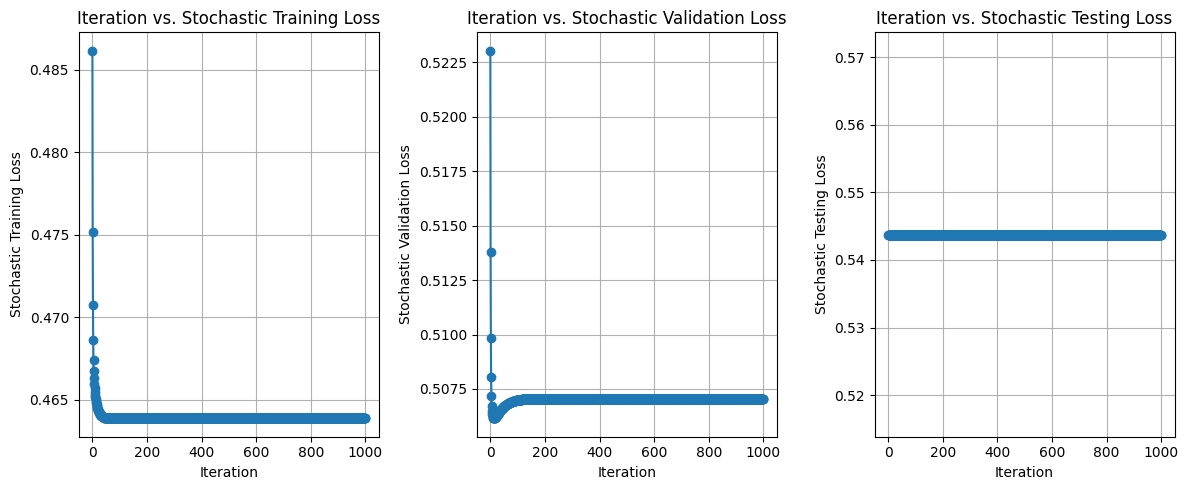

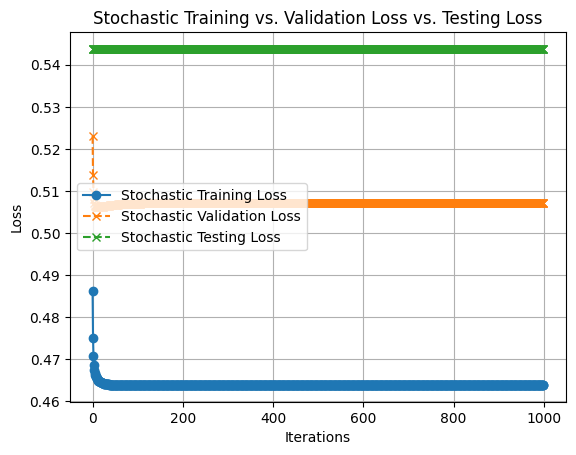

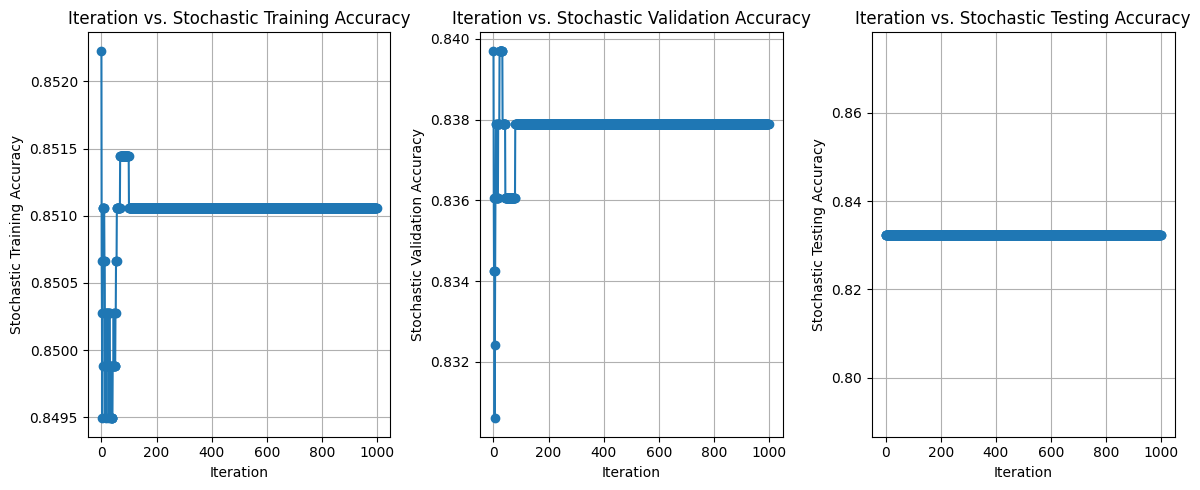

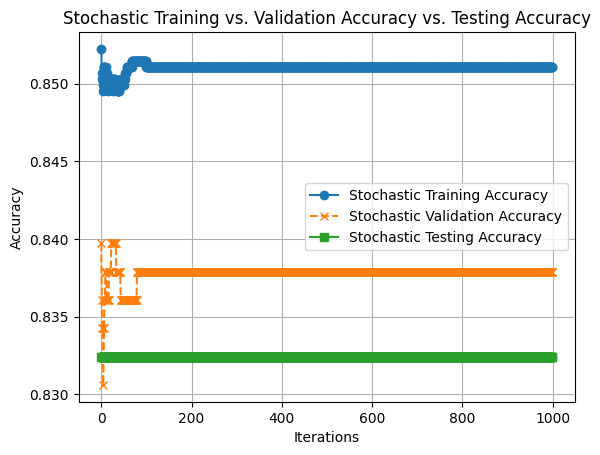

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Iteration vs. Stochastic Training Loss
axes[0].plot(range(len(stochasticTrainingLoss)), stochasticTrainingLoss, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Stochastic Training Loss')
axes[0].set_title('Iteration vs. Stochastic Training Loss')
axes[0].grid(True)

# Iteration vs. Stochastic Validation Loss
axes[1].plot(range(len(stochasticValidationLoss)), stochasticValidationLoss, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Stochastic Validation Loss')
axes[1].set_title('Iteration vs. Stochastic Validation Loss')
axes[1].grid(True)

# Iteration vs. Stochastic Testing Loss
axes[2].plot(range(len(stochasticTestingLoss)), stochasticTestingLoss, marker='o', linestyle='-')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Stochastic Testing Loss')
axes[2].set_title('Iteration vs. Stochastic Testing Loss')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Stochastic Training Loss vs. Stochastic Validation Loss
plt.plot(range(len(stochasticTrainingLoss)), stochasticTrainingLoss, marker='o', linestyle='-', label='Stochastic Training Loss')
plt.plot(range(len(stochasticValidationLoss)), stochasticValidationLoss, marker='x', linestyle='--', label='Stochastic Validation Loss')
plt.plot(range(len(stochasticTestingLoss)), stochasticTestingLoss, marker='x', linestyle='--', label='Stochastic Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Stochastic Training vs. Validation Loss vs. Testing Loss')
plt.grid(True)
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Iteration vs. Stochastic Training Accuracy
axes[0].plot(range(len(stochasticTrainingAccuracy)), stochasticTrainingAccuracy, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Stochastic Training Accuracy')
axes[0].set_title('Iteration vs. Stochastic Training Accuracy')
axes[0].grid(True)

# Iteration vs. Stochastic Validation Accuracy
axes[1].plot(range(len(stochasticValidationAccuracy)), stochasticValidationAccuracy, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Stochastic Validation Accuracy')
axes[1].set_title('Iteration vs. Stochastic Validation Accuracy')
axes[1].grid(True)

# Iteration vs. Stochastic Testing Accuracy
axes[2].plot(range(len(stochasticTestingAccuracy)), stochasticTestingAccuracy, marker='o', linestyle='-')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Stochastic Testing Accuracy')
axes[2].set_title('Iteration vs. Stochastic Testing Accuracy')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Stochastic Training Accuracy vs. Stochastic Validation Accuracy
plt.plot(range(len(stochasticTrainingAccuracy)), stochasticTrainingAccuracy, marker='o', linestyle='-', label='Stochastic Training Accuracy')
plt.plot(range(len(stochasticValidationAccuracy)), stochasticValidationAccuracy, marker='x', linestyle='--', label='Stochastic Validation Accuracy')
plt.plot(range(len(stochasticTestingAccuracy)), stochasticTestingAccuracy, marker='s', linestyle='-', label='Stochastic Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Stochastic Training vs. Validation Accuracy vs. Testing Accuracy')
plt.grid(True)
plt.legend()
plt.show()


### **Mini-Batch Gradient Descent [batchSize = 32]**

In [17]:
learningRate = 0.05
iterations = 1000
countFeatures = len(xTraining[0])
batchSize = 32

miniBatch32Parameters = np.ones(countFeatures)
miniBatch32TrainingLoss = np.empty(iterations)
miniBatch32ValidationLoss = np.empty(iterations)
miniBatch32TrainingAccuracy = np.empty(iterations)
miniBatch32ValidationAccuracy = np.empty(iterations)

miniBatch32TestingLoss = np.empty(iterations)
miniBatch32TestingAccuracy = np.empty(iterations)

for iteration in range(0, iterations):
    miniBatch32Parameters = miniBatchGradientDescent(learningRate, 1, xTraining, yTraining, miniBatch32Parameters, sigmoid, batchSize)
    (miniBatch32TrainingLoss[iteration], miniBatch32ValidationLoss[iteration]) = calculateLoss(xTraining, yTraining, xValidation, yValidation, miniBatch32Parameters)
    (miniBatch32TrainingAccuracy[iteration], miniBatch32ValidationAccuracy[iteration]) = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, miniBatch32Parameters)


    miniBatch32TestingLoss[iteration] = costFunctionLogisticRegression(xTesting, yTesting, parameters)
    miniBatch32TestingPredictions = (sigmoid(xTesting, parameters) >= 0.5).astype(int)
    miniBatch32TestingAccuracy[iteration] = np.mean(miniBatch32TestingPredictions == yTesting)

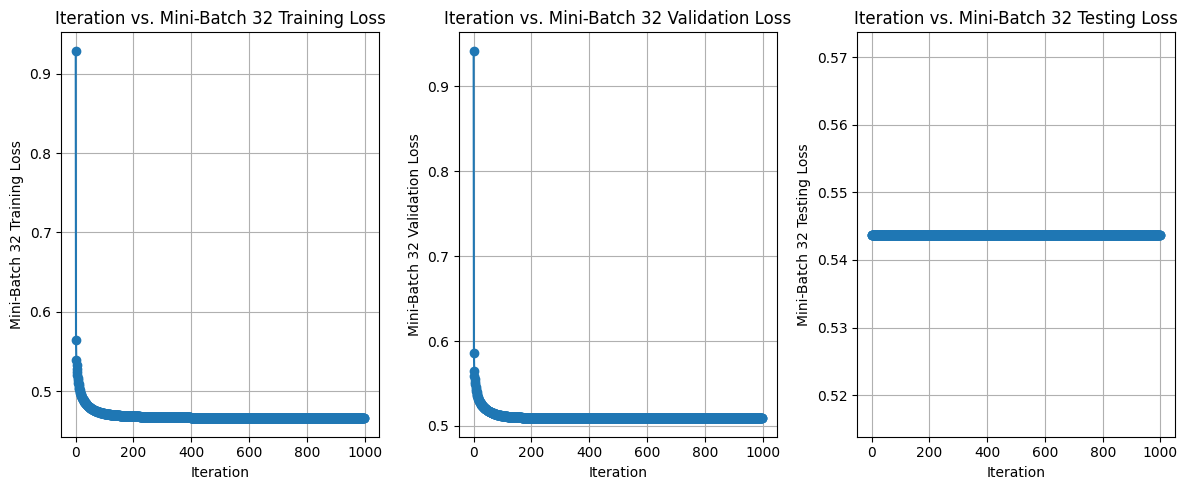

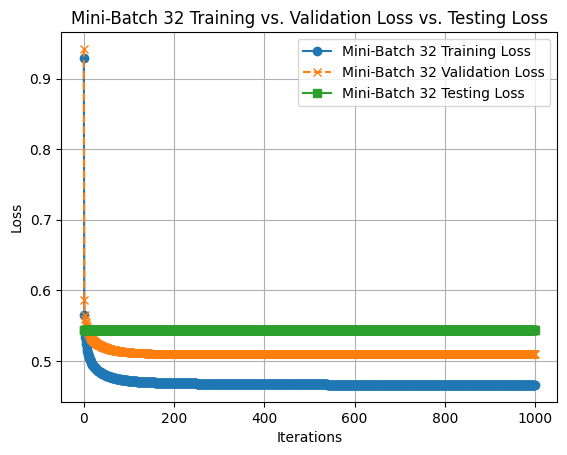

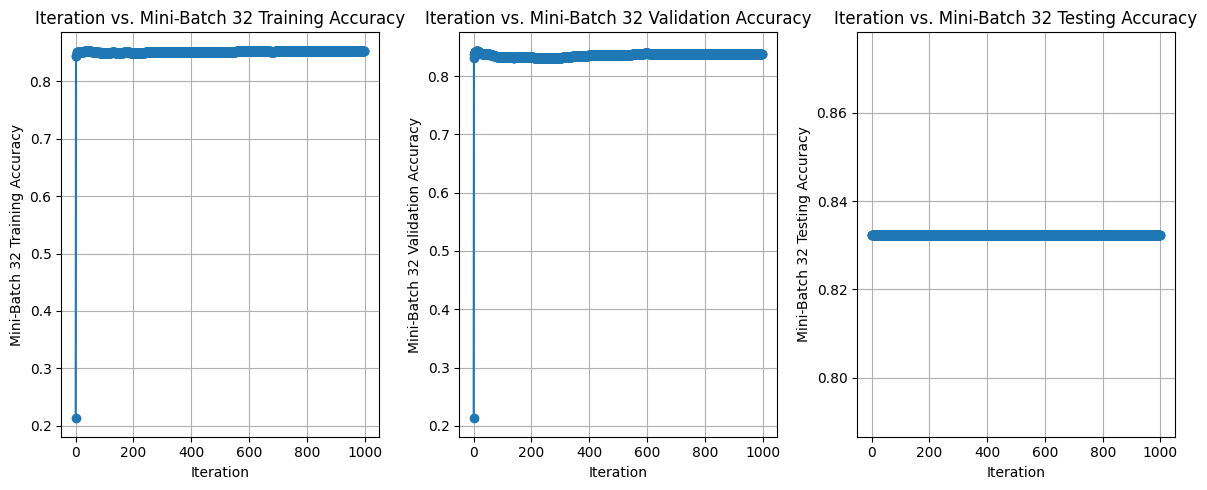

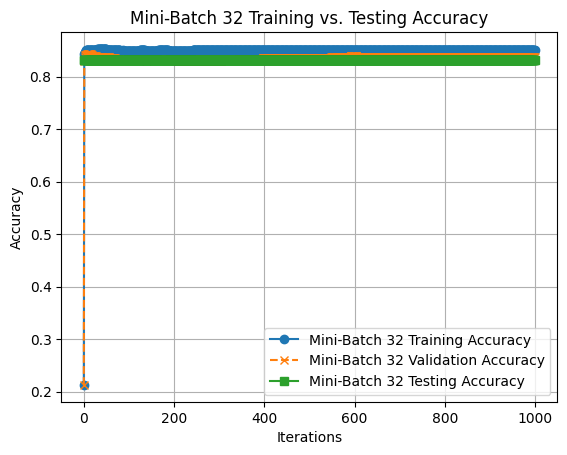

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 2 columns

# Iteration vs. Mini-Batch Training Loss (32)
axes[0].plot(range(len(miniBatch32TrainingLoss)), miniBatch32TrainingLoss, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Mini-Batch 32 Training Loss')
axes[0].set_title('Iteration vs. Mini-Batch 32 Training Loss')
axes[0].grid(True)

# Iteration vs. Mini-Batch Validation Loss (32)
axes[1].plot(range(len(miniBatch32ValidationLoss)), miniBatch32ValidationLoss, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mini-Batch 32 Validation Loss')
axes[1].set_title('Iteration vs. Mini-Batch 32 Validation Loss')
axes[1].grid(True)

# Iteration vs. Mini-Batch Validation Loss (32)
axes[2].plot(range(len(miniBatch32TestingLoss)), miniBatch32TestingLoss, marker='o', linestyle='-')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Mini-Batch 32 Testing Loss')
axes[2].set_title('Iteration vs. Mini-Batch 32 Testing Loss')
axes[2].grid(True)


plt.tight_layout()
plt.show()

# Mini-Batch 32 Training Loss vs. Mini-Batch 32 Validation Loss
plt.plot(range(len(miniBatch32TrainingLoss)), miniBatch32TrainingLoss, marker='o', linestyle='-', label='Mini-Batch 32 Training Loss')
plt.plot(range(len(miniBatch32ValidationLoss)), miniBatch32ValidationLoss, marker='x', linestyle='--', label='Mini-Batch 32 Validation Loss')
plt.plot(range(len(miniBatch32TestingLoss)), miniBatch32TestingLoss, marker='s', linestyle='-', label='Mini-Batch 32 Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Mini-Batch 32 Training vs. Validation Loss vs. Testing Loss')
plt.grid(True)
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 2 columns

# Iteration vs. Mini-Batch Training Accuracy (32)
axes[0].plot(range(len(miniBatch32TrainingAccuracy)), miniBatch32TrainingAccuracy, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Mini-Batch 32 Training Accuracy')
axes[0].set_title('Iteration vs. Mini-Batch 32 Training Accuracy')
axes[0].grid(True)

# Iteration vs. Mini-Batch Validation Accuracy (32)
axes[1].plot(range(len(miniBatch32ValidationAccuracy)), miniBatch32ValidationAccuracy, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mini-Batch 32 Validation Accuracy')
axes[1].set_title('Iteration vs. Mini-Batch 32 Validation Accuracy')
axes[1].grid(True)

# Iteration vs. Mini-Batch Testing Accuracy (32)
axes[2].plot(range(len(miniBatch32TestingAccuracy)), miniBatch32TestingAccuracy, marker='o', linestyle='-')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Mini-Batch 32 Testing Accuracy')
axes[2].set_title('Iteration vs. Mini-Batch 32 Testing Accuracy')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Mini-Batch 32 Training Accuracy vs. Mini-Batch 32 Validation Accuracy
plt.plot(range(len(miniBatch32TrainingAccuracy)), miniBatch32TrainingAccuracy, marker='o', linestyle='-', label='Mini-Batch 32 Training Accuracy')
plt.plot(range(len(miniBatch32ValidationAccuracy)), miniBatch32ValidationAccuracy, marker='x', linestyle='--', label='Mini-Batch 32 Validation Accuracy')
plt.plot(range(len(miniBatch32TestingAccuracy)), miniBatch32TestingAccuracy, marker='s', linestyle='-', label='Mini-Batch 32 Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Mini-Batch 32 Training vs. Testing Accuracy')
plt.grid(True)
plt.legend()
plt.show()

### **Mini-Batch Gradient Descent [batchSize = 64]**

In [19]:
learningRate = 0.05
iterations = 1000
countFeatures = len(xTraining[0])
batchSize = 64

miniBatch64Parameters = np.ones(countFeatures)
miniBatch64TrainingLoss = np.empty(iterations)
miniBatch64ValidationLoss = np.empty(iterations)
miniBatch64TrainingAccuracy = np.empty(iterations)
miniBatch64ValidationAccuracy = np.empty(iterations)

miniBatch64TestingLoss = np.empty(iterations)
miniBatch64TestingAccuracy = np.empty(iterations)

for iteration in range(0, iterations):
    miniBatch64Parameters = miniBatchGradientDescent(learningRate, 1, xTraining, yTraining, miniBatch64Parameters, sigmoid, batchSize)
    (miniBatch64TrainingLoss[iteration], miniBatch64ValidationLoss[iteration]) = calculateLoss(xTraining, yTraining, xValidation, yValidation, miniBatch64Parameters)
    (miniBatch64TrainingAccuracy[iteration], miniBatch64ValidationAccuracy[iteration]) = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, miniBatch64Parameters)

    miniBatch64TestingLoss[iteration] = costFunctionLogisticRegression(xTesting, yTesting, parameters)
    miniBatch64TestingPredictions = (sigmoid(xTesting, parameters) >= 0.5).astype(int)
    miniBatch64TestingAccuracy[iteration] = np.mean(miniBatch64TestingPredictions == yTesting)

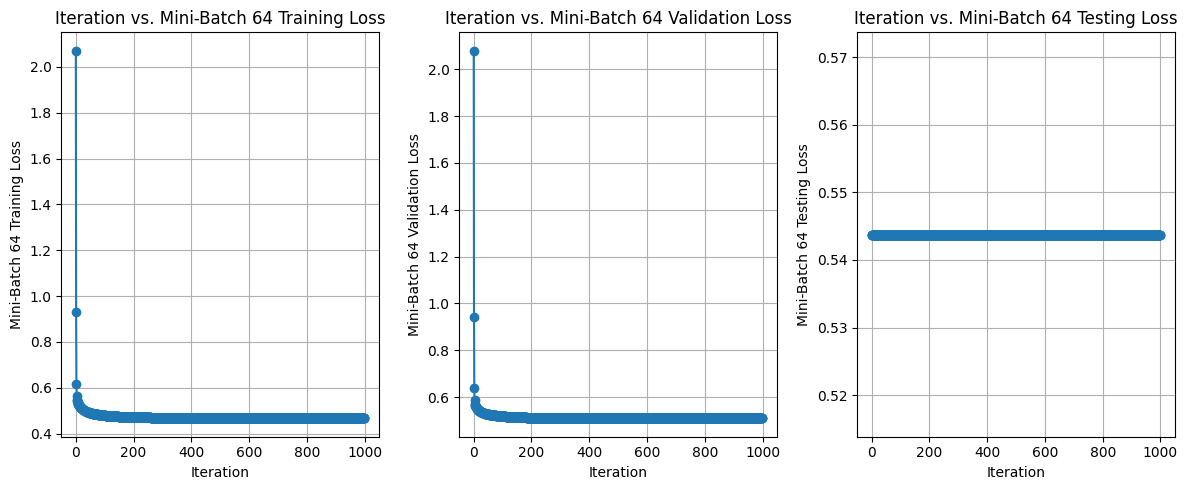

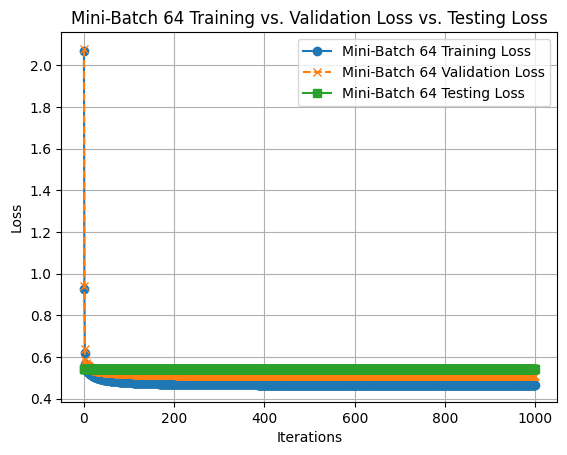

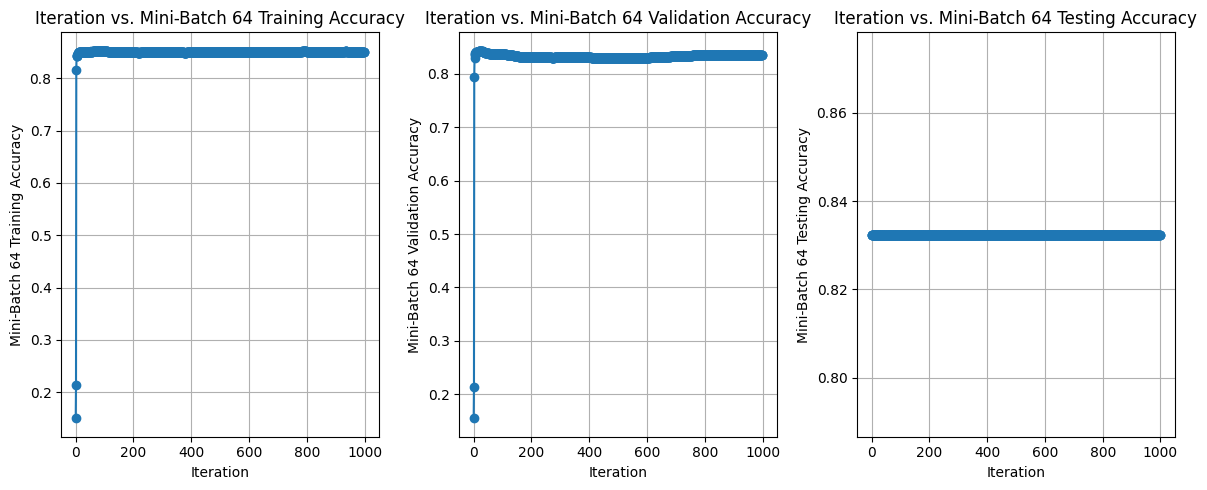

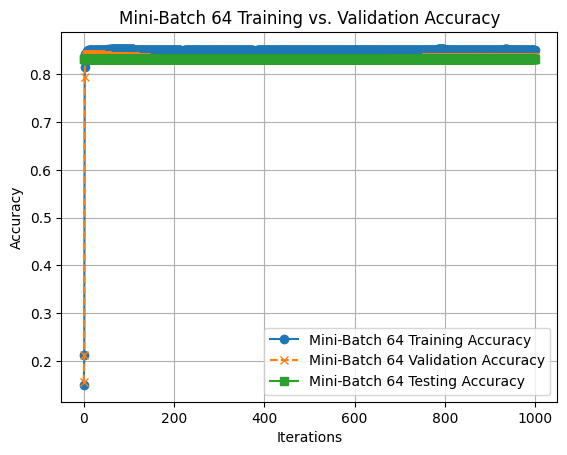

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 2 columns

# Iteration vs. Mini-Batch Training Loss (64)
axes[0].plot(range(len(miniBatch64TrainingLoss)), miniBatch64TrainingLoss, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Mini-Batch 64 Training Loss')
axes[0].set_title('Iteration vs. Mini-Batch 64 Training Loss')
axes[0].grid(True)

# Iteration vs. Mini-Batch Validation Loss (64)
axes[1].plot(range(len(miniBatch64ValidationLoss)), miniBatch64ValidationLoss, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mini-Batch 64 Validation Loss')
axes[1].set_title('Iteration vs. Mini-Batch 64 Validation Loss')
axes[1].grid(True)

# Iteration vs. Mini-Batch Testing Loss (64)
axes[2].plot(range(len(miniBatch64TestingLoss)), miniBatch64TestingLoss, marker='o', linestyle='-')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Mini-Batch 64 Testing Loss')
axes[2].set_title('Iteration vs. Mini-Batch 64 Testing Loss')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Mini-Batch 64 Training Loss vs. Mini-Batch 64 Validation Loss
plt.plot(range(len(miniBatch64TrainingLoss)), miniBatch64TrainingLoss, marker='o', linestyle='-', label='Mini-Batch 64 Training Loss')
plt.plot(range(len(miniBatch64ValidationLoss)), miniBatch64ValidationLoss, marker='x', linestyle='--', label='Mini-Batch 64 Validation Loss')
plt.plot(range(len(miniBatch64TestingLoss)), miniBatch64TestingLoss, marker='s', linestyle='-', label='Mini-Batch 64 Testing Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Mini-Batch 64 Training vs. Validation Loss vs. Testing Loss')
plt.grid(True)
plt.legend()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 5))  # 1 row, 2 columns

# Iteration vs. Mini-Batch Training Accuracy (64)
axes[0].plot(range(len(miniBatch64TrainingAccuracy)), miniBatch64TrainingAccuracy, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Mini-Batch 64 Training Accuracy')
axes[0].set_title('Iteration vs. Mini-Batch 64 Training Accuracy')
axes[0].grid(True)

# Iteration vs. Mini-Batch Validation Accuracy (64)
axes[1].plot(range(len(miniBatch64ValidationAccuracy)), miniBatch64ValidationAccuracy, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mini-Batch 64 Validation Accuracy')
axes[1].set_title('Iteration vs. Mini-Batch 64 Validation Accuracy')
axes[1].grid(True)

# Iteration vs. Mini-Batch Testing Accuracy (64)
axes[2].plot(range(len(miniBatch64TestingAccuracy)), miniBatch64TestingAccuracy, marker='o', linestyle='-')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Mini-Batch 64 Testing Accuracy')
axes[2].set_title('Iteration vs. Mini-Batch 64 Testing Accuracy')
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Mini-Batch 64 Training Accuracy vs. Mini-Batch 64 Validation Accuracy
plt.plot(range(len(miniBatch64TrainingAccuracy)), miniBatch64TrainingAccuracy, marker='o', linestyle='-', label='Mini-Batch 64 Training Accuracy')
plt.plot(range(len(miniBatch64ValidationAccuracy)), miniBatch64ValidationAccuracy, marker='x', linestyle='--', label='Mini-Batch 64 Validation Accuracy')
plt.plot(range(len(miniBatch64TestingAccuracy)), miniBatch64TestingAccuracy, marker='s', linestyle='-', label='Mini-Batch 64 Testing Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Mini-Batch 64 Training vs. Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

### **The trade-offs in terms of convergence speed and stability between these methods.**

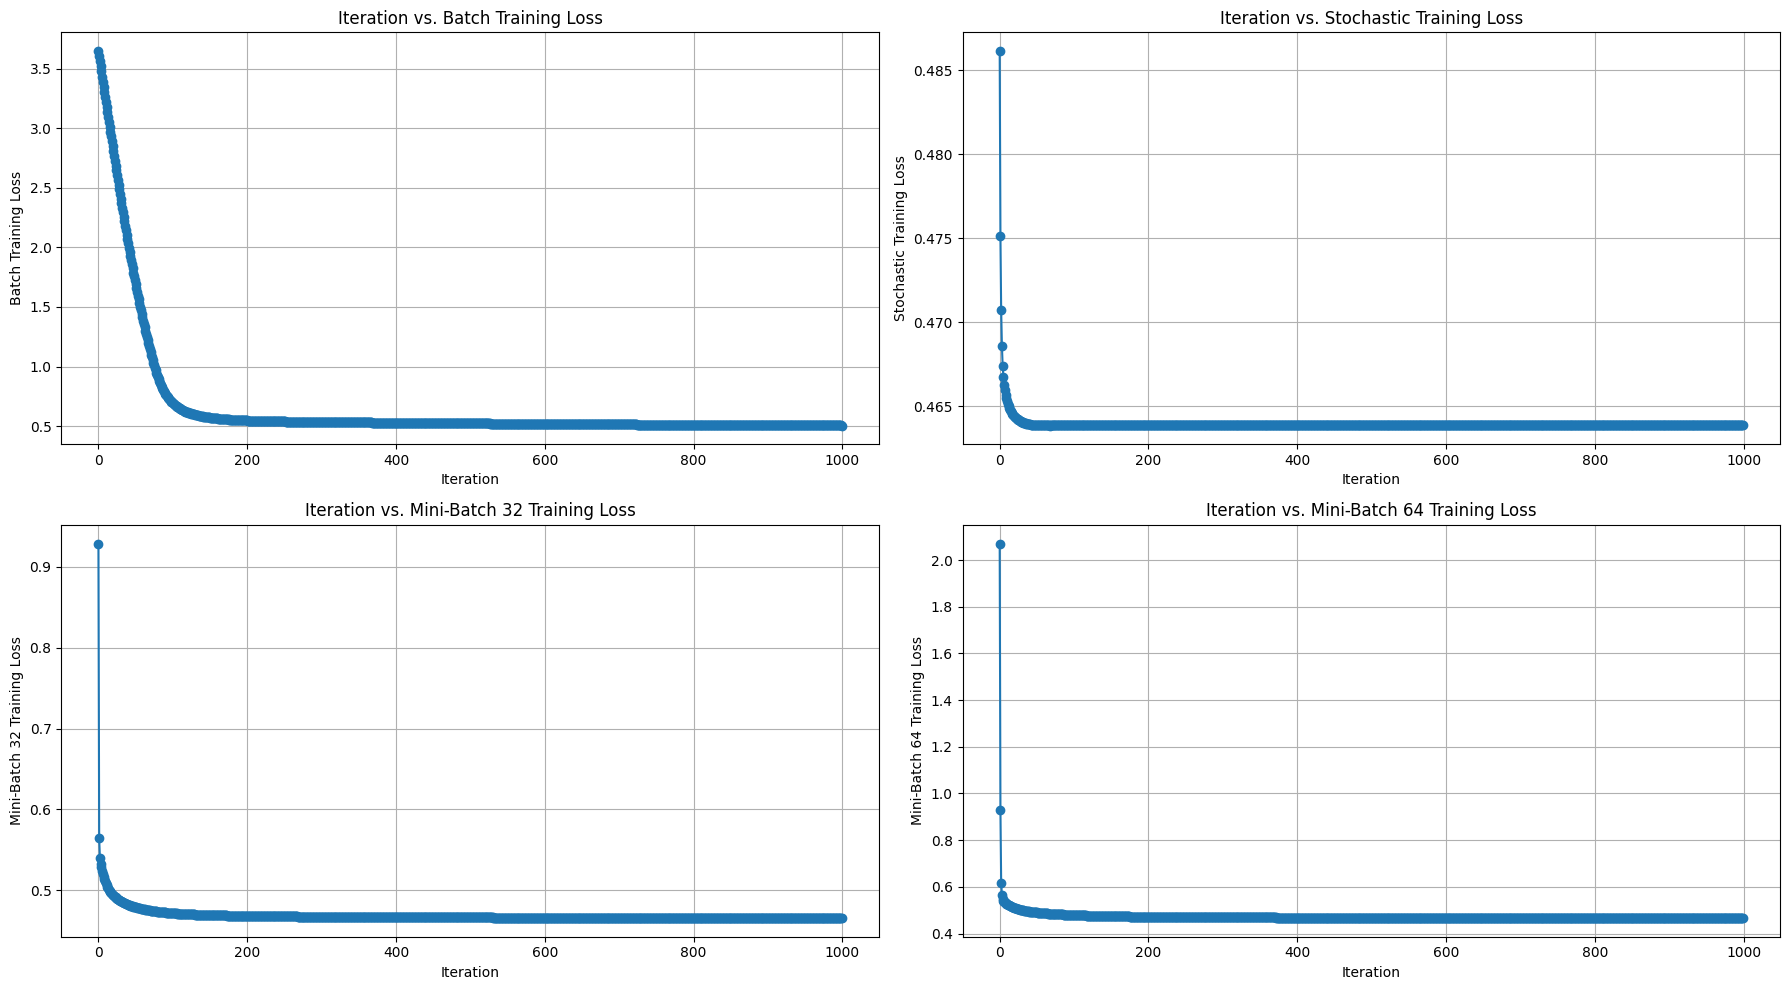

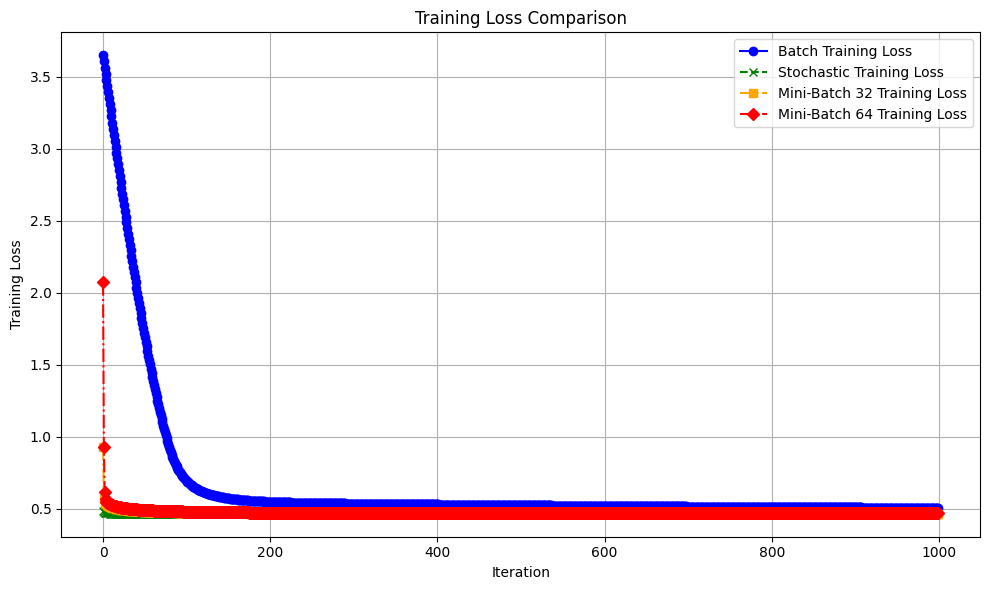

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Iteration vs. Batch Training Loss
axes[0, 0].plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Batch Training Loss')
axes[0, 0].set_title('Iteration vs. Batch Training Loss')
axes[0, 0].grid(True)

# Iteration vs. Stochastic Training Loss
axes[0, 1].plot(range(len(stochasticTrainingLoss)), stochasticTrainingLoss, marker='o', linestyle='-')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Stochastic Training Loss')
axes[0, 1].set_title('Iteration vs. Stochastic Training Loss')
axes[0, 1].grid(True)

# Iteration vs. Mini-Batch Training Loss (32)
axes[1, 0].plot(range(len(miniBatch32TrainingLoss)), miniBatch32TrainingLoss, marker='o', linestyle='-')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mini-Batch 32 Training Loss')
axes[1, 0].set_title('Iteration vs. Mini-Batch 32 Training Loss')
axes[1, 0].grid(True)

# Iteration vs. Mini-Batch Training Loss (64)
axes[1, 1].plot(range(len(miniBatch64TrainingLoss)), miniBatch64TrainingLoss, marker='o', linestyle='-')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Mini-Batch 64 Training Loss')
axes[1, 1].set_title('Iteration vs. Mini-Batch 64 Training Loss')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Plotting multiple lines on a single plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-', label='Batch Training Loss', color='blue')
plt.plot(range(len(stochasticTrainingLoss)), stochasticTrainingLoss, marker='x', linestyle='--', label='Stochastic Training Loss', color='green')
plt.plot(range(len(miniBatch32TrainingLoss)), miniBatch32TrainingLoss, marker='s', linestyle='-.', label='Mini-Batch 32 Training Loss', color='orange')
plt.plot(range(len(miniBatch64TrainingLoss)), miniBatch64TrainingLoss, marker='D', linestyle='-.', label='Mini-Batch 64 Training Loss', color='red')

plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


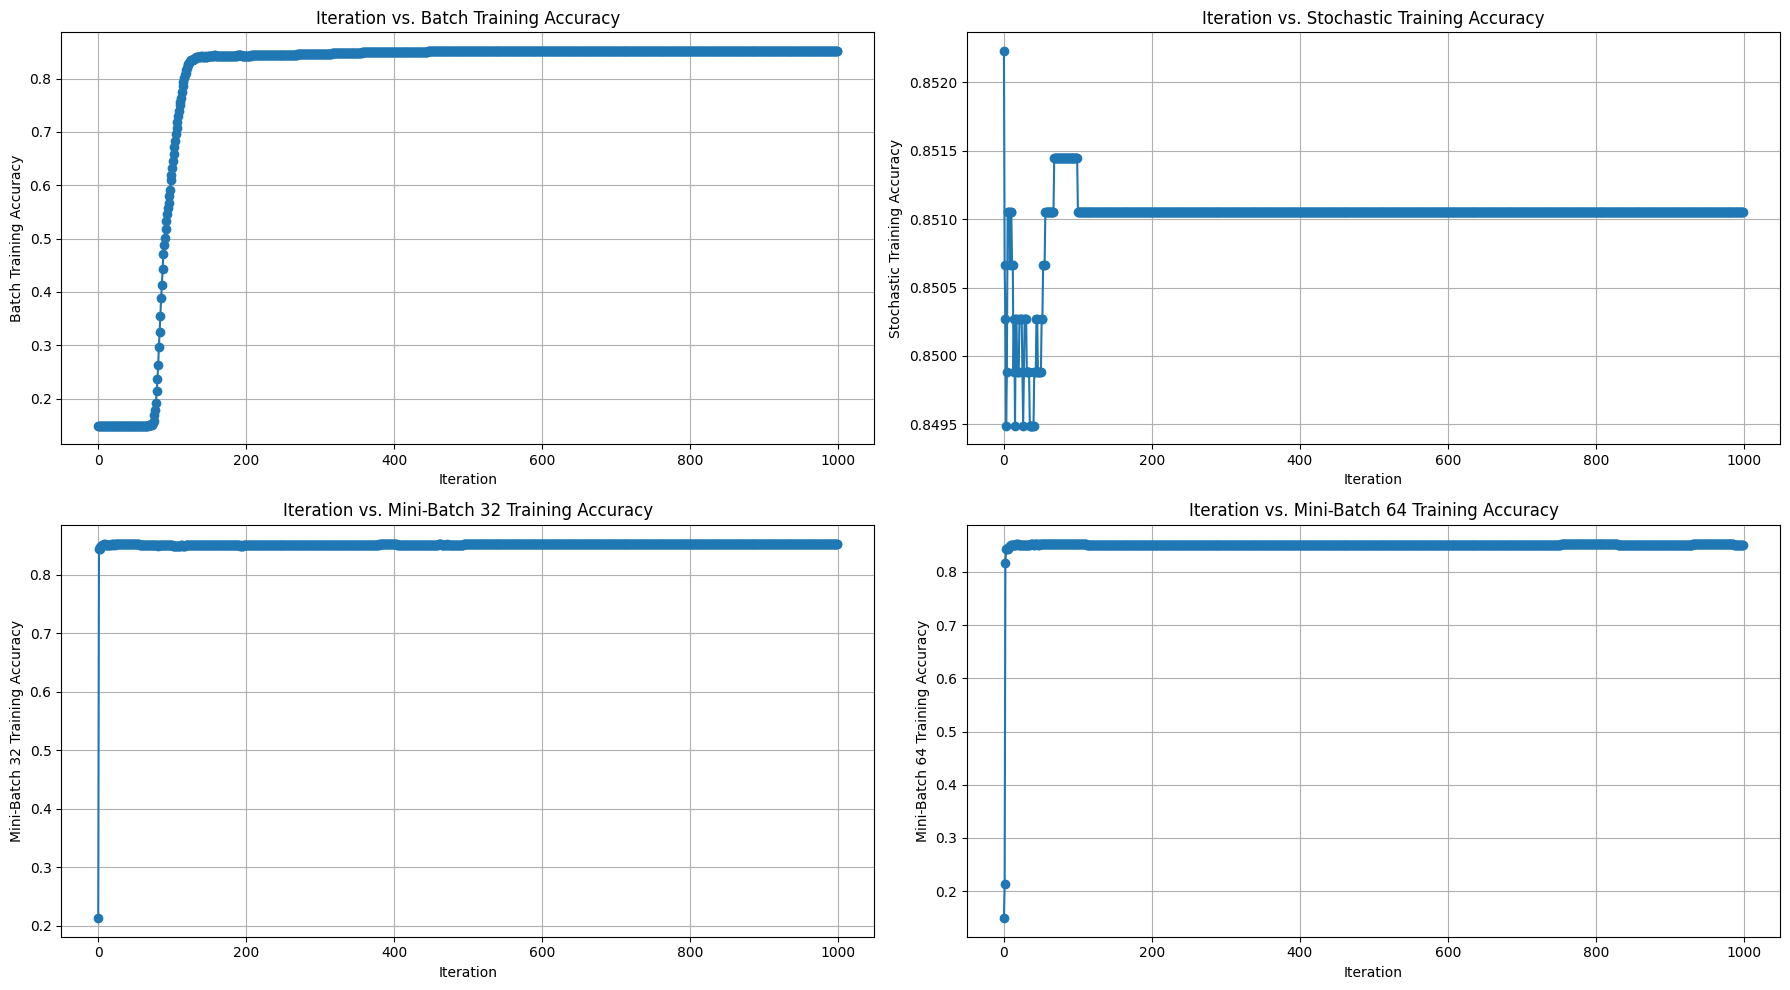

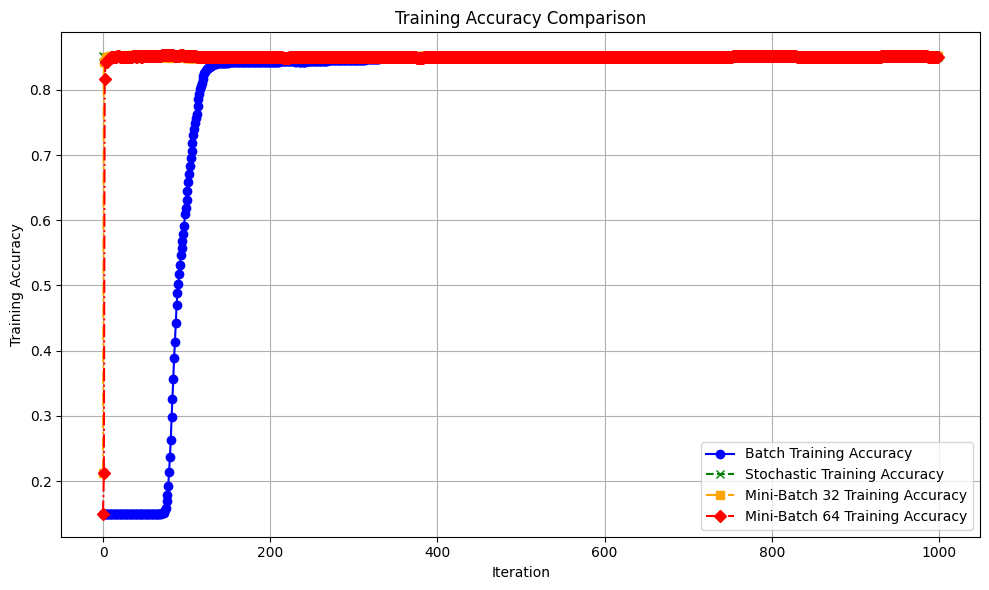

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Iteration vs. Batch Training Accuracy
axes[0, 0].plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Batch Training Accuracy')
axes[0, 0].set_title('Iteration vs. Batch Training Accuracy')
axes[0, 0].grid(True)

# Iteration vs. Stochastic Training Accuracy
axes[0, 1].plot(range(len(stochasticTrainingAccuracy)), stochasticTrainingAccuracy, marker='o', linestyle='-')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Stochastic Training Accuracy')
axes[0, 1].set_title('Iteration vs. Stochastic Training Accuracy')
axes[0, 1].grid(True)

# Iteration vs. Mini-Batch Training Accuracy (32)
axes[1, 0].plot(range(len(miniBatch32TrainingAccuracy)), miniBatch32TrainingAccuracy, marker='o', linestyle='-')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mini-Batch 32 Training Accuracy')
axes[1, 0].set_title('Iteration vs. Mini-Batch 32 Training Accuracy')
axes[1, 0].grid(True)

# Iteration vs. Mini-Batch Training Accuracy (64)
axes[1, 1].plot(range(len(miniBatch64TrainingAccuracy)), miniBatch64TrainingAccuracy, marker='o', linestyle='-')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Mini-Batch 64 Training Accuracy')
axes[1, 1].set_title('Iteration vs. Mini-Batch 64 Training Accuracy')
axes[1, 1].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Plotting multiple lines on a single plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-', label='Batch Training Accuracy', color='blue')
plt.plot(range(len(stochasticTrainingAccuracy)), stochasticTrainingAccuracy, marker='x', linestyle='--', label='Stochastic Training Accuracy', color='green')
plt.plot(range(len(miniBatch32TrainingAccuracy)), miniBatch32TrainingAccuracy, marker='s', linestyle='-.', label='Mini-Batch 32 Training Accuracy', color='orange')
plt.plot(range(len(miniBatch64TrainingAccuracy)), miniBatch64TrainingAccuracy, marker='D', linestyle='-.', label='Mini-Batch 64 Training Accuracy', color='red')

plt.xlabel('Iteration')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


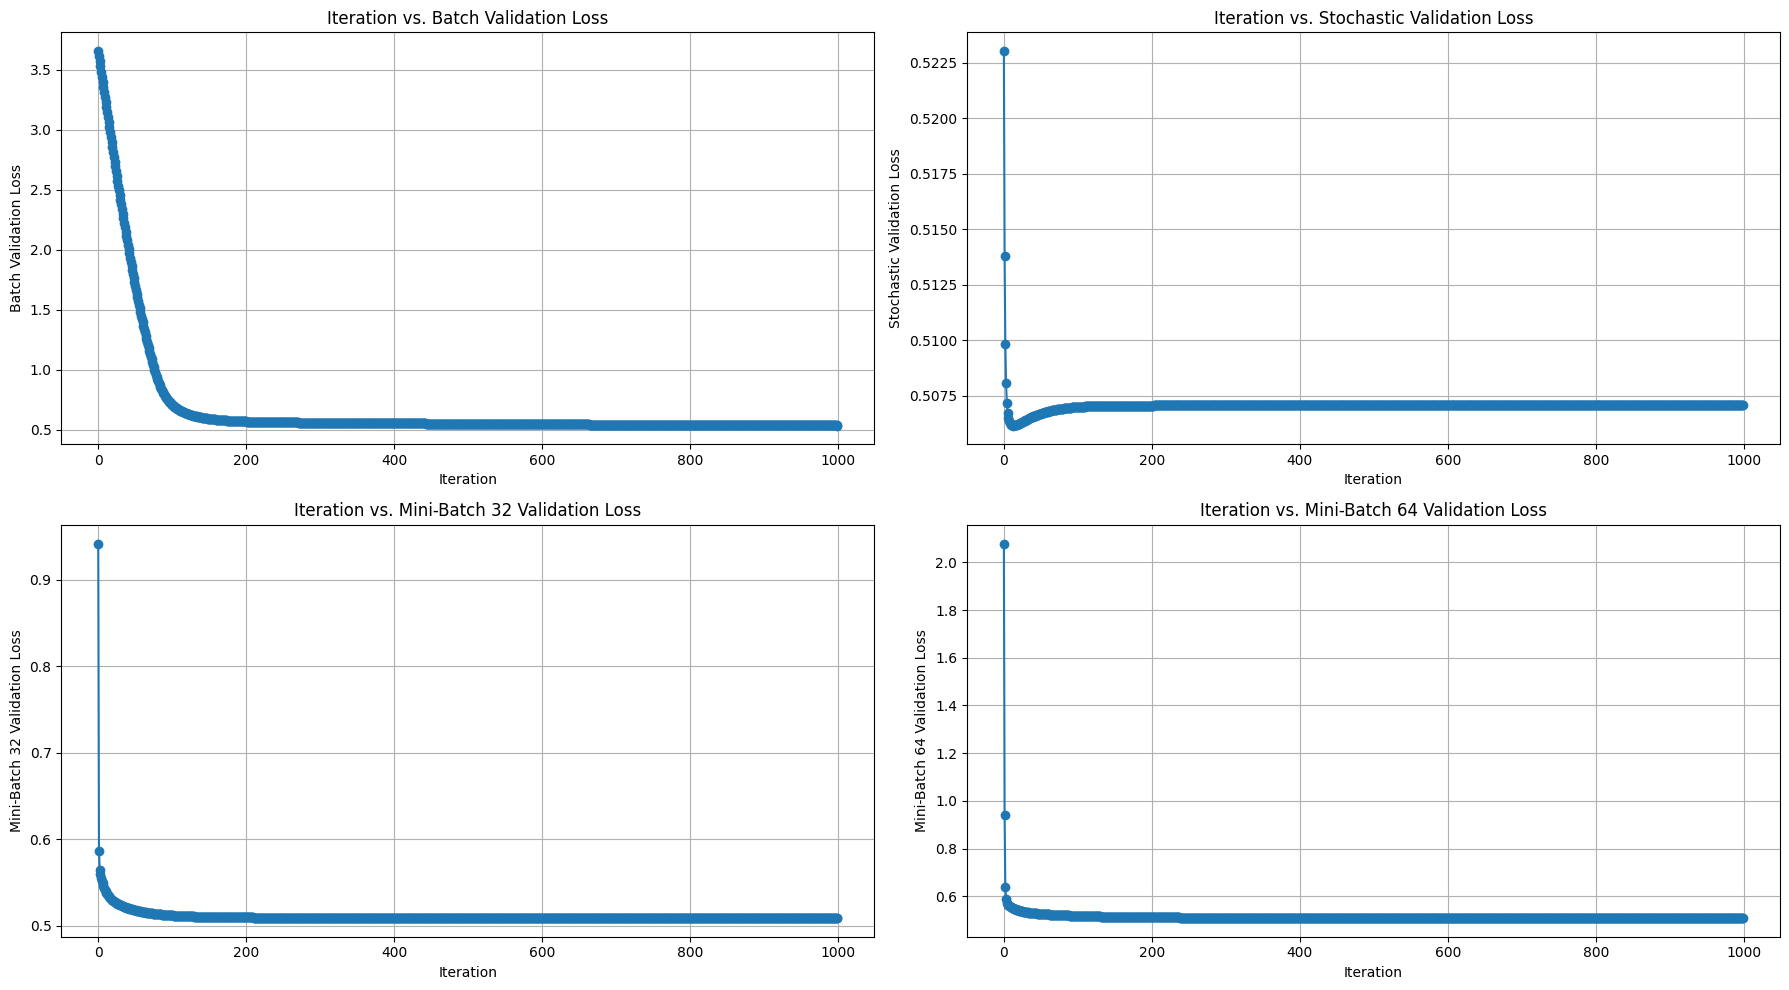

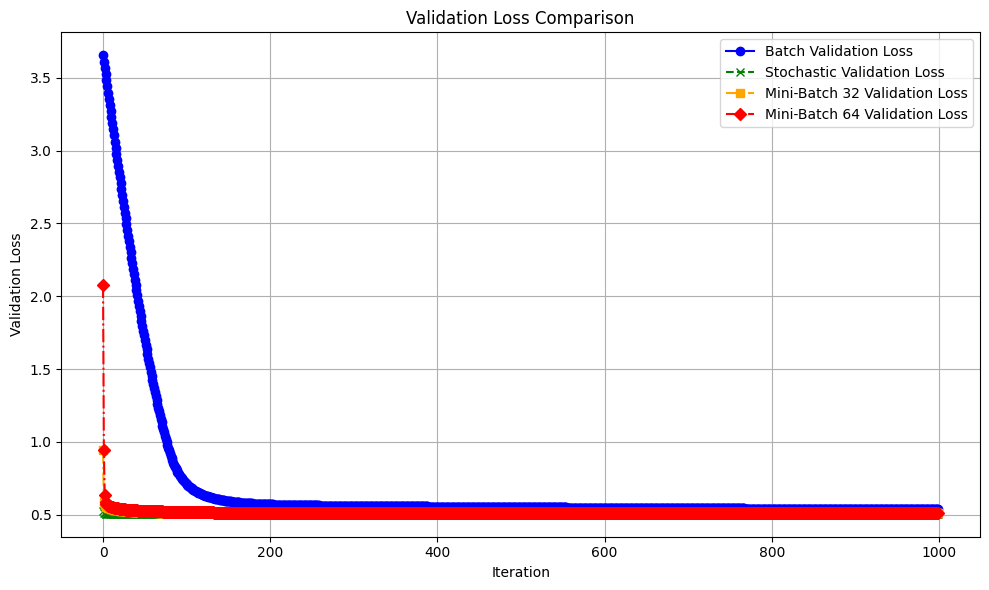

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Iteration vs. Batch Validation Loss
axes[0, 0].plot(range(len(validationLoss)), validationLoss, marker='o', linestyle='-')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Batch Validation Loss')
axes[0, 0].set_title('Iteration vs. Batch Validation Loss')
axes[0, 0].grid(True)

# Iteration vs. Stochastic Validation Loss
axes[0, 1].plot(range(len(stochasticValidationLoss)), stochasticValidationLoss, marker='o', linestyle='-')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Stochastic Validation Loss')
axes[0, 1].set_title('Iteration vs. Stochastic Validation Loss')
axes[0, 1].grid(True)

# Iteration vs. Mini-Batch Validation Loss (32)
axes[1, 0].plot(range(len(miniBatch32ValidationLoss)), miniBatch32ValidationLoss, marker='o', linestyle='-')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mini-Batch 32 Validation Loss')
axes[1, 0].set_title('Iteration vs. Mini-Batch 32 Validation Loss')
axes[1, 0].grid(True)

# Iteration vs. Mini-Batch Validation Loss (64)
axes[1, 1].plot(range(len(miniBatch64ValidationLoss)), miniBatch64ValidationLoss, marker='o', linestyle='-')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Mini-Batch 64 Validation Loss')
axes[1, 1].set_title('Iteration vs. Mini-Batch 64 Validation Loss')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Plotting multiple lines on a single plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(validationLoss)), validationLoss, marker='o', linestyle='-', label='Batch Validation Loss', color='blue')
plt.plot(range(len(stochasticValidationLoss)), stochasticValidationLoss, marker='x', linestyle='--', label='Stochastic Validation Loss', color='green')
plt.plot(range(len(miniBatch32ValidationLoss)), miniBatch32ValidationLoss, marker='s', linestyle='-.', label='Mini-Batch 32 Validation Loss', color='orange')
plt.plot(range(len(miniBatch64ValidationLoss)), miniBatch64ValidationLoss, marker='D', linestyle='-.', label='Mini-Batch 64 Validation Loss', color='red')

plt.xlabel('Iteration')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

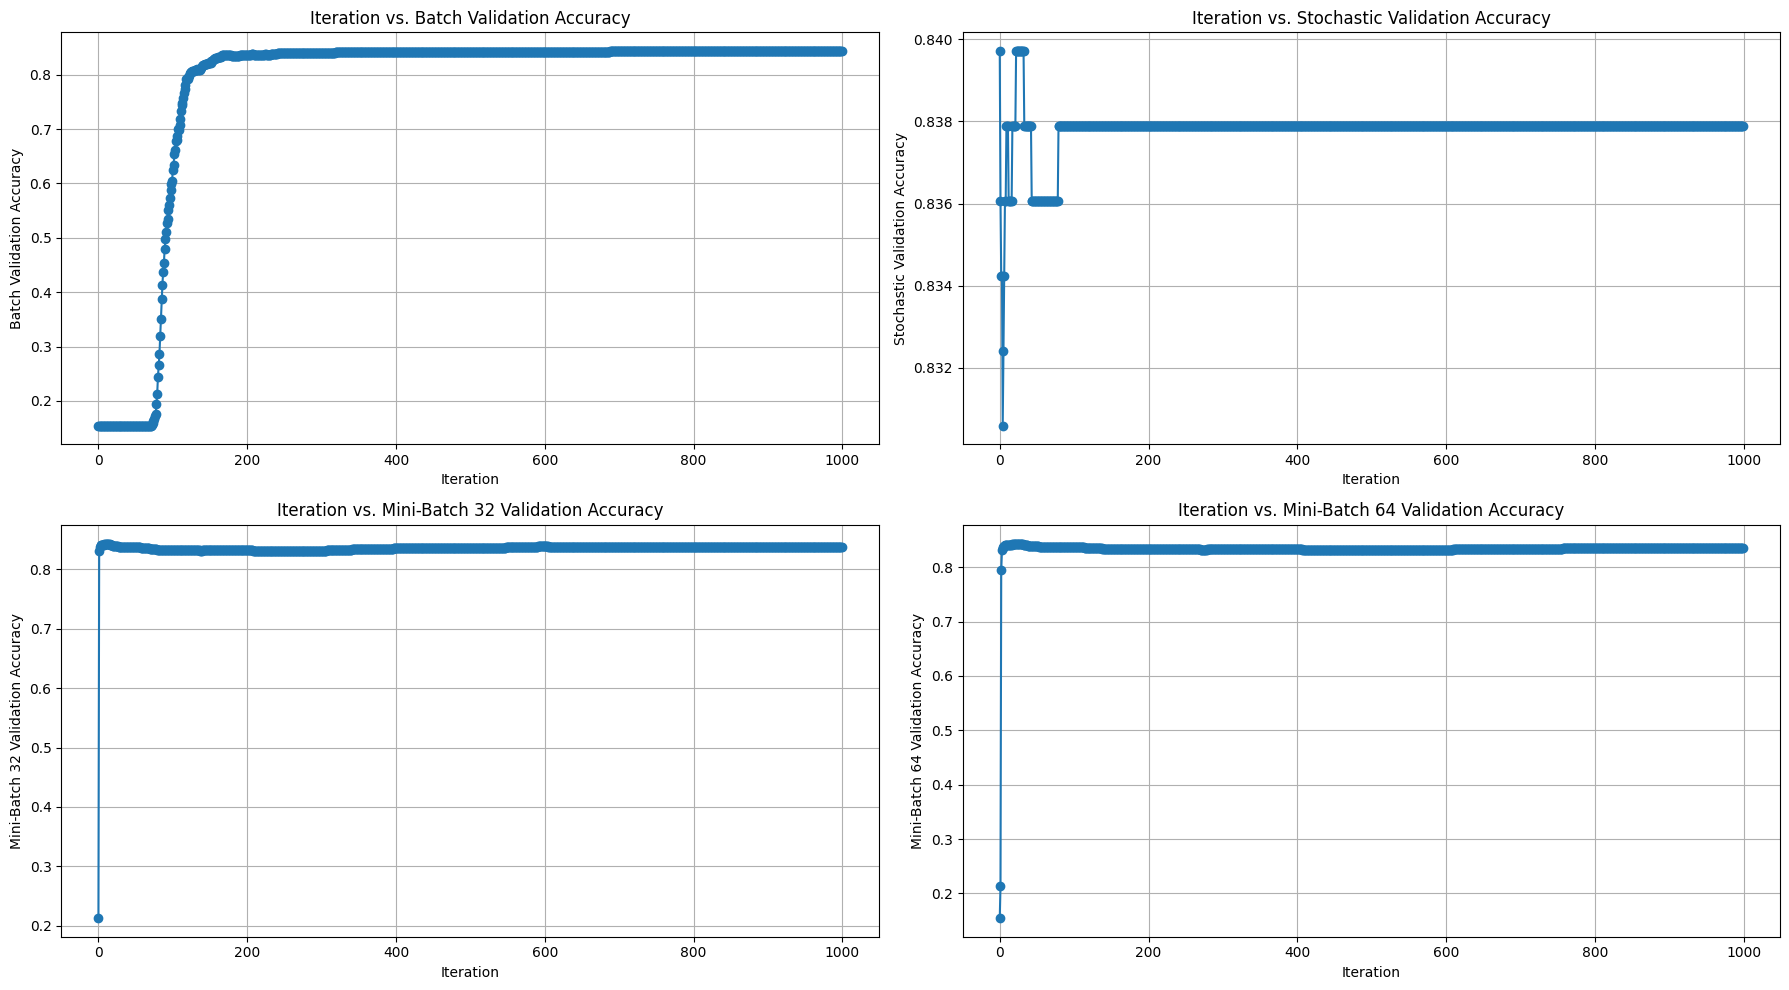

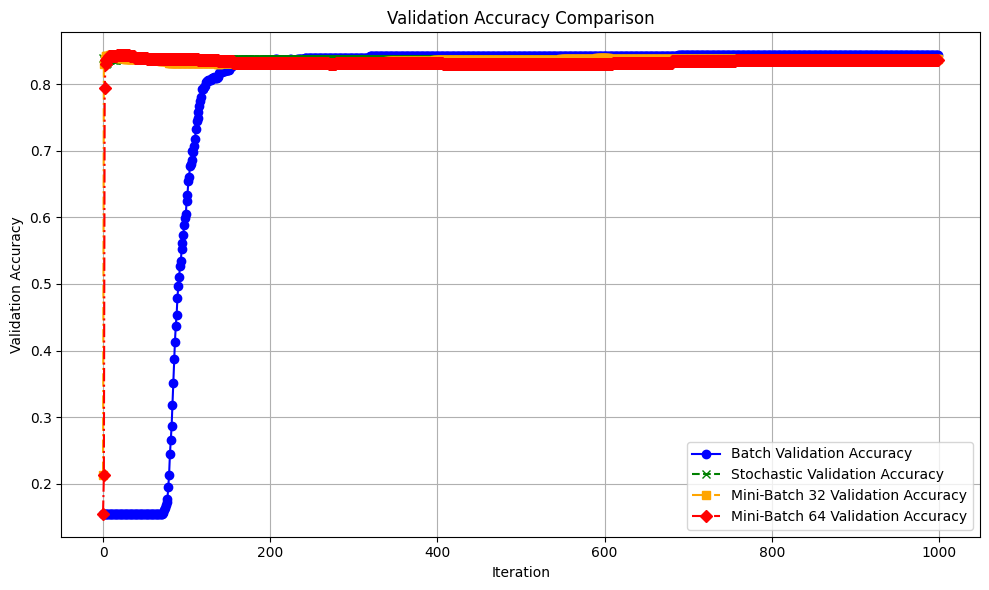

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Iteration vs. Batch Validation Accuracy
axes[0, 0].plot(range(len(validationAccuracy)), validationAccuracy, marker='o', linestyle='-')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Batch Validation Accuracy')
axes[0, 0].set_title('Iteration vs. Batch Validation Accuracy')
axes[0, 0].grid(True)

# Iteration vs. Stochastic Validation Accuracy
axes[0, 1].plot(range(len(stochasticValidationAccuracy)), stochasticValidationAccuracy, marker='o', linestyle='-')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Stochastic Validation Accuracy')
axes[0, 1].set_title('Iteration vs. Stochastic Validation Accuracy')
axes[0, 1].grid(True)

# Iteration vs. Mini-Batch Validation Accuracy (32)
axes[1, 0].plot(range(len(miniBatch32ValidationAccuracy)), miniBatch32ValidationAccuracy, marker='o', linestyle='-')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mini-Batch 32 Validation Accuracy')
axes[1, 0].set_title('Iteration vs. Mini-Batch 32 Validation Accuracy')
axes[1, 0].grid(True)

# Iteration vs. Mini-Batch Validation Accuracy (64)
axes[1, 1].plot(range(len(miniBatch64ValidationAccuracy)), miniBatch64ValidationAccuracy, marker='o', linestyle='-')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Mini-Batch 64 Validation Accuracy')
axes[1, 1].set_title('Iteration vs. Mini-Batch 64 Validation Accuracy')
axes[1, 1].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Plotting multiple lines on a single plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(validationAccuracy)), validationAccuracy, marker='o', linestyle='-', label='Batch Validation Accuracy', color='blue')
plt.plot(range(len(stochasticValidationAccuracy)), stochasticValidationAccuracy, marker='x', linestyle='--', label='Stochastic Validation Accuracy', color='green')
plt.plot(range(len(miniBatch32ValidationAccuracy)), miniBatch32ValidationAccuracy, marker='s', linestyle='-.', label='Mini-Batch 32 Validation Accuracy', color='orange')
plt.plot(range(len(miniBatch64ValidationAccuracy)), miniBatch64ValidationAccuracy, marker='D', linestyle='-.', label='Mini-Batch 64 Validation Accuracy', color='red')

plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

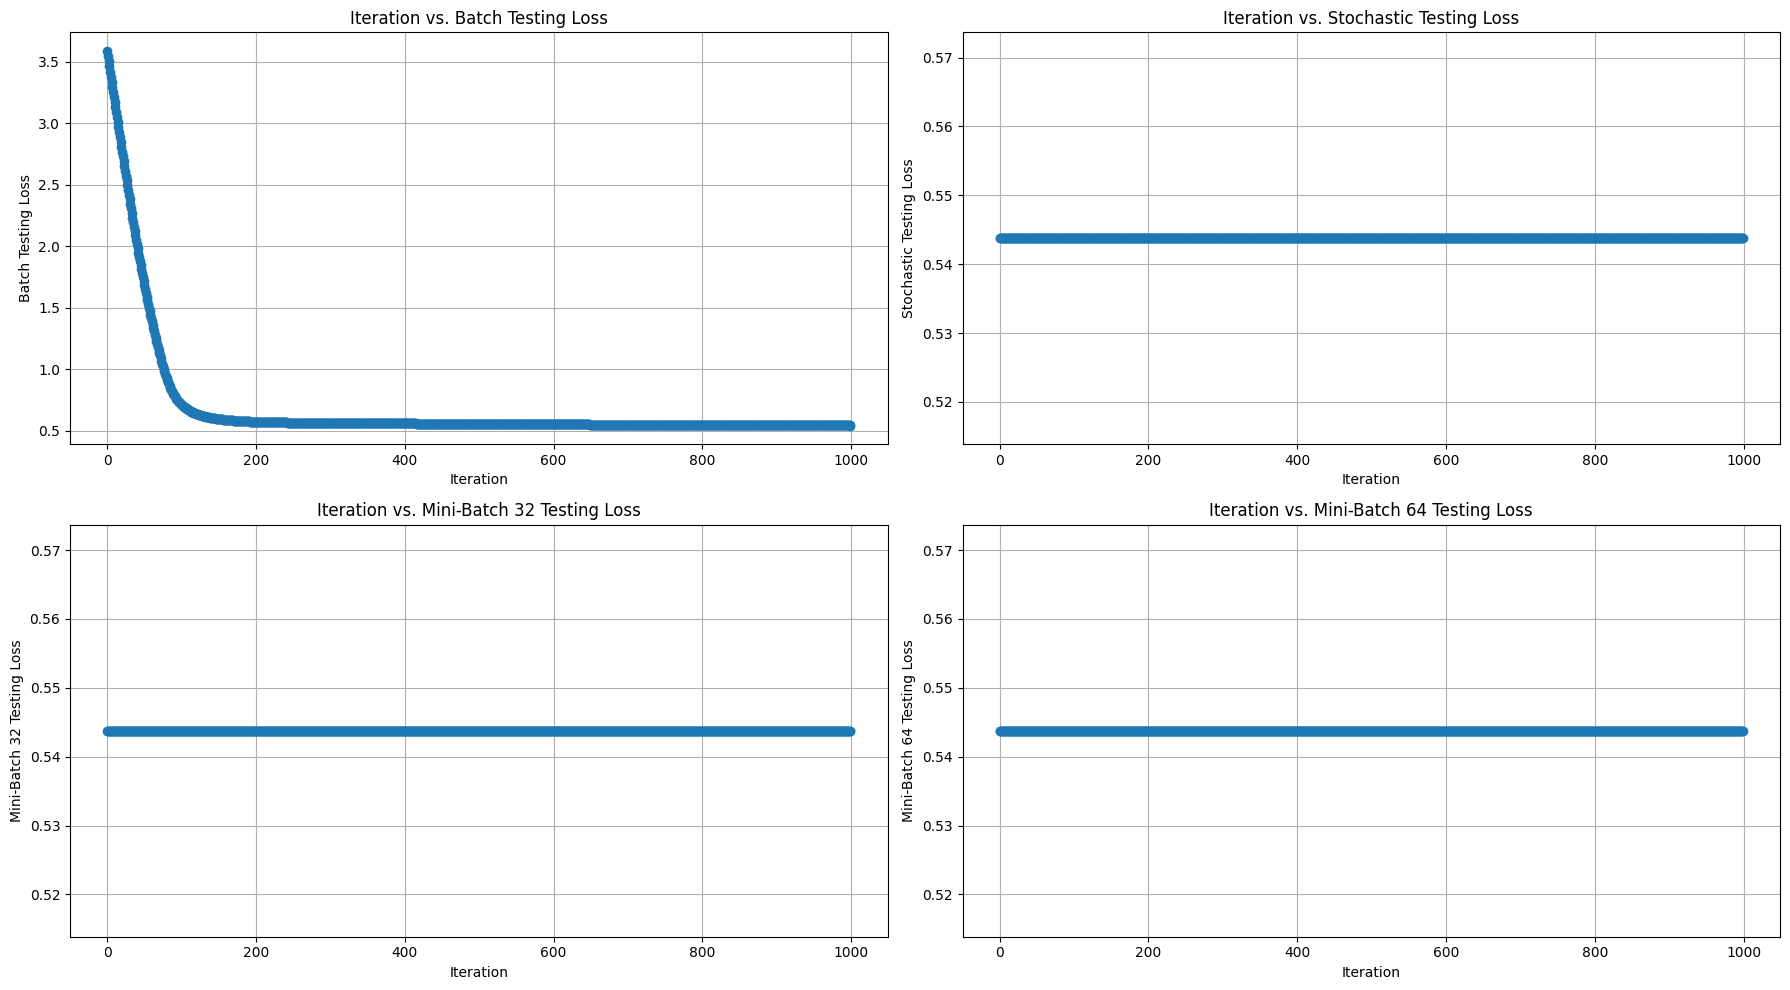

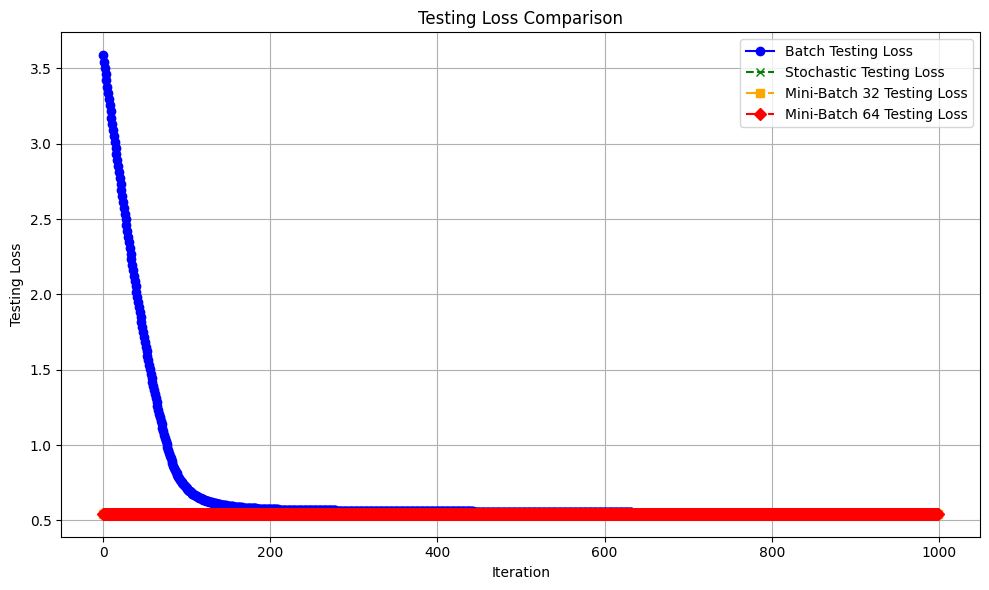

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Iteration vs. Batch Testing Loss
axes[0, 0].plot(range(len(testingLoss)), testingLoss, marker='o', linestyle='-')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Batch Testing Loss')
axes[0, 0].set_title('Iteration vs. Batch Testing Loss')
axes[0, 0].grid(True)

# Iteration vs. Stochastic Testing Loss
axes[0, 1].plot(range(len(stochasticTestingLoss)), stochasticTestingLoss, marker='o', linestyle='-')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Stochastic Testing Loss')
axes[0, 1].set_title('Iteration vs. Stochastic Testing Loss')
axes[0, 1].grid(True)

# Iteration vs. Mini-Batch Testing Loss (32)
axes[1, 0].plot(range(len(miniBatch32TestingLoss)), miniBatch32TestingLoss, marker='o', linestyle='-')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mini-Batch 32 Testing Loss')
axes[1, 0].set_title('Iteration vs. Mini-Batch 32 Testing Loss')
axes[1, 0].grid(True)

# Iteration vs. Mini-Batch Testing Loss (64)
axes[1, 1].plot(range(len(miniBatch64TestingLoss)), miniBatch64TestingLoss, marker='o', linestyle='-')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Mini-Batch 64 Testing Loss')
axes[1, 1].set_title('Iteration vs. Mini-Batch 64 Testing Loss')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Plotting multiple lines on a single plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(testingLoss)), testingLoss, marker='o', linestyle='-', label='Batch Testing Loss', color='blue')
plt.plot(range(len(stochasticTestingLoss)), stochasticTestingLoss, marker='x', linestyle='--', label='Stochastic Testing Loss', color='green')
plt.plot(range(len(miniBatch32TestingLoss)), miniBatch32TestingLoss, marker='s', linestyle='-.', label='Mini-Batch 32 Testing Loss', color='orange')
plt.plot(range(len(miniBatch64TestingLoss)), miniBatch64TestingLoss, marker='D', linestyle='-.', label='Mini-Batch 64 Testing Loss', color='red')

plt.xlabel('Iteration')
plt.ylabel('Testing Loss')
plt.title('Testing Loss Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


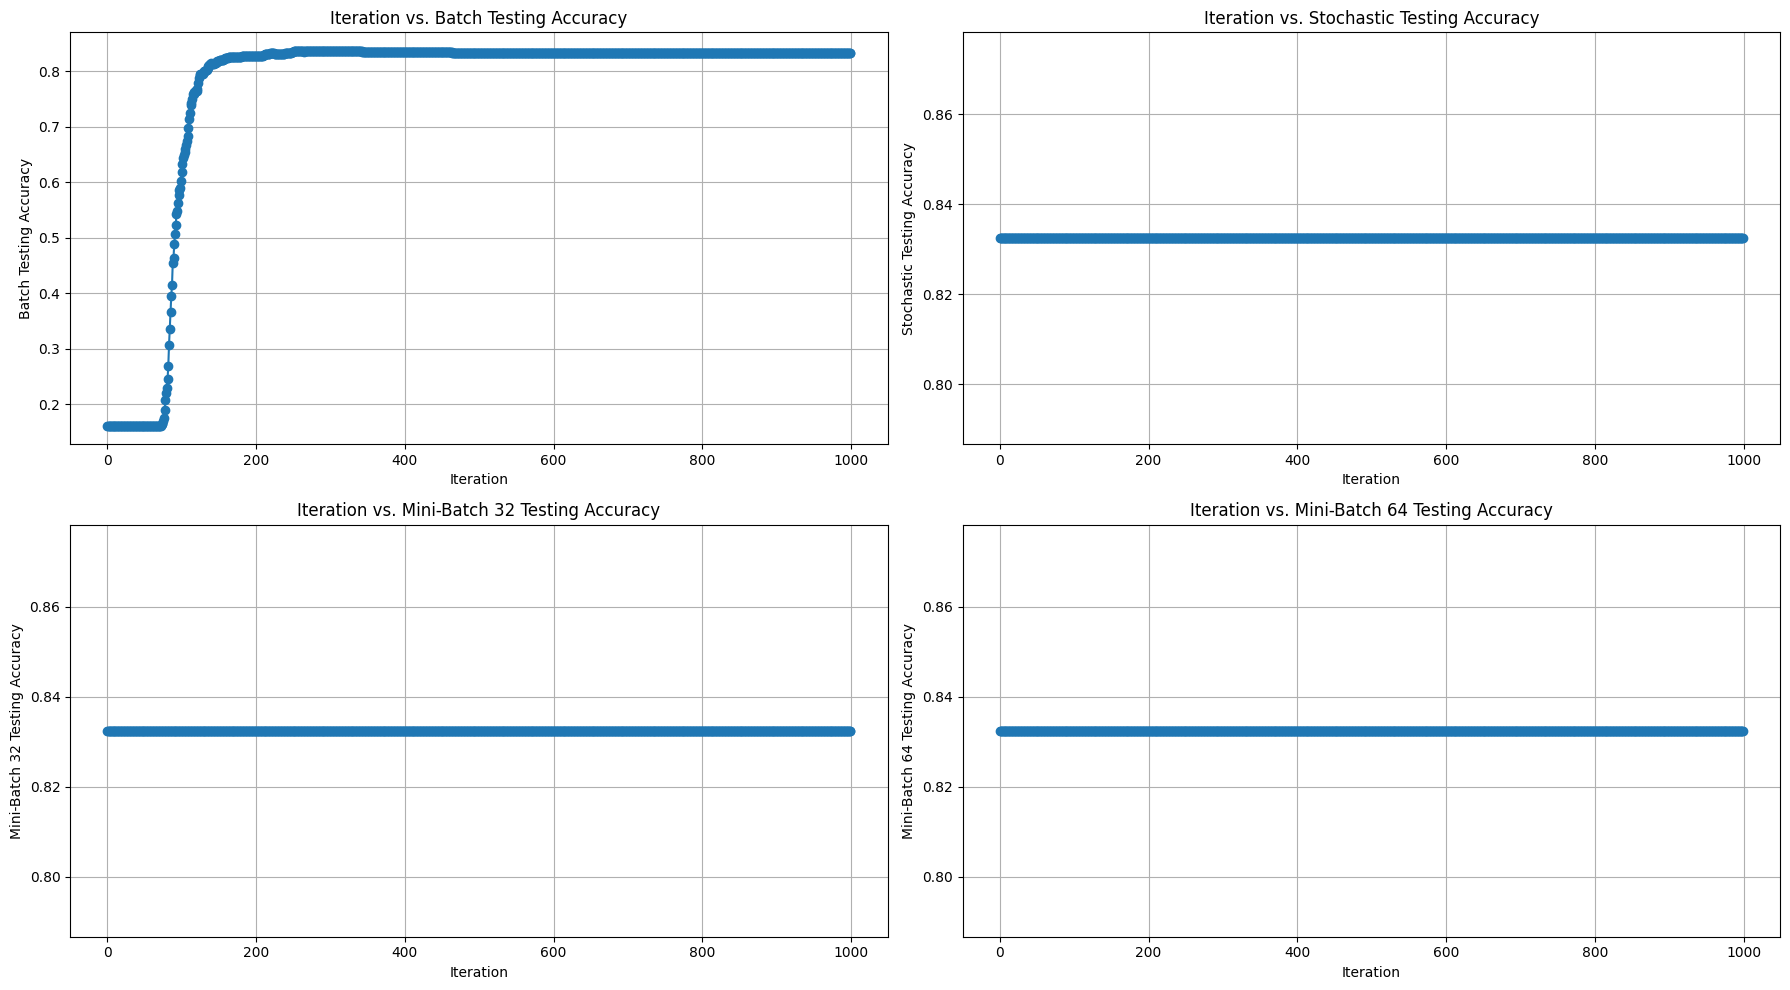

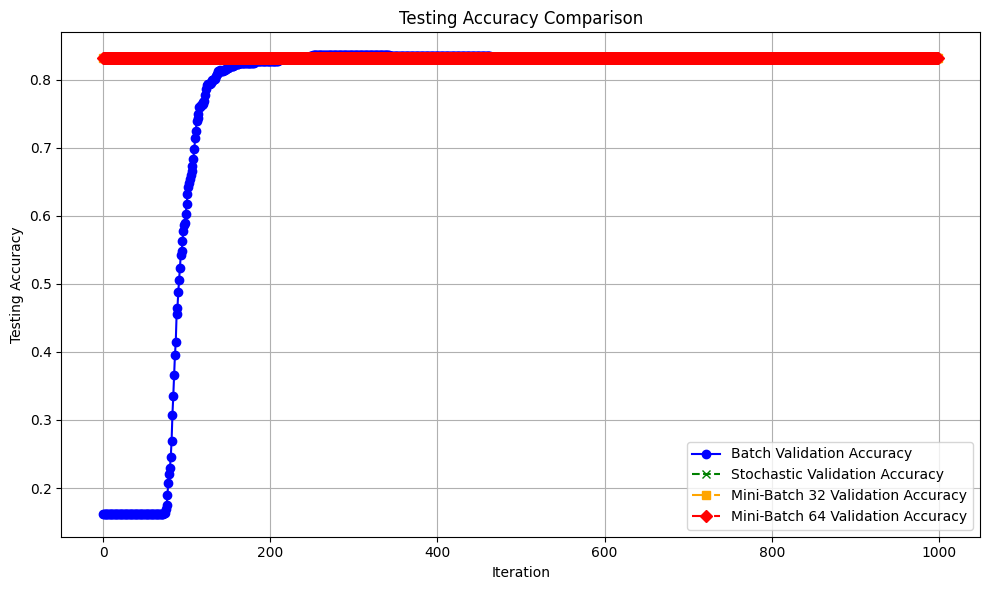

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Iteration vs. Batch Testing Accuracy
axes[0, 0].plot(range(len(testingAccuracy)), testingAccuracy, marker='o', linestyle='-')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Batch Testing Accuracy')
axes[0, 0].set_title('Iteration vs. Batch Testing Accuracy')
axes[0, 0].grid(True)

# Iteration vs. Stochastic Testing Accuracy
axes[0, 1].plot(range(len(stochasticTestingAccuracy)), stochasticTestingAccuracy, marker='o', linestyle='-')
axes[0, 1].set_xlabel('Iteration')
axes[0, 1].set_ylabel('Stochastic Testing Accuracy')
axes[0, 1].set_title('Iteration vs. Stochastic Testing Accuracy')
axes[0, 1].grid(True)

# Iteration vs. Mini-Batch Testing Accuracy (32)
axes[1, 0].plot(range(len(miniBatch32TestingAccuracy)), miniBatch32TestingAccuracy, marker='o', linestyle='-')
axes[1, 0].set_xlabel('Iteration')
axes[1, 0].set_ylabel('Mini-Batch 32 Testing Accuracy')
axes[1, 0].set_title('Iteration vs. Mini-Batch 32 Testing Accuracy')
axes[1, 0].grid(True)

# Iteration vs. Mini-Batch Testing Accuracy (64)
axes[1, 1].plot(range(len(miniBatch64TestingAccuracy)), miniBatch64TestingAccuracy, marker='o', linestyle='-')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Mini-Batch 64 Testing Accuracy')
axes[1, 1].set_title('Iteration vs. Mini-Batch 64 Testing Accuracy')
axes[1, 1].grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Plotting multiple lines on a single plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(testingAccuracy)), testingAccuracy, marker='o', linestyle='-', label='Batch Validation Accuracy', color='blue')
plt.plot(range(len(stochasticTestingAccuracy)), stochasticTestingAccuracy, marker='x', linestyle='--', label='Stochastic Validation Accuracy', color='green')
plt.plot(range(len(miniBatch32TestingAccuracy)), miniBatch32TestingAccuracy, marker='s', linestyle='-.', label='Mini-Batch 32 Validation Accuracy', color='orange')
plt.plot(range(len(miniBatch64TestingAccuracy)), miniBatch64TestingAccuracy, marker='D', linestyle='-.', label='Mini-Batch 64 Validation Accuracy', color='red')

plt.xlabel('Iteration')
plt.ylabel('Testing Accuracy')
plt.title('Testing Accuracy Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **(e) (2 marks) Implement k-fold cross-validation (with k=5) to assess the robustness of your model.**

In [27]:
dataframe = pd.read_csv("Heart Disease.csv")

rows_before = len(dataframe)
dataframe = dataframe.dropna()
rows_after = len(dataframe)
print(f"Before removing rows with NA values, the dataset had {rows_before} rows. After using dropna(), it now contains {rows_after} rows.\nThis means that {rows_before-rows_after} rows with missing values were removed.\n")

y = dataframe["HeartDisease"].values
dropColumns = ["HeartDisease"]
x = dataframe.drop(columns=dropColumns).values
x = np.insert(x, 0, 1, axis=1)
x = minMaxScaling(x)

Before removing rows with NA values, the dataset had 4238 rows. After using dropna(), it now contains 3656 rows.
This means that 582 rows with missing values were removed.



In [28]:
k = 5
foldSize = int(len(x)/k)

print(f"{k} folds and each fold of size {foldSize}\n")

accuracy = np.empty(k)
precision = np.empty(k)
recall = np.empty(k)
F1Scores = np.empty(k)

for fold in range(0,k):
    testStart = fold*foldSize
    testEnd = testStart + foldSize

    xTestingFold = x[testStart:testEnd]
    yTestingFold = y[testStart:testEnd]
    xTrainingFold = np.concatenate((x[:testStart], x[testEnd:]), axis=0)
    yTrainingFold = np.concatenate((y[:testStart], y[testEnd:]), axis=0)


    learningRate = 0.05
    iterations = 1000

    parameters = np.ones(countFeatures)
    for iteration in range(0,iterations):
        parameters = batchGradientDescent(learningRate, 1, xTrainingFold, yTrainingFold, parameters, sigmoid)

    predictions = np.empty(len(xTestingFold))
    probabilities = np.empty(len(xTestingFold))

    for sample in range(0,len(xTestingFold)):
        predictions[sample] = predictClass(xTestingFold[sample],parameters,sigmoid)
        probabilities[sample] = sigmoid(xTestingFold[sample],parameters)

    accuracy[fold] = np.mean(predictions == yTestingFold)
    precision[fold] = precision_score(yTestingFold, predictions)
    recall[fold] = recall_score(yTestingFold, predictions)
    F1Scores[fold] = f1_score(yTestingFold, predictions)

5 folds and each fold of size 731



In [29]:
accuracyMean = np.mean(accuracy)
accuracyStd = np.std(accuracy)
precisionMean = np.mean(precision)
precisionStd = np.std(precision)
recallMean = np.mean(recall)
recallStd = np.std(recall)
F1ScoreMean = np.mean(F1Scores)
F1ScoreStd = np.std(F1Scores)

print(f"Accuracy for each fold : {accuracy}")
print(f"Precision for each fold : {precision}")
print(f"Recall for each fold : {recall}")
print(f"F1 Score for each fold : {F1Scores}")
print()

print(f"Accuracy: Mean = {accuracyMean:.3f}, Std = {accuracyStd:.3f}")
print(f"Precision: Mean = {precisionMean:.3f}, Std = {precisionStd:.3f}")
print(f"Recall: Mean = {recallMean:.3f}, Std = {recallStd:.3f}")
print(f"F1 Score: Mean = {F1ScoreMean:.3f}, Std = {F1ScoreStd:.3f}")

Accuracy for each fold : [0.83310534 0.86867305 0.84404925 0.8495212  0.83994528]
Precision for each fold : [0.75       1.         0.         0.16666667 0.54545455]
Recall for each fold : [0.02419355 0.01030928 0.         0.00943396 0.05084746]
F1 Score for each fold : [0.046875   0.02040816 0.         0.01785714 0.09302326]

Accuracy: Mean = 0.847, Std = 0.012
Precision: Mean = 0.492, Std = 0.368
Recall: Mean = 0.019, Std = 0.018
F1 Score: Mean = 0.036, Std = 0.032


### **Stability**

Definition: Stability refers to how consistently the model performs across different folds of the dataset. A stable model will show similar performance metrics (e.g., accuracy, precision, recall, F1 score) across different folds. If the model's performance does not fluctuate dramatically between folds, it indicates high stability.

### **Variance**

Definition: Variance refers to the degree of fluctuation in the model's performance metrics across different folds. High variance indicates that the model's performance is highly sensitive to the specific subset of the data it was trained and tested on. A large standard deviation in performance metrics across folds indicates high variance. This means that the model's performance varies significantly depending on the data used in each fold.

## **(f) (3 marks) Implement early stopping in your best Gradient Descent method to avoid overfitting.**

### **Stopping Criteria : Validation Loss**


In [30]:
dataframe = pd.read_csv("Heart Disease.csv")

rows_before = len(dataframe)
dataframe = dataframe.dropna()
rows_after = len(dataframe)
print(f"Before removing rows with NA values, the dataset had {rows_before} rows. After using dropna(), it now contains {rows_after} rows.\nThis means that {rows_before-rows_after} rows with missing values were removed.\n")

y = dataframe["HeartDisease"].values
dropColumns = ["HeartDisease"]
x = dataframe.drop(columns=dropColumns).values
x = np.insert(x, 0, 1, axis=1)
x = minMaxScaling(x)

ratioArray = np.array([0.7, 0.15, 0.15])
(xTraining,yTraining), (xTesting,yTesting), (xValidation,yValidation) = splitTrainTestValid(x, y, np.array(ratioArray))

print(f"Samples in Training set : {len(xTraining)}  ({ratioArray[0]*100}%)")
print(f"Samples in Testing set : {len(xTesting)}  ({ratioArray[1]*100}%)")
print(f"Samples in Validation set : {len(xValidation)}  ({ratioArray[2]*100}%)")

Before removing rows with NA values, the dataset had 4238 rows. After using dropna(), it now contains 3656 rows.
This means that 582 rows with missing values were removed.

Samples in Training set : 2558  (70.0%)
Samples in Testing set : 549  (15.0%)
Samples in Validation set : 549  (15.0%)


In [31]:
learningRate = 0.05
maxIterations = 1000
countFeatures = len(xTraining[0])

parameters = np.ones(countFeatures) 
trainingLoss = np.empty(maxIterations)
validationLoss = np.empty(maxIterations)
trainingAccuracy = np.empty(maxIterations)
validationAccuracy = np.empty(maxIterations)

previousLoss = 10000000

for iteration in range(0,maxIterations):
    tempParameters = batchGradientDescent(learningRate, 1, xTraining, yTraining, parameters, sigmoid)
    (trainingLoss[iteration], validationLoss[iteration]) = calculateLoss(xTraining,yTraining,xValidation,yValidation,tempParameters)
    (trainingAccuracy[iteration], validationAccuracy[iteration]) = calculateAccuracy(xTraining,yTraining,xValidation,yValidation,tempParameters)
    
    if(previousLoss>=validationLoss[iteration]):
        parameters = tempParameters
        previousLoss = validationLoss[iteration]
    else:
        print(f"previous : {previousLoss}, now : {validationLoss[iteration]}")
        parameters = parameters[:iteration]
        trainingLoss = trainingLoss[:iteration]
        validationLoss = validationLoss[:iteration]
        trainingAccuracy = trainingAccuracy[:iteration]
        validationAccuracy = validationAccuracy[:iteration]
        print(f"early stopping stopped trained at iteration : {iteration-1}")
        break



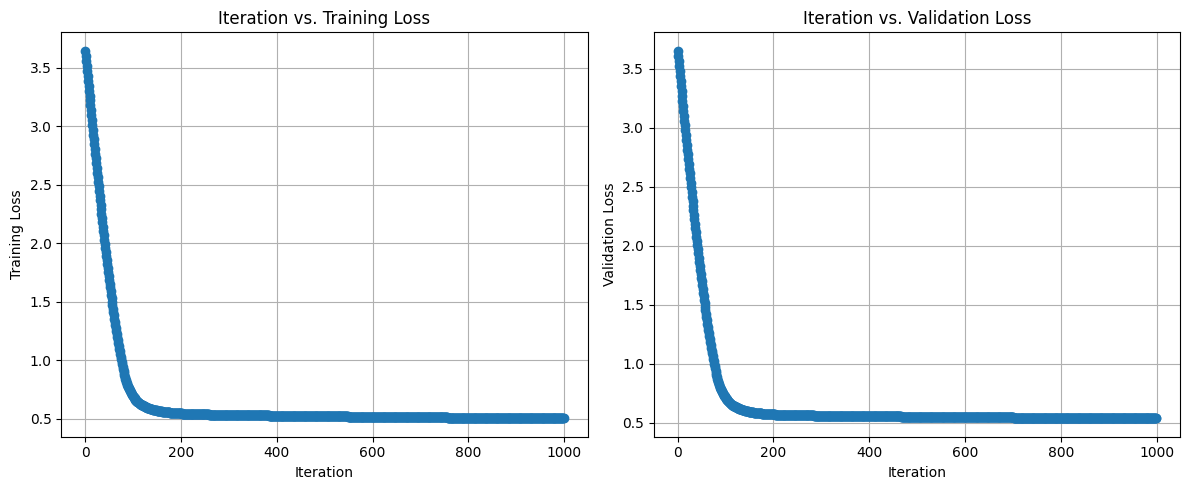

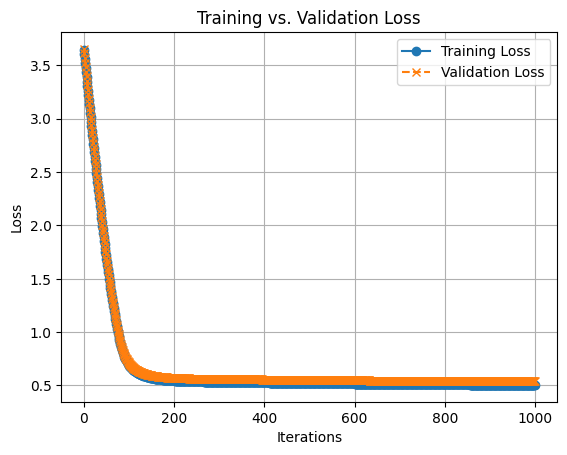

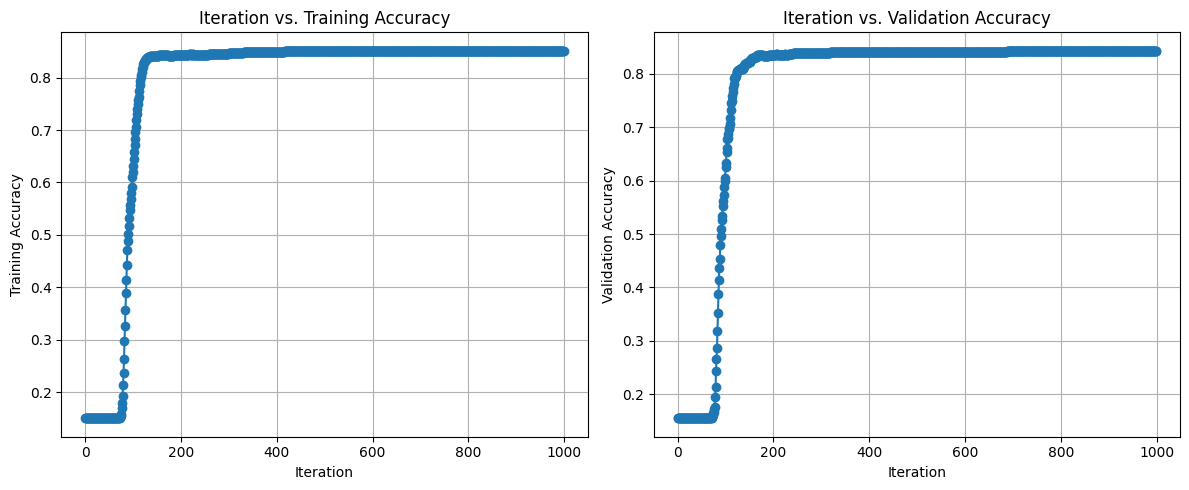

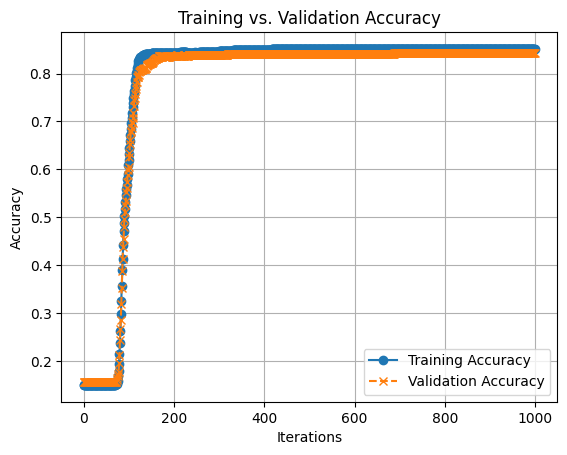

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Iteration vs. Training Loss
axes[0].plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Iteration vs. Training Loss')
axes[0].grid(True)

# Iteration vs. Validation Loss
axes[1].plot(range(len(validationLoss)), validationLoss, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Iteration vs. Validation Loss')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Training Loss vs. Validation Loss
plt.plot(range(len(trainingLoss)), trainingLoss, marker='o', linestyle='-', label='Training Loss')
plt.plot(range(len(validationLoss)), validationLoss, marker='x', linestyle='--', label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.grid(True)
plt.legend()
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Iteration vs. Training Accuracy
axes[0].plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Training Accuracy')
axes[0].set_title('Iteration vs. Training Accuracy')
axes[0].grid(True)

# Iteration vs. Validation Accuracy
axes[1].plot(range(len(validationAccuracy)), validationAccuracy, marker='o', linestyle='-')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Iteration vs. Validation Accuracy')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Training Loss vs. Validation Accuracy
plt.plot(range(len(trainingAccuracy)), trainingAccuracy, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(range(len(validationAccuracy)), validationAccuracy, marker='x', linestyle='--', label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
predictions = np.empty(len(xValidation))
probabilities = np.empty(len(xValidation))

for sample in range(len(xValidation)):
    predictions[sample] = predictClass(xValidation[sample],parameters,sigmoid)
    probabilities[sample] = sigmoid(xValidation[sample],parameters)

precision = precision_score(yValidation, predictions)
recall = recall_score(yValidation, predictions)
f1 = f1_score(yValidation, predictions)
roc_auc = roc_auc_score(yValidation, probabilities)


print(f"F1 Score: {f1:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"ROC-AUC Score: {roc_auc:.3f}")


F1 Score: 0.044
Recall: 0.024
Precision: 0.400
ROC-AUC Score: 0.452


### **L2 (Ridge) Regularization Derivation**

Ridge regression adds a penalty proportional to the square of the parameters to the original cost function in logistic regression. Typically, logistic regression aims to minimize the following cost function (without regularization):

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y_i \log(h_\theta(x_i)) + (1 - y_i) \log(1 - h_\theta(x_i)) \right]
$$

where $h_\theta(x_i) = \frac{1}{1 + e^{-\theta^T x_i}}$.

For Ridge regression, we add an $L2$-norm penalty to this cost function:

$$
J_{ridge}(\theta) = J(\theta) + \lambda \sum_{j=1}^{n} \theta_j^2
$$

To derive the update rule from this, we take the gradient of the cost function with respect to $\theta_j$:

$$
\frac{\partial J_{ridge}(\theta)}{\partial \theta_j} = \frac{\partial J(\theta)}{\partial \theta_j} + 2 \lambda \theta_j
$$

The first part, $\frac{\partial J(\theta)}{\partial \theta_j}$, is the gradient of the logistic regression loss function, which results in:

$$
\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x_i) - y_i) x_{ij}
$$

Now adding the regularization term, the update rule becomes:

$$
\theta_j = \theta_j - \text{learningRate} \cdot \left[ \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x_i) - y_i) x_{ij} + 2 \lambda \theta_j \right]
$$


### **learning rate = 0.00012**

In [34]:
learningRate = 0.00012
maxIterations = 1000
regularizationCoefficient = 1

earlyParameters = np.ones(countFeatures) * 0.01
earlyTrainingLoss = np.empty(maxIterations)
earlyValidationLoss = np.empty(maxIterations)
earlyTrainingAccuracy = np.empty(maxIterations)
earlyValidationAccuracy = np.empty(maxIterations)

parameters = earlyParameters
trainingLoss = np.empty(maxIterations)
validationLoss = np.empty(maxIterations)
trainingAccuracy = np.empty(maxIterations)
validationAccuracy = np.empty(maxIterations)

previousLoss = 100000000
earlyStoppingOccurred = False
earlyStoppingIteration = 0


for iteration in range(maxIterations):
    tempEarlyParameters = batchGradientDescentL2Regularization(learningRate, 1, xTraining, yTraining, earlyParameters, sigmoid, regularizationCoefficient)
    earlyTrainingLoss[iteration], earlyValidationLoss[iteration] = calculateLoss(xTraining, yTraining, xValidation, yValidation, tempEarlyParameters)
    earlyTrainingAccuracy[iteration], earlyValidationAccuracy[iteration] = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, tempEarlyParameters)
    
    if previousLoss >= earlyValidationLoss[iteration]:
        earlyParameters = tempEarlyParameters
        previousLoss = earlyValidationLoss[iteration]
    else:
        earlyStoppingOccurred = True
        earlyStoppingIteration = iteration
        print(f"Previous : {previousLoss}, Now : {earlyValidationLoss[iteration]}")
        earlyTrainingLoss = earlyTrainingLoss[:iteration]
        earlyValidationLoss = earlyValidationLoss[:iteration]
        earlyTrainingAccuracy = earlyTrainingAccuracy[:iteration]
        earlyValidationAccuracy = earlyValidationAccuracy[:iteration]
        print(f"Early stopping stopped training at iteration : {iteration-1}")
        break

if earlyStoppingOccurred:
    for iteration in range(earlyStoppingIteration, maxIterations):
        tempParameters = batchGradientDescentL2Regularization(learningRate, 1, xTraining, yTraining, earlyParameters, sigmoid, regularizationCoefficient)
        trainingLoss[iteration], validationLoss[iteration] = calculateLoss(xTraining, yTraining, xValidation, yValidation, tempParameters)
        trainingAccuracy[iteration], validationAccuracy[iteration] = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, tempParameters)
    
    trainingLoss[:earlyStoppingIteration] = earlyTrainingLoss
    validationLoss[:earlyStoppingIteration] = earlyValidationLoss
    trainingAccuracy[:earlyStoppingIteration] = earlyTrainingAccuracy
    validationAccuracy[:earlyStoppingIteration] = earlyValidationAccuracy
else:
    trainingLoss[:maxIterations] = earlyTrainingLoss
    validationLoss[:maxIterations] = earlyValidationLoss
    trainingAccuracy[:maxIterations] = earlyTrainingAccuracy
    validationAccuracy[:maxIterations] = earlyValidationAccuracy

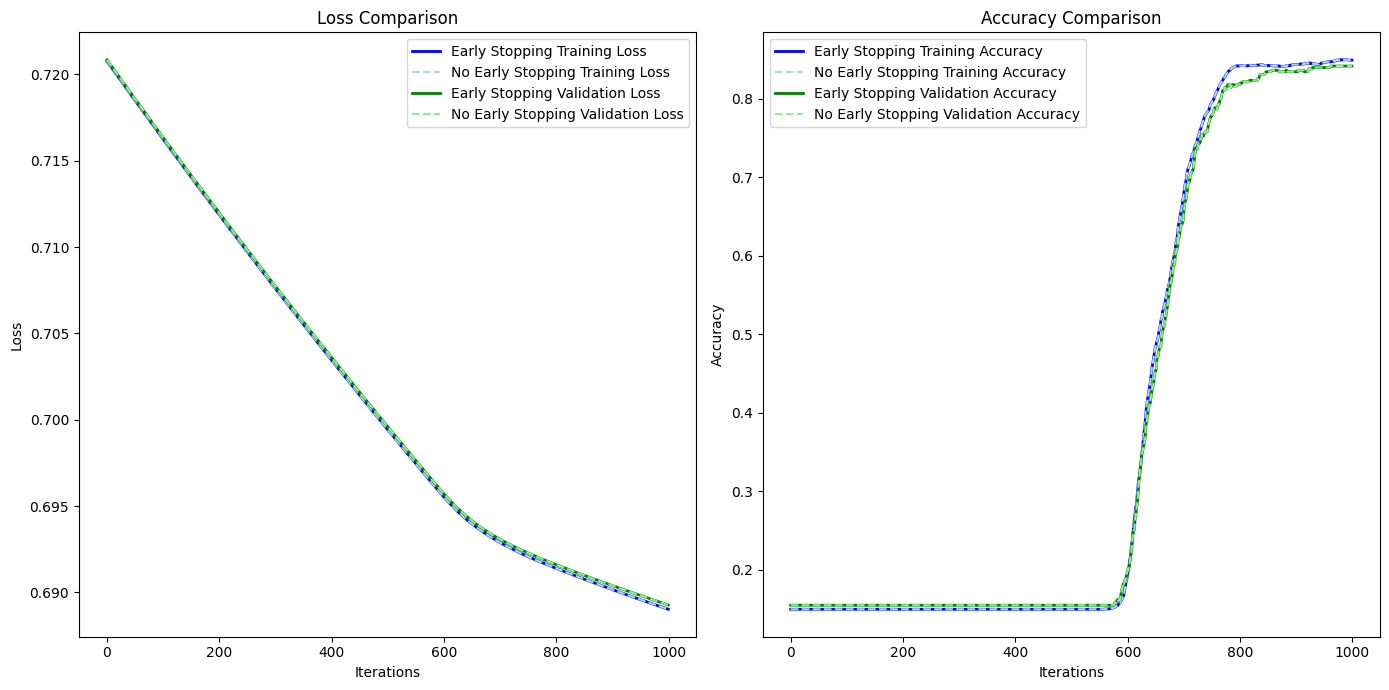

In [35]:
plt.figure(figsize=(14, 7))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(earlyTrainingLoss)), earlyTrainingLoss, label='Early Stopping Training Loss', color='blue', linewidth=2)
plt.plot(range(len(trainingLoss)), trainingLoss, label='No Early Stopping Training Loss', color='lightblue', linestyle='--')
plt.plot(range(len(earlyValidationLoss)), earlyValidationLoss, label='Early Stopping Validation Loss', color='green', linewidth=2)
plt.plot(range(len(validationLoss)), validationLoss, label='No Early Stopping Validation Loss', color='lightgreen', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(earlyTrainingAccuracy)), earlyTrainingAccuracy, label='Early Stopping Training Accuracy', color='blue', linewidth=2)
plt.plot(range(len(trainingAccuracy)), trainingAccuracy, label='No Early Stopping Training Accuracy', color='lightblue', linestyle='--')
plt.plot(range(len(earlyValidationAccuracy)), earlyValidationAccuracy, label='Early Stopping Validation Accuracy', color='green', linewidth=2)
plt.plot(range(len(validationAccuracy)), validationAccuracy, label='No Early Stopping Validation Accuracy', color='lightgreen', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.tight_layout()
plt.show()

In [36]:
earlyStoppingPredictions = np.empty(len(xValidation))
earlyStoppingProbabilities = np.empty(len(xValidation))

noEarlyStoppingPredictions = np.empty(len(xValidation))
noEarlyStoppingProbabilities = np.empty(len(xValidation))

for sample in range(len(xValidation)):
    earlyStoppingPredictions[sample] = predictClass(xValidation[sample], earlyParameters, sigmoid)
    earlyStoppingProbabilities[sample] = sigmoid(xValidation[sample], earlyParameters)

precisionEarly = precision_score(yValidation, earlyStoppingPredictions)
recallEarly = recall_score(yValidation, earlyStoppingPredictions)
f1Early = f1_score(yValidation, earlyStoppingPredictions)
roc_aucEarly = roc_auc_score(yValidation, earlyStoppingProbabilities)

print("Early Stopping Metrics:")
print(f"F1 Score: {f1Early:.3f}")
print(f"Recall: {recallEarly:.3f}")
print(f"Precision: {precisionEarly:.3f}")
print(f"ROC-AUC Score: {roc_aucEarly:.3f}")

for sample in range(len(xValidation)):
    noEarlyStoppingPredictions[sample] = predictClass(xValidation[sample], parameters, sigmoid)
    noEarlyStoppingProbabilities[sample] = sigmoid(xValidation[sample], parameters)

precisionNoEarly = precision_score(yValidation, noEarlyStoppingPredictions)
recallNoEarly = recall_score(yValidation, noEarlyStoppingPredictions)
f1NoEarly = f1_score(yValidation, noEarlyStoppingPredictions)
roc_aucNoEarly = roc_auc_score(yValidation, noEarlyStoppingProbabilities)

print("\nNo Early Stopping Metrics:")
print(f"F1 Score: {f1NoEarly:.3f}")
print(f"Recall: {recallNoEarly:.3f}")
print(f"Precision: {precisionNoEarly:.3f}")
print(f"ROC-AUC Score: {roc_aucNoEarly:.3f}")

Early Stopping Metrics:
F1 Score: 0.044
Recall: 0.024
Precision: 0.333
ROC-AUC Score: 0.422

No Early Stopping Metrics:
F1 Score: 0.044
Recall: 0.024
Precision: 0.333
ROC-AUC Score: 0.422


### **learning rate = 0.0001**

In [37]:
learningRate = 0.0001
maxIterations = 1000
regularizationCoefficient = 1

earlyParameters = np.ones(countFeatures) * 0.01
earlyTrainingLoss = np.empty(maxIterations)
earlyValidationLoss = np.empty(maxIterations)
earlyTrainingAccuracy = np.empty(maxIterations)
earlyValidationAccuracy = np.empty(maxIterations)

parameters = earlyParameters
trainingLoss = np.empty(maxIterations)
validationLoss = np.empty(maxIterations)
trainingAccuracy = np.empty(maxIterations)
validationAccuracy = np.empty(maxIterations)

previousLoss = 100000000
earlyStoppingOccurred = False
earlyStoppingIteration = 0


for iteration in range(maxIterations):
    tempEarlyParameters = batchGradientDescentL2Regularization(learningRate, 1, xTraining, yTraining, earlyParameters, sigmoid, regularizationCoefficient)
    earlyTrainingLoss[iteration], earlyValidationLoss[iteration] = calculateLoss(xTraining, yTraining, xValidation, yValidation, tempEarlyParameters)
    earlyTrainingAccuracy[iteration], earlyValidationAccuracy[iteration] = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, tempEarlyParameters)
    
    if previousLoss >= earlyValidationLoss[iteration]:
        earlyParameters = tempEarlyParameters
        previousLoss = earlyValidationLoss[iteration]
    else:
        earlyStoppingOccurred = True
        earlyStoppingIteration = iteration
        print(f"Previous : {previousLoss}, Now : {earlyValidationLoss[iteration]}")
        earlyTrainingLoss = earlyTrainingLoss[:iteration]
        earlyValidationLoss = earlyValidationLoss[:iteration]
        earlyTrainingAccuracy = earlyTrainingAccuracy[:iteration]
        earlyValidationAccuracy = earlyValidationAccuracy[:iteration]
        print(f"Early stopping stopped training at iteration : {iteration-1}")
        break

if earlyStoppingOccurred:
    for iteration in range(earlyStoppingIteration, maxIterations):
        tempParameters = batchGradientDescentL2Regularization(learningRate, 1, xTraining, yTraining, earlyParameters, sigmoid, regularizationCoefficient)
        trainingLoss[iteration], validationLoss[iteration] = calculateLoss(xTraining, yTraining, xValidation, yValidation, tempParameters)
        trainingAccuracy[iteration], validationAccuracy[iteration] = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, tempParameters)
    
    trainingLoss[:earlyStoppingIteration] = earlyTrainingLoss
    validationLoss[:earlyStoppingIteration] = earlyValidationLoss
    trainingAccuracy[:earlyStoppingIteration] = earlyTrainingAccuracy
    validationAccuracy[:earlyStoppingIteration] = earlyValidationAccuracy
else:
    trainingLoss[:maxIterations] = earlyTrainingLoss
    validationLoss[:maxIterations] = earlyValidationLoss
    trainingAccuracy[:maxIterations] = earlyTrainingAccuracy
    validationAccuracy[:maxIterations] = earlyValidationAccuracy

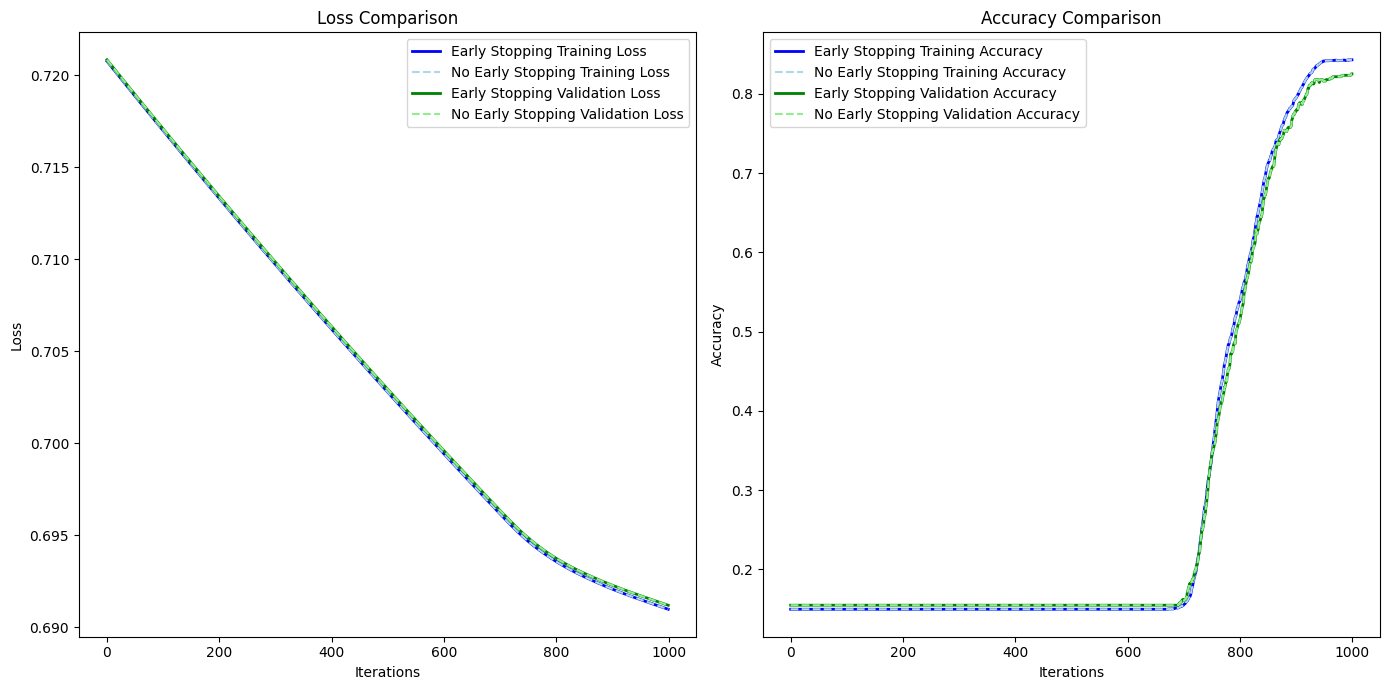

In [38]:
plt.figure(figsize=(14, 7))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(earlyTrainingLoss)), earlyTrainingLoss, label='Early Stopping Training Loss', color='blue', linewidth=2)
plt.plot(range(len(trainingLoss)), trainingLoss, label='No Early Stopping Training Loss', color='lightblue', linestyle='--')
plt.plot(range(len(earlyValidationLoss)), earlyValidationLoss, label='Early Stopping Validation Loss', color='green', linewidth=2)
plt.plot(range(len(validationLoss)), validationLoss, label='No Early Stopping Validation Loss', color='lightgreen', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(earlyTrainingAccuracy)), earlyTrainingAccuracy, label='Early Stopping Training Accuracy', color='blue', linewidth=2)
plt.plot(range(len(trainingAccuracy)), trainingAccuracy, label='No Early Stopping Training Accuracy', color='lightblue', linestyle='--')
plt.plot(range(len(earlyValidationAccuracy)), earlyValidationAccuracy, label='Early Stopping Validation Accuracy', color='green', linewidth=2)
plt.plot(range(len(validationAccuracy)), validationAccuracy, label='No Early Stopping Validation Accuracy', color='lightgreen', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.tight_layout()
plt.show()

In [39]:
earlyStoppingPredictions = np.empty(len(xValidation))
earlyStoppingProbabilities = np.empty(len(xValidation))

noEarlyStoppingPredictions = np.empty(len(xValidation))
noEarlyStoppingProbabilities = np.empty(len(xValidation))

for sample in range(len(xValidation)):
    earlyStoppingPredictions[sample] = predictClass(xValidation[sample], earlyParameters, sigmoid)
    earlyStoppingProbabilities[sample] = sigmoid(xValidation[sample], earlyParameters)

precisionEarly = precision_score(yValidation, earlyStoppingPredictions)
recallEarly = recall_score(yValidation, earlyStoppingPredictions)
f1Early = f1_score(yValidation, earlyStoppingPredictions)
roc_aucEarly = roc_auc_score(yValidation, earlyStoppingProbabilities)

print("Early Stopping Metrics:")
print(f"F1 Score: {f1Early:.3f}")
print(f"Recall: {recallEarly:.3f}")
print(f"Precision: {precisionEarly:.3f}")
print(f"ROC-AUC Score: {roc_aucEarly:.3f}")

for sample in range(len(xValidation)):
    noEarlyStoppingPredictions[sample] = predictClass(xValidation[sample], parameters, sigmoid)
    noEarlyStoppingProbabilities[sample] = sigmoid(xValidation[sample], parameters)

precisionNoEarly = precision_score(yValidation, noEarlyStoppingPredictions)
recallNoEarly = recall_score(yValidation, noEarlyStoppingPredictions)
f1NoEarly = f1_score(yValidation, noEarlyStoppingPredictions)
roc_aucNoEarly = roc_auc_score(yValidation, noEarlyStoppingProbabilities)

print("\nNo Early Stopping Metrics:")
print(f"F1 Score: {f1NoEarly:.3f}")
print(f"Recall: {recallNoEarly:.3f}")
print(f"Precision: {precisionNoEarly:.3f}")
print(f"ROC-AUC Score: {roc_aucNoEarly:.3f}")

Early Stopping Metrics:
F1 Score: 0.094
Recall: 0.059
Precision: 0.238
ROC-AUC Score: 0.442

No Early Stopping Metrics:
F1 Score: 0.094
Recall: 0.059
Precision: 0.238
ROC-AUC Score: 0.442


### **L1 (Lasso) Regularization Derivation**

Lasso regression uses an $L1$-norm penalty, which is proportional to the absolute value of the parameters:

$$
J_{lasso}(\theta) = J(\theta) + \lambda \sum_{j=1}^{n} |\theta_j|
$$

The gradient of this cost function is not differentiable at $\theta_j = 0$, so instead of directly computing the derivative, we apply the sub-gradient method:

$$
\frac{\partial J_{lasso}(\theta)}{\partial \theta_j} = \frac{\partial J(\theta)}{\partial \theta_j} + \lambda \cdot \text{sign}(\theta_j)
$$

The term $\text{sign}(\theta_j)$ takes the value $+1$ if $\theta_j > 0$, $-1$ if $\theta_j < 0$, and is undefined at $\theta_j = 0$ (but usually treated as 0 for numerical stability).

Thus, the update rule for Lasso becomes:

$$
\theta_j = \theta_j - \text{learningRate} \cdot \left[ \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x_i) - y_i) x_{ij} + \lambda \cdot \text{sign}(\theta_j) \right]
$$

### **learning rate = 0.000015**

In [40]:
learningRate = 0.000015
maxIterations = 1000
regularizationCoefficient = 1

earlyParameters = np.ones(countFeatures) * 0.01
earlyTrainingLoss = np.empty(maxIterations)
earlyValidationLoss = np.empty(maxIterations)
earlyTrainingAccuracy = np.empty(maxIterations)
earlyValidationAccuracy = np.empty(maxIterations)

parameters = earlyParameters
trainingLoss = np.empty(maxIterations)
validationLoss = np.empty(maxIterations)
trainingAccuracy = np.empty(maxIterations)
validationAccuracy = np.empty(maxIterations)

previousLoss = 100000000
earlyStoppingOccurred = False
earlyStoppingIteration = 0


for iteration in range(maxIterations):
    tempEarlyParameters = batchGradientDescentL1Regularization(learningRate, 1, xTraining, yTraining, earlyParameters, sigmoid, regularizationCoefficient)
    earlyTrainingLoss[iteration], earlyValidationLoss[iteration] = calculateLoss(xTraining, yTraining, xValidation, yValidation, tempEarlyParameters)
    earlyTrainingAccuracy[iteration], earlyValidationAccuracy[iteration] = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, tempEarlyParameters)
    
    if previousLoss >= earlyValidationLoss[iteration]:
        earlyParameters = tempEarlyParameters
        previousLoss = earlyValidationLoss[iteration]
    else:
        earlyStoppingOccurred = True
        earlyStoppingIteration = iteration
        print(f"Previous : {previousLoss}, Now : {earlyValidationLoss[iteration]}")
        earlyTrainingLoss = earlyTrainingLoss[:iteration]
        earlyValidationLoss = earlyValidationLoss[:iteration]
        earlyTrainingAccuracy = earlyTrainingAccuracy[:iteration]
        earlyValidationAccuracy = earlyValidationAccuracy[:iteration]
        print(f"Early stopping stopped training at iteration : {iteration-1}")
        break

if earlyStoppingOccurred:
    for iteration in range(earlyStoppingIteration, maxIterations):
        tempParameters = batchGradientDescentL2Regularization(learningRate, 1, xTraining, yTraining, earlyParameters, sigmoid, regularizationCoefficient)
        trainingLoss[iteration], validationLoss[iteration] = calculateLoss(xTraining, yTraining, xValidation, yValidation, tempParameters)
        trainingAccuracy[iteration], validationAccuracy[iteration] = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, tempParameters)
    
    trainingLoss[:earlyStoppingIteration] = earlyTrainingLoss
    validationLoss[:earlyStoppingIteration] = earlyValidationLoss
    trainingAccuracy[:earlyStoppingIteration] = earlyTrainingAccuracy
    validationAccuracy[:earlyStoppingIteration] = earlyValidationAccuracy
else:
    trainingLoss[:maxIterations] = earlyTrainingLoss
    validationLoss[:maxIterations] = earlyValidationLoss
    trainingAccuracy[:maxIterations] = earlyTrainingAccuracy
    validationAccuracy[:maxIterations] = earlyValidationAccuracy

Previous : 0.6935044040102679, Now : 0.6935120686817259
Early stopping stopped training at iteration : 598


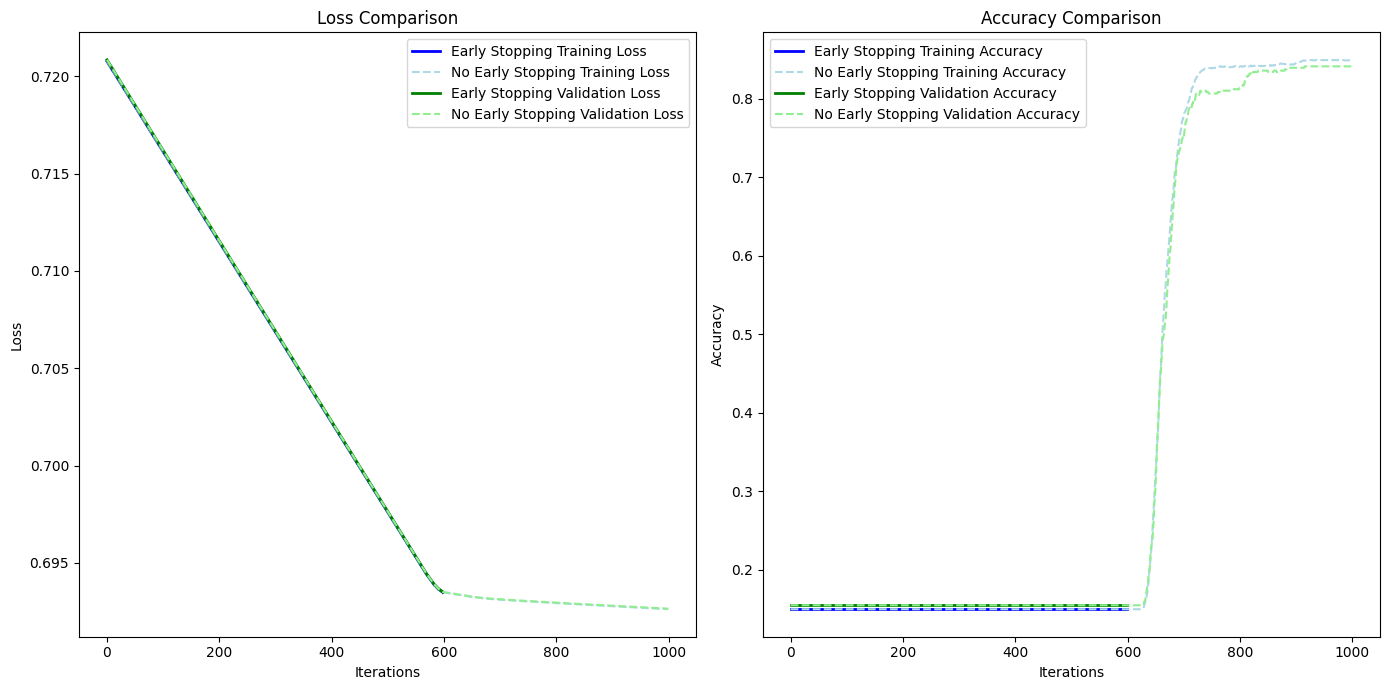

In [41]:
plt.figure(figsize=(14, 7))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(earlyTrainingLoss)), earlyTrainingLoss, label='Early Stopping Training Loss', color='blue', linewidth=2)
plt.plot(range(len(trainingLoss)), trainingLoss, label='No Early Stopping Training Loss', color='lightblue', linestyle='--')
plt.plot(range(len(earlyValidationLoss)), earlyValidationLoss, label='Early Stopping Validation Loss', color='green', linewidth=2)
plt.plot(range(len(validationLoss)), validationLoss, label='No Early Stopping Validation Loss', color='lightgreen', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(earlyTrainingAccuracy)), earlyTrainingAccuracy, label='Early Stopping Training Accuracy', color='blue', linewidth=2)
plt.plot(range(len(trainingAccuracy)), trainingAccuracy, label='No Early Stopping Training Accuracy', color='lightblue', linestyle='--')
plt.plot(range(len(earlyValidationAccuracy)), earlyValidationAccuracy, label='Early Stopping Validation Accuracy', color='green', linewidth=2)
plt.plot(range(len(validationAccuracy)), validationAccuracy, label='No Early Stopping Validation Accuracy', color='lightgreen', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.tight_layout()
plt.show()

In [42]:
earlyStoppingPredictions = np.empty(len(xValidation))
earlyStoppingProbabilities = np.empty(len(xValidation))

noEarlyStoppingPredictions = np.empty(len(xValidation))
noEarlyStoppingProbabilities = np.empty(len(xValidation))

for sample in range(len(xValidation)):
    earlyStoppingPredictions[sample] = predictClass(xValidation[sample], earlyParameters, sigmoid)
    earlyStoppingProbabilities[sample] = sigmoid(xValidation[sample], earlyParameters)

precisionEarly = precision_score(yValidation, earlyStoppingPredictions)
recallEarly = recall_score(yValidation, earlyStoppingPredictions)
f1Early = f1_score(yValidation, earlyStoppingPredictions)
roc_aucEarly = roc_auc_score(yValidation, earlyStoppingProbabilities)

print("Early Stopping Metrics:")
print(f"F1 Score: {f1Early:.3f}")
print(f"Recall: {recallEarly:.3f}")
print(f"Precision: {precisionEarly:.3f}")
print(f"ROC-AUC Score: {roc_aucEarly:.3f}")

for sample in range(len(xValidation)):
    noEarlyStoppingPredictions[sample] = predictClass(xValidation[sample], parameters, sigmoid)
    noEarlyStoppingProbabilities[sample] = sigmoid(xValidation[sample], parameters)

precisionNoEarly = precision_score(yValidation, noEarlyStoppingPredictions)
recallNoEarly = recall_score(yValidation, noEarlyStoppingPredictions)
f1NoEarly = f1_score(yValidation, noEarlyStoppingPredictions)
roc_aucNoEarly = roc_auc_score(yValidation, noEarlyStoppingProbabilities)

print("\nNo Early Stopping Metrics:")
print(f"F1 Score: {f1NoEarly:.3f}")
print(f"Recall: {recallNoEarly:.3f}")
print(f"Precision: {precisionNoEarly:.3f}")
print(f"ROC-AUC Score: {roc_aucNoEarly:.3f}")

Early Stopping Metrics:
F1 Score: 0.044
Recall: 0.024
Precision: 0.333
ROC-AUC Score: 0.406

No Early Stopping Metrics:
F1 Score: 0.044
Recall: 0.024
Precision: 0.333
ROC-AUC Score: 0.406


### **learning rate = 0.00001**

In [43]:
learningRate = 0.00001
maxIterations = 1000
regularizationCoefficient = 1

earlyParameters = np.ones(countFeatures) * 0.01
earlyTrainingLoss = np.empty(maxIterations)
earlyValidationLoss = np.empty(maxIterations)
earlyTrainingAccuracy = np.empty(maxIterations)
earlyValidationAccuracy = np.empty(maxIterations)

parameters = earlyParameters
trainingLoss = np.empty(maxIterations)
validationLoss = np.empty(maxIterations)
trainingAccuracy = np.empty(maxIterations)
validationAccuracy = np.empty(maxIterations)

previousLoss = 100000000
earlyStoppingOccurred = False
earlyStoppingIteration = 0


for iteration in range(maxIterations):
    tempEarlyParameters = batchGradientDescentL1Regularization(learningRate, 1, xTraining, yTraining, earlyParameters, sigmoid, regularizationCoefficient)
    earlyTrainingLoss[iteration], earlyValidationLoss[iteration] = calculateLoss(xTraining, yTraining, xValidation, yValidation, tempEarlyParameters)
    earlyTrainingAccuracy[iteration], earlyValidationAccuracy[iteration] = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, tempEarlyParameters)
    
    if previousLoss >= earlyValidationLoss[iteration]:
        earlyParameters = tempEarlyParameters
        previousLoss = earlyValidationLoss[iteration]
    else:
        earlyStoppingOccurred = True
        earlyStoppingIteration = iteration
        print(f"Previous : {previousLoss}, Now : {earlyValidationLoss[iteration]}")
        earlyTrainingLoss = earlyTrainingLoss[:iteration]
        earlyValidationLoss = earlyValidationLoss[:iteration]
        earlyTrainingAccuracy = earlyTrainingAccuracy[:iteration]
        earlyValidationAccuracy = earlyValidationAccuracy[:iteration]
        print(f"Early stopping stopped training at iteration : {iteration-1}")
        break

if earlyStoppingOccurred:
    for iteration in range(earlyStoppingIteration, maxIterations):
        tempParameters = batchGradientDescentL2Regularization(learningRate, 1, xTraining, yTraining, earlyParameters, sigmoid, regularizationCoefficient)
        trainingLoss[iteration], validationLoss[iteration] = calculateLoss(xTraining, yTraining, xValidation, yValidation, tempParameters)
        trainingAccuracy[iteration], validationAccuracy[iteration] = calculateAccuracy(xTraining, yTraining, xValidation, yValidation, tempParameters)
    
    trainingLoss[:earlyStoppingIteration] = earlyTrainingLoss
    validationLoss[:earlyStoppingIteration] = earlyValidationLoss
    trainingAccuracy[:earlyStoppingIteration] = earlyTrainingAccuracy
    validationAccuracy[:earlyStoppingIteration] = earlyValidationAccuracy
else:
    trainingLoss[:maxIterations] = earlyTrainingLoss
    validationLoss[:maxIterations] = earlyValidationLoss
    trainingAccuracy[:maxIterations] = earlyTrainingAccuracy
    validationAccuracy[:maxIterations] = earlyValidationAccuracy

Previous : 0.6935292574550541, Now : 0.6935294436069568
Early stopping stopped training at iteration : 896


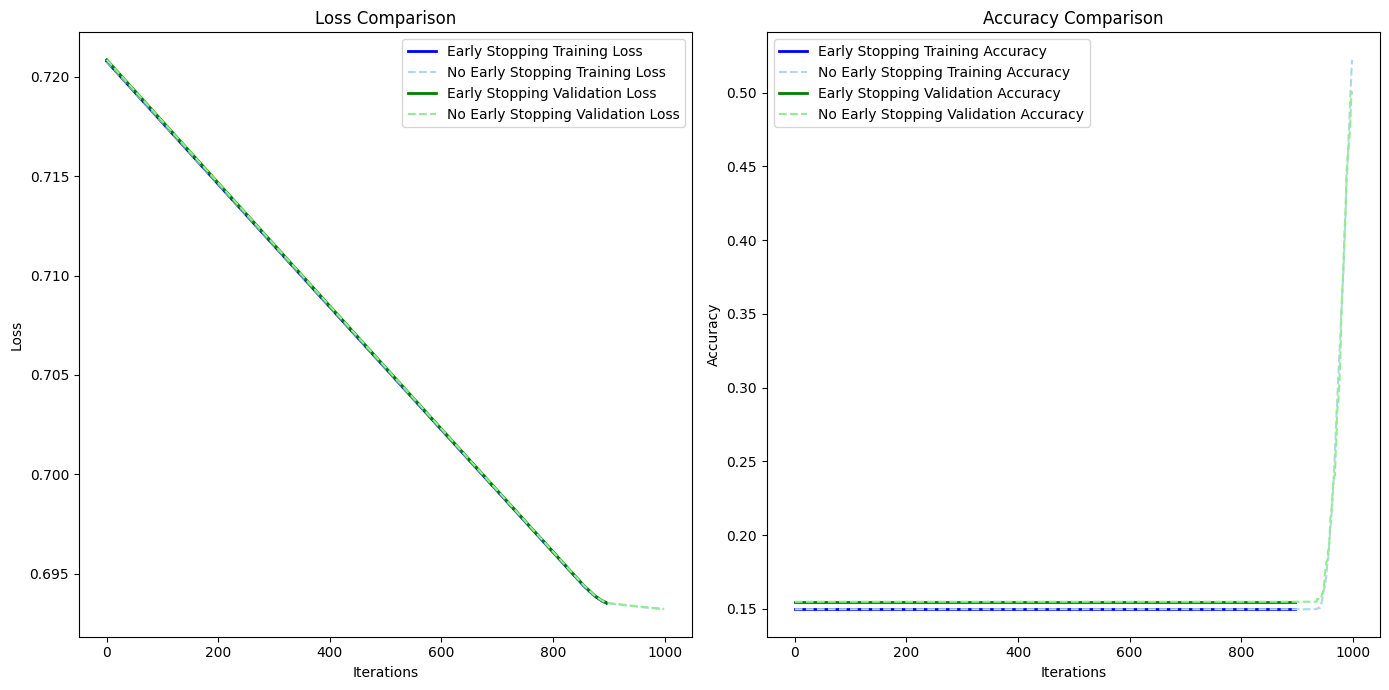

In [44]:
plt.figure(figsize=(14, 7))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(len(earlyTrainingLoss)), earlyTrainingLoss, label='Early Stopping Training Loss', color='blue', linewidth=2)
plt.plot(range(len(trainingLoss)), trainingLoss, label='No Early Stopping Training Loss', color='lightblue', linestyle='--')
plt.plot(range(len(earlyValidationLoss)), earlyValidationLoss, label='Early Stopping Validation Loss', color='green', linewidth=2)
plt.plot(range(len(validationLoss)), validationLoss, label='No Early Stopping Validation Loss', color='lightgreen', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(len(earlyTrainingAccuracy)), earlyTrainingAccuracy, label='Early Stopping Training Accuracy', color='blue', linewidth=2)
plt.plot(range(len(trainingAccuracy)), trainingAccuracy, label='No Early Stopping Training Accuracy', color='lightblue', linestyle='--')
plt.plot(range(len(earlyValidationAccuracy)), earlyValidationAccuracy, label='Early Stopping Validation Accuracy', color='green', linewidth=2)
plt.plot(range(len(validationAccuracy)), validationAccuracy, label='No Early Stopping Validation Accuracy', color='lightgreen', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Comparison')

plt.tight_layout()
plt.show()

In [45]:
earlyStoppingPredictions = np.empty(len(xValidation))
earlyStoppingProbabilities = np.empty(len(xValidation))

noEarlyStoppingPredictions = np.empty(len(xValidation))
noEarlyStoppingProbabilities = np.empty(len(xValidation))

for sample in range(len(xValidation)):
    earlyStoppingPredictions[sample] = predictClass(xValidation[sample], earlyParameters, sigmoid)
    earlyStoppingProbabilities[sample] = sigmoid(xValidation[sample], earlyParameters)

precisionEarly = precision_score(yValidation, earlyStoppingPredictions)
recallEarly = recall_score(yValidation, earlyStoppingPredictions)
f1Early = f1_score(yValidation, earlyStoppingPredictions)
roc_aucEarly = roc_auc_score(yValidation, earlyStoppingProbabilities)

print("Early Stopping Metrics:")
print(f"F1 Score: {f1Early:.3f}")
print(f"Recall: {recallEarly:.3f}")
print(f"Precision: {precisionEarly:.3f}")
print(f"ROC-AUC Score: {roc_aucEarly:.3f}")

for sample in range(len(xValidation)):
    noEarlyStoppingPredictions[sample] = predictClass(xValidation[sample], parameters, sigmoid)
    noEarlyStoppingProbabilities[sample] = sigmoid(xValidation[sample], parameters)

precisionNoEarly = precision_score(yValidation, noEarlyStoppingPredictions)
recallNoEarly = recall_score(yValidation, noEarlyStoppingPredictions)
f1NoEarly = f1_score(yValidation, noEarlyStoppingPredictions)
roc_aucNoEarly = roc_auc_score(yValidation, noEarlyStoppingProbabilities)

print("\nNo Early Stopping Metrics:")
print(f"F1 Score: {f1NoEarly:.3f}")
print(f"Recall: {recallNoEarly:.3f}")
print(f"Precision: {precisionNoEarly:.3f}")
print(f"ROC-AUC Score: {roc_aucNoEarly:.3f}")

Early Stopping Metrics:
F1 Score: 0.283
Recall: 0.635
Precision: 0.182
ROC-AUC Score: 0.594

No Early Stopping Metrics:
F1 Score: 0.283
Recall: 0.635
Precision: 0.182
ROC-AUC Score: 0.594


# SECTION C : 

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
import seaborn as sns

## **(a) (2.5 marks) Perform EDA by creating pair plots, box plots, violin plots, count plots for categorical features, and a correlation heatmap. Based on these visualizations, provide at least five insights on the dataset.**

In [47]:
sns.set_theme(style='whitegrid')
dataframe = pd.read_csv('Electricity BILL.csv')

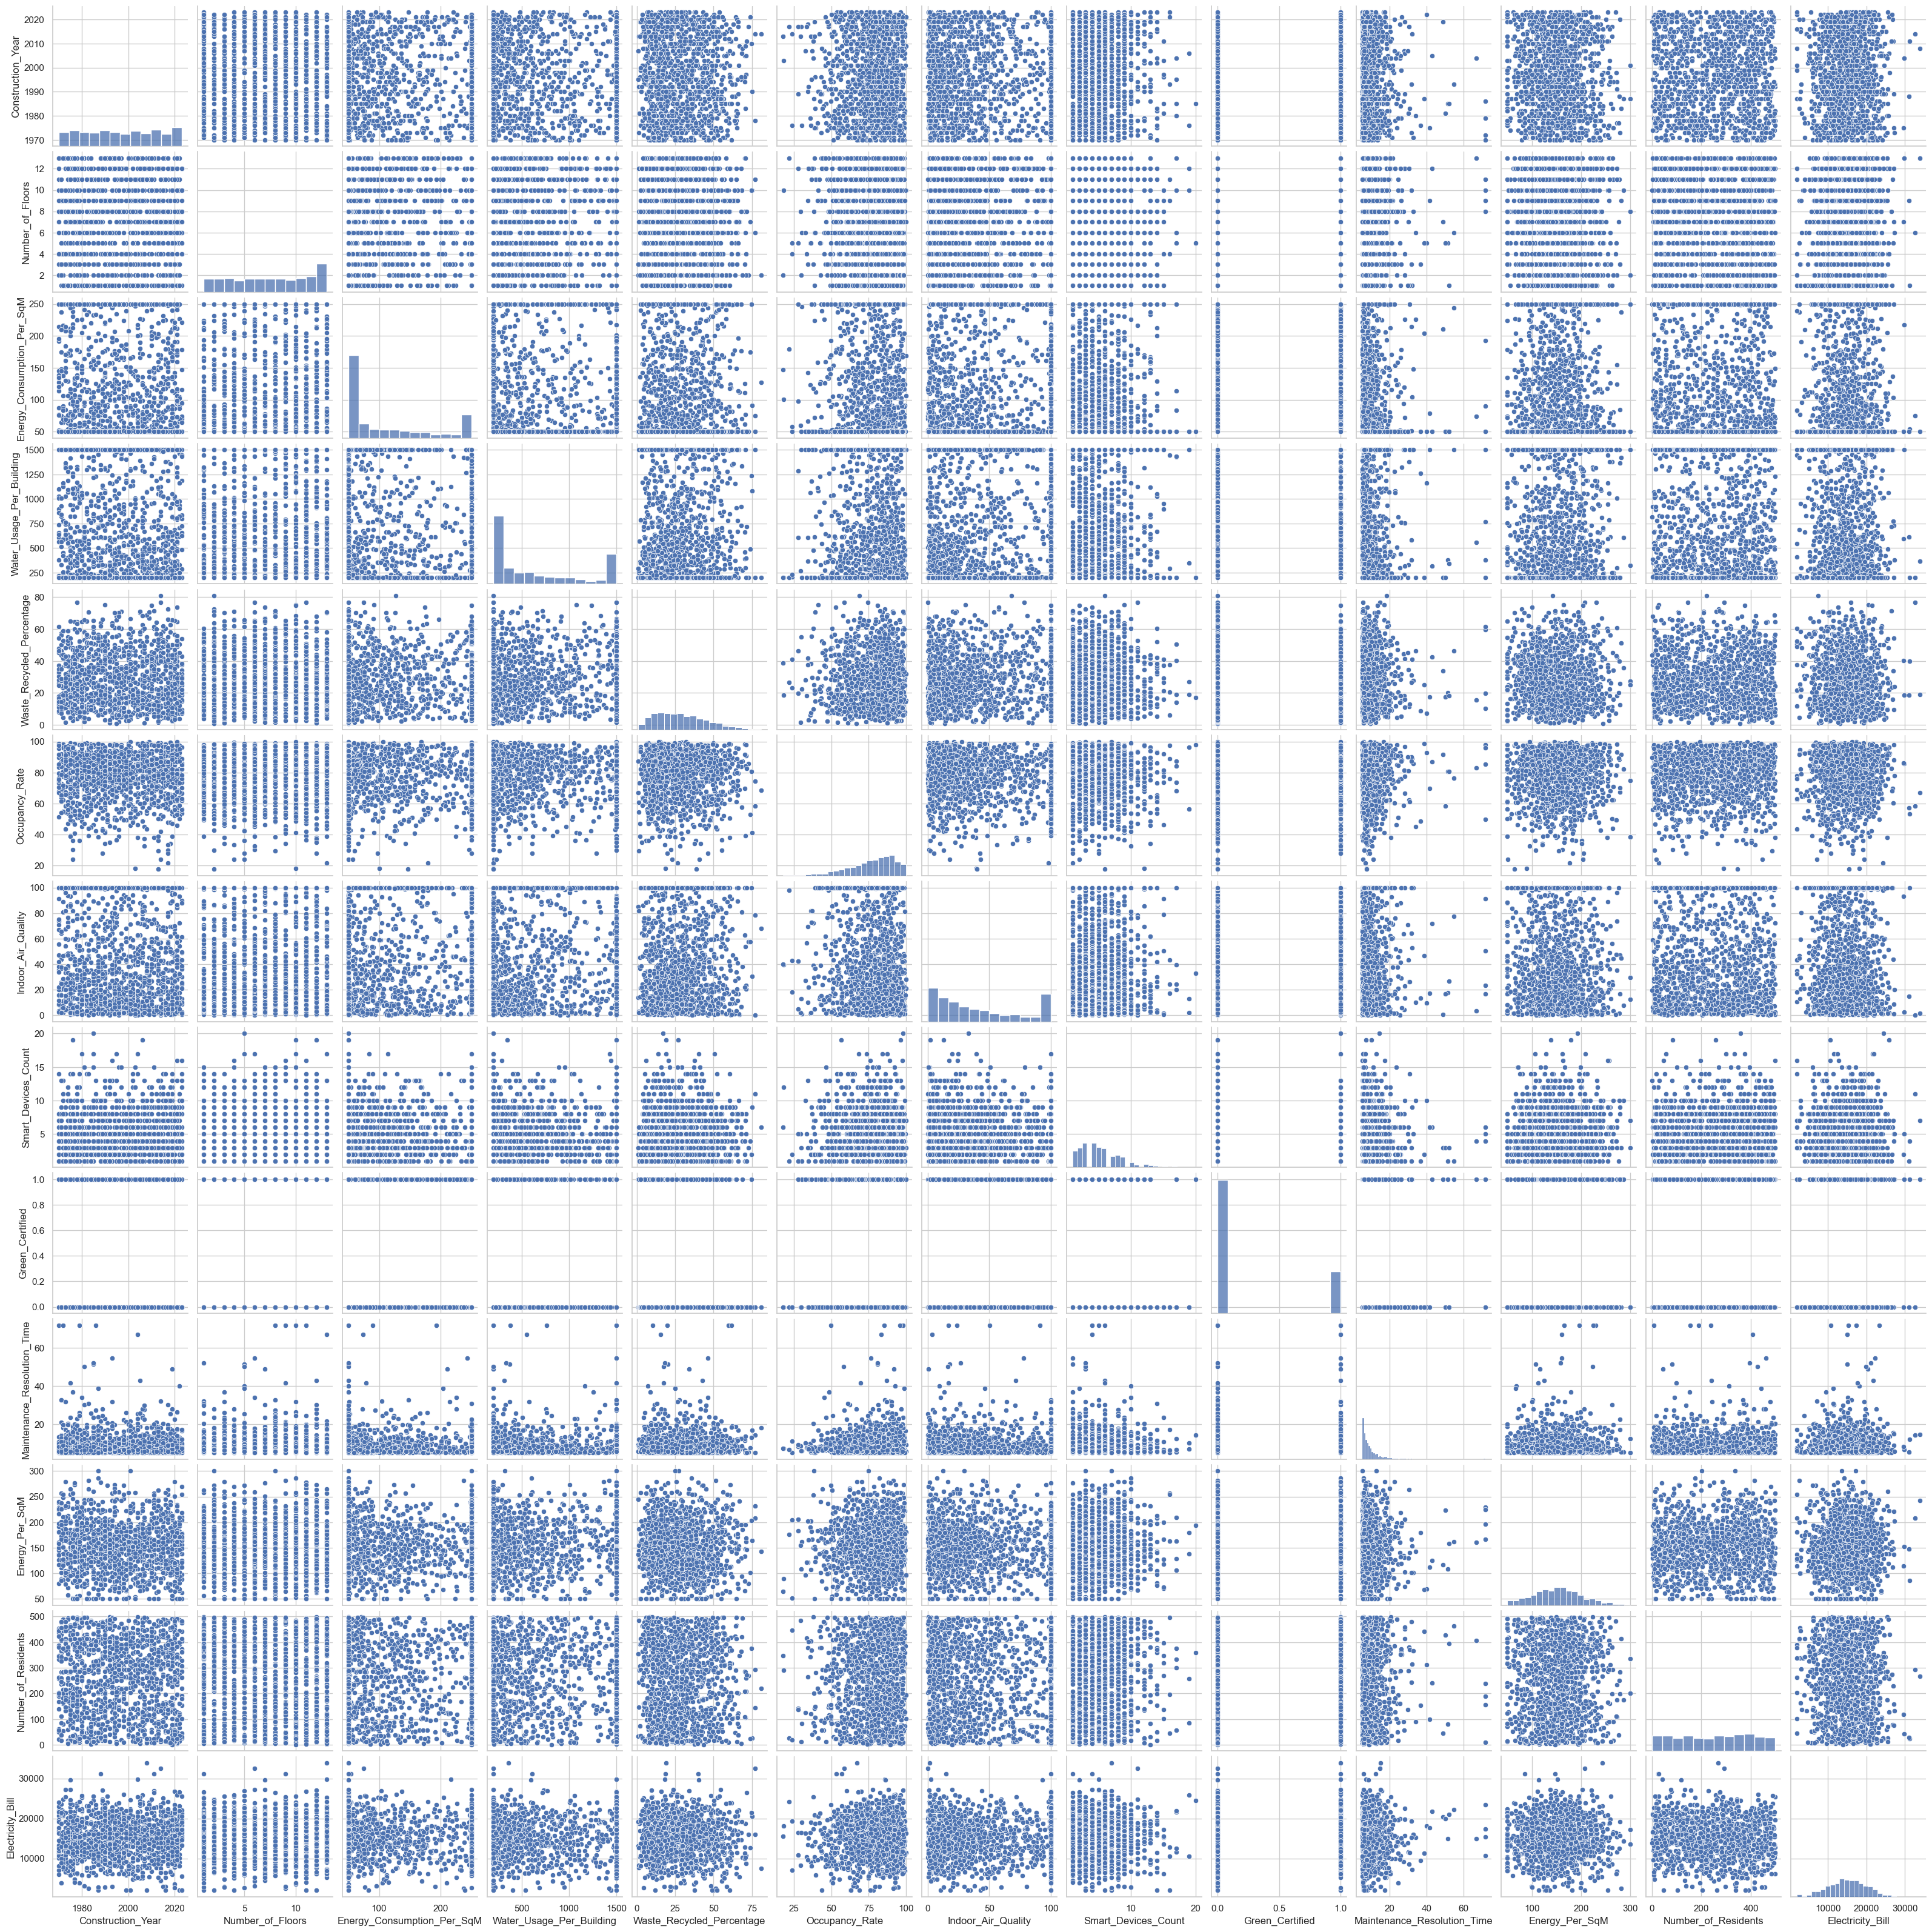

In [48]:
sns.pairplot(dataframe)
plt.show()

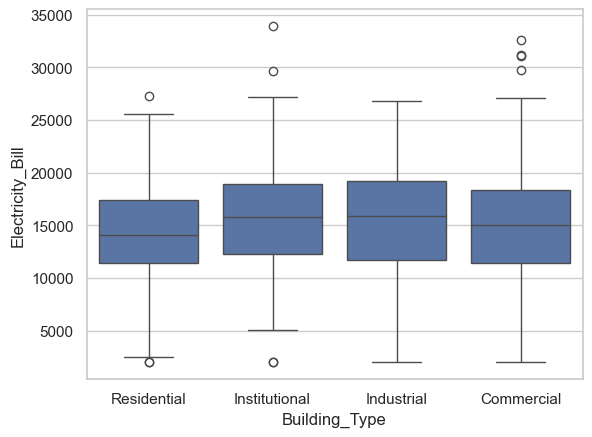

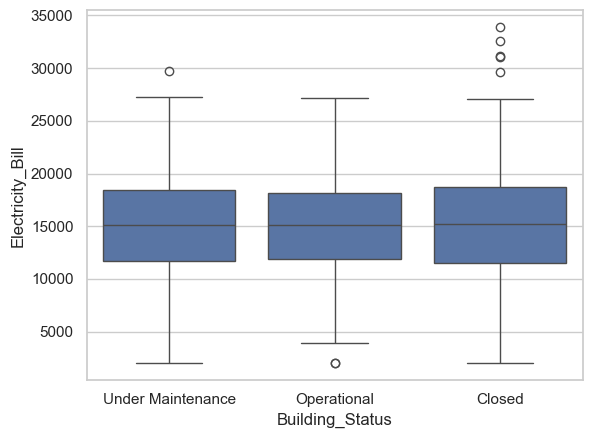

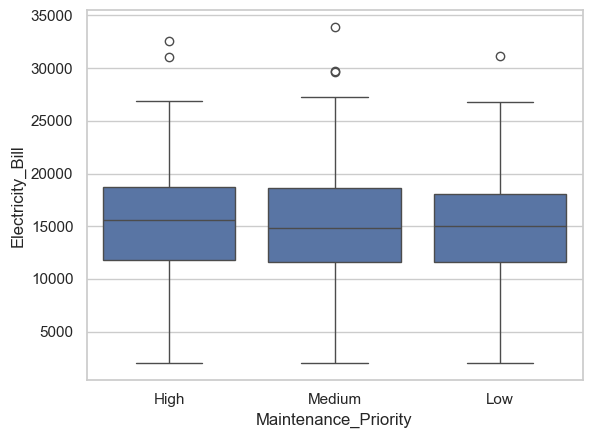

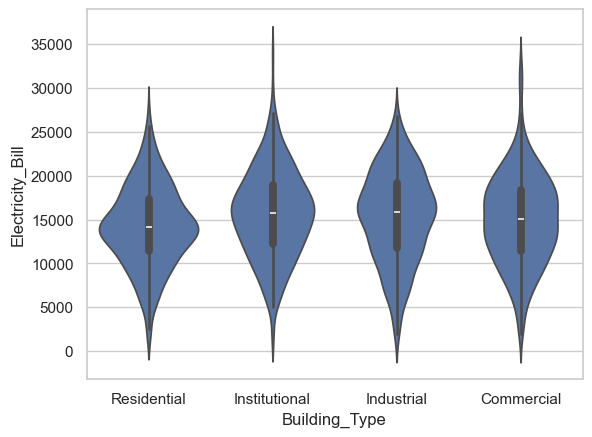

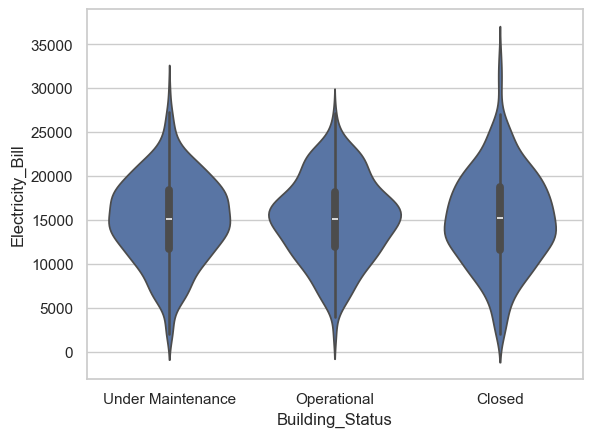

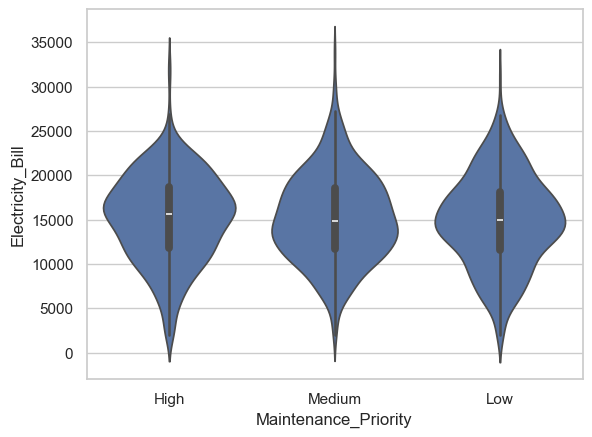

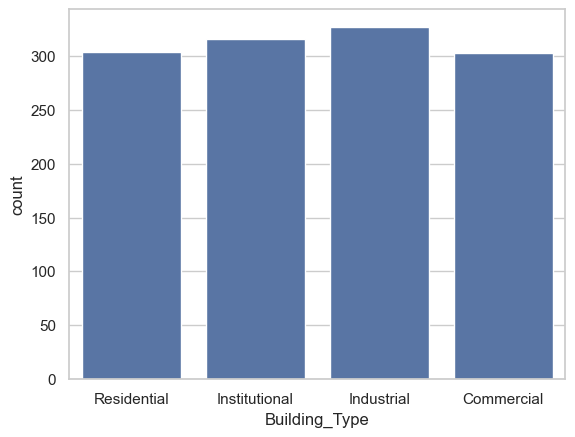

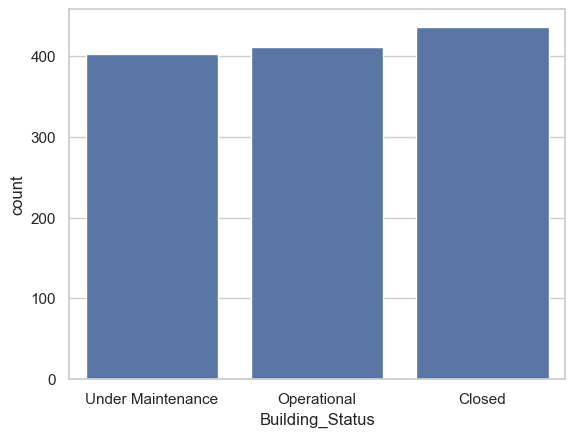

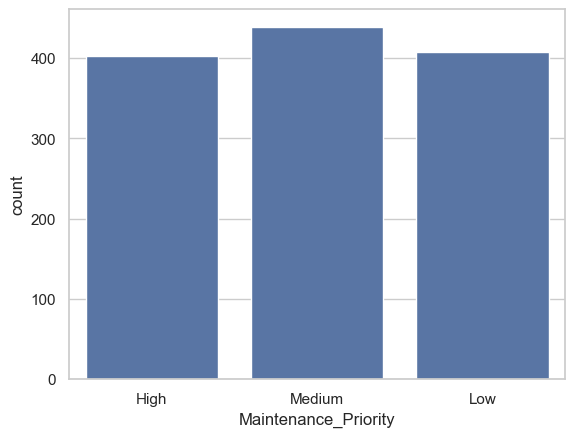

In [49]:
category=['Building_Type','Building_Status','Maintenance_Priority']
for i in category:


    sns.boxplot(x=i, y='Electricity_Bill', data=dataframe)
    plt.show()

for i in category:


    sns.violinplot(x=i, y='Electricity_Bill', data=dataframe)
    plt.show()

for i in category:


    sns.countplot(x=i,  data=dataframe)
    plt.show()        

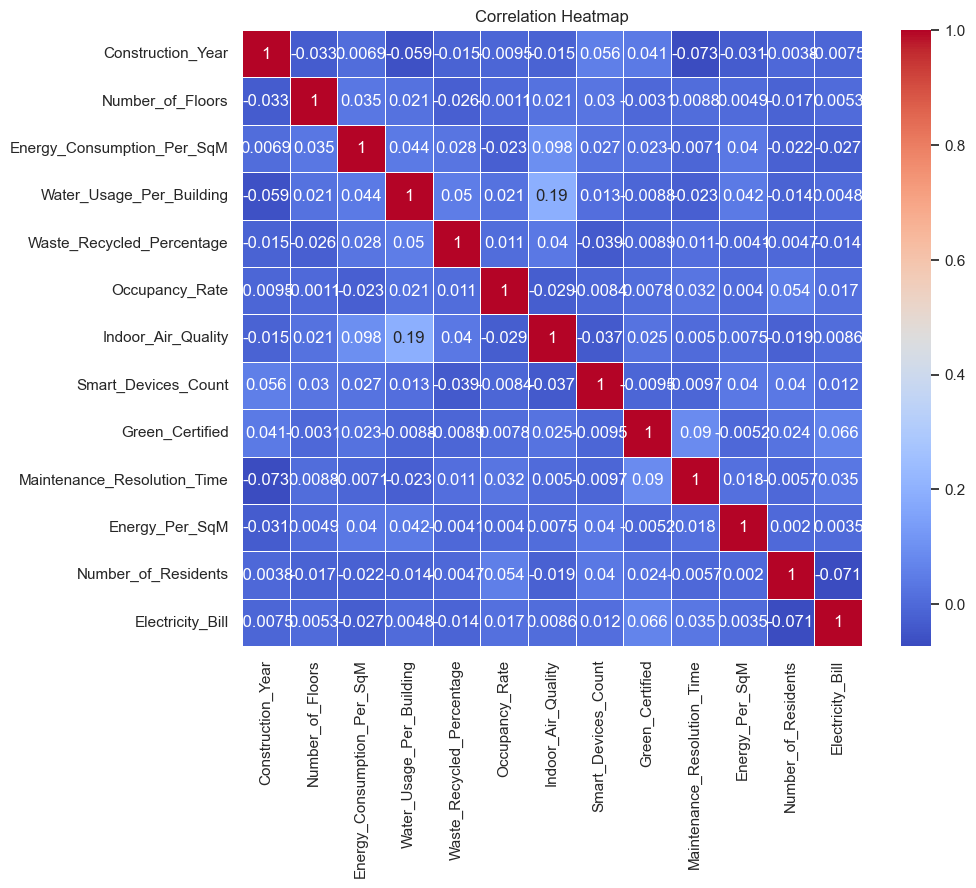

In [50]:
plt.figure(figsize=(10, 8))
corr_matrix=dataframe.select_dtypes(include=['float64','int64'])
corr_matrix = corr_matrix.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

## **(b) (1 marks)Use the Uniform Manifold Approximation and Projection (UMAP) algorithm to reduce the data dimensions to 2 and plot the resulting data as a scatter plot.**

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import umap

c:\Users\Lakshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
dataFrame = pd.read_csv("Electricity BILL.csv")

rowsBefore = len(dataFrame)
dataFrame = dataFrame.dropna()
rowsAfter = len(dataFrame)

print(f"\nBefore removing rows with NA values, the dataset had {rowsBefore} rows.")
print(f"After using dropna(), it now contains {rowsAfter} rows.")
print(f"This means that {rowsBefore - rowsAfter} rows with missing values were removed.\n")

y = dataFrame["Electricity_Bill"].values
dropColumns = ["Electricity_Bill"]
x = dataFrame.drop(columns=dropColumns)

labelEncoders = {}
for column in x.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    x[column] = le.fit_transform(x[column])
    labelEncoders[column] = le

x = x.values

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Samples in Training set: {len(xTrain)}  (80%)")
print(f"Samples in Testing set: {len(xTest)}  (20%)")



Before removing rows with NA values, the dataset had 1250 rows.
After using dropna(), it now contains 1250 rows.
This means that 0 rows with missing values were removed.

Samples in Training set: 1000  (80%)
Samples in Testing set: 250  (20%)


c:\Users\Lakshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


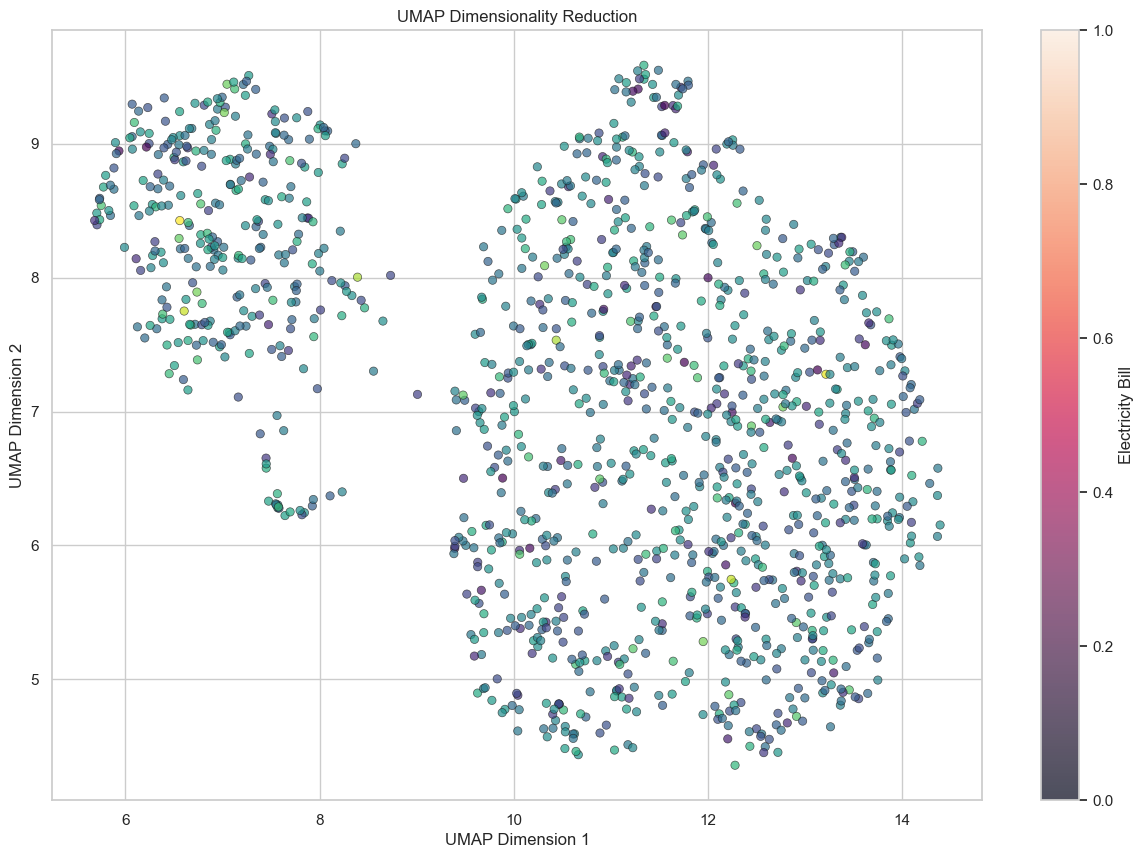

In [53]:
scaler = StandardScaler()
xScaled = scaler.fit_transform(x)

umapReducer = umap.UMAP(n_components=2, random_state=42)
xUmap = umapReducer.fit_transform(xScaled)

sns.set_theme(style="whitegrid", palette="viridis")
plt.figure(figsize=(15, 10))
scatter = sns.scatterplot(x=xUmap[:, 0], y=xUmap[:, 1], hue=y, palette='viridis', edgecolor='k', alpha=0.7, legend=False)
plt.colorbar(scatter.collections[0], label='Electricity Bill')
plt.title('UMAP Dimensionality Reduction')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

## **(c) (2.5 marks) Perform the necessary pre-processing steps, including handling missing values and normalizing numerical features. For categorical features, use LabelEncoding. Apply Linear Regression on the preprocessed data**

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [55]:
lrModel = LinearRegression()
lrModel.fit(xTrain, yTrain)

yTrainPred = lrModel.predict(xTrain)
yTestPred = lrModel.predict(xTest)

def adjustedR2Score(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    
def reportMetrics(yTrue, yPred, xData, datasetName):
    mse = mean_squared_error(yTrue, yPred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yTrue, yPred)
    adjR2 = adjustedR2Score(r2, len(yTrue), xData.shape[1])
    mae = mean_absolute_error(yTrue, yPred)

    sns.set_theme(style="whitegrid")
    print(f"{datasetName} Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"R2 Score: {r2:.3f}")
    print(f"Adjusted R2 Score: {adjR2:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}\n")

reportMetrics(yTrain, yTrainPred, xTrain, "Training Set")
reportMetrics(yTest, yTestPred, xTest, "Test Set")


Training Set Metrics:
Mean Squared Error (MSE): 24475013.168
Root Mean Squared Error (RMSE): 4947.223
R2 Score: 0.014
Adjusted R2 Score: -0.001
Mean Absolute Error (MAE): 4006.328

Test Set Metrics:
Mean Squared Error (MSE): 24278016.156
Root Mean Squared Error (RMSE): 4927.273
R2 Score: 0.000
Adjusted R2 Score: -0.064
Mean Absolute Error (MAE): 3842.409



## **(d) (2 marks) Perform Recursive Feature Elimination (RFE) or Correlation analysis on the original dataset to select the 3 most important features.**

In [56]:
from sklearn.feature_selection import RFE

In [57]:
lr = LinearRegression()

rfe = RFE(estimator=lr, n_features_to_select=3)
rfe.fit(xTrain, yTrain)

selectedFeatureIndices = rfe.support_
selectedFeaturesRfe = dataFrame.drop(columns=dropColumns).columns[selectedFeatureIndices]
print(f"Top 3 selected features using RFE: {selectedFeaturesRfe}")

xTrainRfe = rfe.transform(xTrain)
xTestRfe = rfe.transform(xTest)

lrModelRfe = LinearRegression()
lrModelRfe.fit(xTrainRfe, yTrain)

yTrainPredRfe = lrModelRfe.predict(xTrainRfe)
yTestPredRfe = lrModelRfe.predict(xTestRfe)

print("\nResults using RFE-selected features:")
reportMetrics(yTrain, yTrainPredRfe, xTrainRfe, "Training Set (RFE)")
reportMetrics(yTest, yTestPredRfe, xTestRfe, "Test Set (RFE)")


Top 3 selected features using RFE: Index(['Building_Type', 'Green_Certified', 'Building_Status'], dtype='object')

Results using RFE-selected features:
Training Set (RFE) Metrics:
Mean Squared Error (MSE): 24673540.312
Root Mean Squared Error (RMSE): 4967.247
R2 Score: 0.006
Adjusted R2 Score: 0.003
Mean Absolute Error (MAE): 4006.784

Test Set (RFE) Metrics:
Mean Squared Error (MSE): 24181190.647
Root Mean Squared Error (RMSE): 4917.437
R2 Score: 0.004
Adjusted R2 Score: -0.008
Mean Absolute Error (MAE): 3825.652



## **(e) (2 marks) Encode the categorical features of the original dataset using One-Hot Encoding and perform Ridge Regression on the preprocessed data.**

In [58]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

In [59]:
dataFrame = pd.read_csv("Electricity BILL.csv")

rowsBefore = len(dataFrame)
dataFrame = dataFrame.dropna()
rowsAfter = len(dataFrame)

print(f"Before removing rows with NA values, the dataset had {rowsBefore} rows.")
print(f"After using dropna(), it now contains {rowsAfter} rows.")
print(f"This means that {rowsBefore - rowsAfter} rows with missing values were removed.\n")

y = dataFrame["Electricity_Bill"].values
dropColumns = ["Electricity_Bill"]
dataEncoded = pd.get_dummies(dataFrame.drop(columns=dropColumns))

x = dataEncoded.values

xTrainEncoded, xTestEncoded, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Samples in Training set: {len(xTrainEncoded)}  (80%)")
print(f"Samples in Testing set: {len(xTestEncoded)}  (20%)")

Before removing rows with NA values, the dataset had 1250 rows.
After using dropna(), it now contains 1250 rows.
This means that 0 rows with missing values were removed.

Samples in Training set: 1000  (80%)
Samples in Testing set: 250  (20%)


In [60]:
from sklearn.linear_model import Ridge

ridgeModel = Ridge(alpha=1.0)
ridgeModel.fit(xTrainEncoded, yTrain)

yTrainPredRidge = ridgeModel.predict(xTrainEncoded)
yTestPredRidge = ridgeModel.predict(xTestEncoded)

def adjustedR2Score(r2: float, n: int, p: int) -> float:
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

def reportMetrics(yTrue: np.array, yPred: np.array, xData: np.array, datasetName: str) -> None:
    mse = mean_squared_error(yTrue, yPred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yTrue, yPred)
    adjR2 = adjustedR2Score(r2, len(yTrue), xData.shape[1])
    mae = mean_absolute_error(yTrue, yPred)

    print(f"{datasetName} Metrics:")
    print(f"  Mean Squared Error (MSE):     {mse:.3f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"  R2 Score:                      {r2:.3f}")
    print(f"  Adjusted R2 Score:             {adjR2:.3f}")
    print(f"  Mean Absolute Error (MAE):     {mae:.3f}\n")

print("\nResults using Ridge Regression with One-Hot Encoded Features:")

reportMetrics(yTrain, yTrainPredRidge, xTrainEncoded, "Training Set (Ridge)")
reportMetrics(yTest, yTestPredRidge, xTestEncoded, "Test Set (Ridge)")

print("Comparison with Original Model Metrics:\n")

print("Original Model Metrics:")
reportMetrics(yTrain, yTrainPred, xTrain, "Training Set (Original)")
reportMetrics(yTest, yTestPred, xTest, "Test Set (Original)")



Results using Ridge Regression with One-Hot Encoded Features:
Training Set (Ridge) Metrics:
  Mean Squared Error (MSE):     24188933.389
  Root Mean Squared Error (RMSE): 4918.225
  R2 Score:                      0.025
  Adjusted R2 Score:             0.004
  Mean Absolute Error (MAE):     3976.677

Test Set (Ridge) Metrics:
  Mean Squared Error (MSE):     24130064.924
  Root Mean Squared Error (RMSE): 4912.236
  R2 Score:                      0.006
  Adjusted R2 Score:             -0.090
  Mean Absolute Error (MAE):     3797.607

Comparison with Original Model Metrics:

Original Model Metrics:
Training Set (Original) Metrics:
  Mean Squared Error (MSE):     24475013.168
  Root Mean Squared Error (RMSE): 4947.223
  R2 Score:                      0.014
  Adjusted R2 Score:             -0.001
  Mean Absolute Error (MAE):     4006.328

Test Set (Original) Metrics:
  Mean Squared Error (MSE):     24278016.156
  Root Mean Squared Error (RMSE): 4927.273
  R2 Score:                      0.00

## **(f) (2 marks) Perform Independent Component Analysis (ICA) on the one-hot encoded dataset and choose the appropriate number of components (try 4, 5, 6, and 8 components).**

In [61]:
from sklearn.decomposition import FastICA

In [62]:
nComponentsList = [4, 5, 6, 8]
results = {}

for nComponents in nComponentsList:
    ica = FastICA(n_components=nComponents, random_state=42)
    xTrainIca = ica.fit_transform(xTrainEncoded)
    xTestIca = ica.transform(xTestEncoded)

    lrModelIca = LinearRegression()
    lrModelIca.fit(xTrainIca, yTrain)

    yTrainPredIca = lrModelIca.predict(xTrainIca)
    yTestPredIca = lrModelIca.predict(xTestIca)

    mseTrain = mean_squared_error(yTrain, yTrainPredIca)
    rmseTrain = np.sqrt(mseTrain)
    r2Train = r2_score(yTrain, yTrainPredIca)
    adjR2Train = adjustedR2Score(r2Train, len(yTrain), xTrainIca.shape[1])
    maeTrain = mean_absolute_error(yTrain, yTrainPredIca)

    mseTest = mean_squared_error(yTest, yTestPredIca)
    rmseTest = np.sqrt(mseTest)
    r2Test = r2_score(yTest, yTestPredIca)
    adjR2Test = adjustedR2Score(r2Test, len(yTest), xTestIca.shape[1])
    maeTest = mean_absolute_error(yTest, yTestPredIca)

    results[nComponents] = {
        'Train MSE': mseTrain,
        'Train RMSE': rmseTrain,
        'Train R2': r2Train,
        'Train Adjusted R2': adjR2Train,
        'Train MAE': maeTrain,
        'Test MSE': mseTest,
        'Test RMSE': rmseTest,
        'Test R2': r2Test,
        'Test Adjusted R2': adjR2Test,
        'Test MAE': maeTest
    }

# Print comparison results using Seaborn
sns.set_theme(style="whitegrid")
print("\nComparison of ICA Components:")

for nComponents, metrics in results.items():
    print(f"\nNumber of Components: {nComponents}")
    print(f"  Train MSE: {metrics['Train MSE']:.3f}")
    print(f"  Train RMSE: {metrics['Train RMSE']:.3f}")
    print(f"  Train R2: {metrics['Train R2']:.3f}")
    print(f"  Train Adjusted R2: {metrics['Train Adjusted R2']:.3f}")
    print(f"  Train MAE: {metrics['Train MAE']:.3f}")
    print(f"  Test MSE: {metrics['Test MSE']:.3f}")
    print(f"  Test RMSE: {metrics['Test RMSE']:.3f}")
    print(f"  Test R2: {metrics['Test R2']:.3f}")
    print(f"  Test Adjusted R2: {metrics['Test Adjusted R2']:.3f}")
    print(f"  Test MAE: {metrics['Test MAE']:.3f}")



Comparison of ICA Components:

Number of Components: 4
  Train MSE: 24701058.640
  Train RMSE: 4970.016
  Train R2: 0.005
  Train Adjusted R2: 0.001
  Train MAE: 4010.995
  Test MSE: 24167148.348
  Test RMSE: 4916.009
  Test R2: 0.005
  Test Adjusted R2: -0.012
  Test MAE: 3818.895

Number of Components: 5
  Train MSE: 24683781.209
  Train RMSE: 4968.277
  Train R2: 0.006
  Train Adjusted R2: 0.001
  Train MAE: 4008.443
  Test MSE: 24261530.740
  Test RMSE: 4925.600
  Test R2: 0.001
  Test Adjusted R2: -0.020
  Test MAE: 3831.502

Number of Components: 6
  Train MSE: 24682728.783
  Train RMSE: 4968.172
  Train R2: 0.006
  Train Adjusted R2: -0.000
  Train MAE: 4009.407
  Test MSE: 24253844.061
  Test RMSE: 4924.819
  Test R2: 0.001
  Test Adjusted R2: -0.024
  Test MAE: 3829.863

Number of Components: 8
  Train MSE: 24674426.719
  Train RMSE: 4967.336
  Train R2: 0.006
  Train Adjusted R2: -0.002
  Train MAE: 4009.046
  Test MSE: 24222154.151
  Test RMSE: 4921.601
  Test R2: 0.002
  T

c:\Users\Lakshay\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


## **(g) (1.5 marks) Use ElasticNet regularization (which combines L1 and L2) while training a linear model on the preprocessed dataset from part (c).**

In [63]:
from sklearn.linear_model import ElasticNet

In [64]:
alphaValues = [0.1, 0.5, 1.0, 2.5, 5]
elasticNetResults = {}

for alpha in alphaValues:
    elasticNetModel = ElasticNet(alpha=alpha, l1_ratio=0.5, random_state=42)
    elasticNetModel.fit(xTrain, yTrain)
    
    yTrainPredElasticNet = elasticNetModel.predict(xTrain)
    yTestPredElasticNet = elasticNetModel.predict(xTest)
    
    mseTrain = mean_squared_error(yTrain, yTrainPredElasticNet)
    rmseTrain = np.sqrt(mseTrain)
    r2Train = r2_score(yTrain, yTrainPredElasticNet)
    adjR2Train = adjustedR2Score(r2Train, len(yTrain), xTrain.shape[1])
    maeTrain = mean_absolute_error(yTrain, yTrainPredElasticNet)

    mseTest = mean_squared_error(yTest, yTestPredElasticNet)
    rmseTest = np.sqrt(mseTest)
    r2Test = r2_score(yTest, yTestPredElasticNet)
    adjR2Test = adjustedR2Score(r2Test, len(yTest), xTest.shape[1])
    maeTest = mean_absolute_error(yTest, yTestPredElasticNet)

    elasticNetResults[alpha] = {
        'Train MSE': mseTrain,
        'Train RMSE': rmseTrain,
        'Train R2': r2Train,
        'Train Adjusted R2': adjR2Train,
        'Train MAE': maeTrain,
        'Test MSE': mseTest,
        'Test RMSE': rmseTest,
        'Test R2': r2Test,
        'Test Adjusted R2': adjR2Test,
        'Test MAE': maeTest
    }

sns.set_theme(style="whitegrid")

print("\nComparison of ElasticNet Regularization:")
for alpha, metrics in elasticNetResults.items():
    print(f"\nAlpha = {alpha}")
    print(f"  Train MSE: {metrics['Train MSE']:.3f}")
    print(f"  Train RMSE: {metrics['Train RMSE']:.3f}")
    print(f"  Train R2: {metrics['Train R2']:.3f}")
    print(f"  Train Adjusted R2: {metrics['Train Adjusted R2']:.3f}")
    print(f"  Train MAE: {metrics['Train MAE']:.3f}")
    print(f"  Test MSE: {metrics['Test MSE']:.3f}")
    print(f"  Test RMSE: {metrics['Test RMSE']:.3f}")
    print(f"  Test R2: {metrics['Test R2']:.3f}")
    print(f"  Test Adjusted R2: {metrics['Test Adjusted R2']:.3f}")
    print(f"  Test MAE: {metrics['Test MAE']:.3f}")



Comparison of ElasticNet Regularization:

Alpha = 0.1
  Train MSE: 24478622.815
  Train RMSE: 4947.588
  Train R2: 0.014
  Train Adjusted R2: -0.001
  Train MAE: 4004.150
  Test MSE: 24308446.255
  Test RMSE: 4930.360
  Test R2: -0.001
  Test Adjusted R2: -0.065
  Test MAE: 3843.056

Alpha = 0.5
  Train MSE: 24501830.544
  Train RMSE: 4949.932
  Train R2: 0.013
  Train Adjusted R2: -0.002
  Train MAE: 4002.687
  Test MSE: 24363819.803
  Test RMSE: 4935.972
  Test R2: -0.003
  Test Adjusted R2: -0.068
  Test MAE: 3843.840

Alpha = 1.0
  Train MSE: 24520670.765
  Train RMSE: 4951.835
  Train R2: 0.012
  Train Adjusted R2: -0.003
  Train MAE: 4003.117
  Test MSE: 24383240.110
  Test RMSE: 4937.939
  Test R2: -0.004
  Test Adjusted R2: -0.069
  Test MAE: 3843.982

Alpha = 2.5
  Train MSE: 24549745.520
  Train RMSE: 4954.770
  Train R2: 0.011
  Train Adjusted R2: -0.004
  Train MAE: 4004.670
  Test MSE: 24389488.384
  Test RMSE: 4938.571
  Test R2: -0.005
  Test Adjusted R2: -0.069
  Test 

## **(h) (1.5 marks) Use the Gradient Boosting Regressor to perform regression on the preprocessed dataset from part (c)**

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

In [66]:
gbrModel = GradientBoostingRegressor(random_state=42)
gbrModel.fit(xTrain, yTrain)

yTrainPredGbr = gbrModel.predict(xTrain)
yTestPredGbr = gbrModel.predict(xTest)

def calculateMetrics(yTrue, yPred, xData, datasetName):
    mse = mean_squared_error(yTrue, yPred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yTrue, yPred)
    adjR2 = adjustedR2Score(r2, len(yTrue), xData.shape[1])
    mae = mean_absolute_error(yTrue, yPred)

    print(f"{datasetName} Metrics:")
    print(f"  Mean Squared Error (MSE):     {mse:.3f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"  R2 Score:                      {r2:.3f}")
    print(f"  Adjusted R2 Score:             {adjR2:.3f}")
    print(f"  Mean Absolute Error (MAE):     {mae:.3f}\n")

sns.set_theme(style="whitegrid")

calculateMetrics(yTrain, yTrainPredGbr, xTrain, "Training Set (Gradient Boosting)")
calculateMetrics(yTest, yTestPredGbr, xTest, "Test Set (Gradient Boosting)")


Training Set (Gradient Boosting) Metrics:
  Mean Squared Error (MSE):     14926446.257
  Root Mean Squared Error (RMSE): 3863.476
  R2 Score:                      0.399
  Adjusted R2 Score:             0.389
  Mean Absolute Error (MAE):     3092.748

Test Set (Gradient Boosting) Metrics:
  Mean Squared Error (MSE):     24420565.348
  Root Mean Squared Error (RMSE): 4941.717
  R2 Score:                      -0.006
  Adjusted R2 Score:             -0.070
  Mean Absolute Error (MAE):     3819.610

